# 🔍 CRITICAL: Model Learning Diagnosis

**Issue Identified:** Linear Regression showing perfect performance (R²=1.0, RMSE=0.007) suggests potential problems:

## Potential Issues:
1. **Data Leakage**: Target variable or highly correlated features in training data
2. **Perfect Multicollinearity**: Features that perfectly predict the target
3. **Duplicate Features**: Same information represented multiple times
4. **Scale Mismatch**: Target variable rescaling issue

## Next Steps:
Run diagnostic cells below to identify and fix the root cause.

In [28]:
# ============================================================
# DIAGNOSTIC 1: Check for Data Leakage and Feature Issues
# ============================================================

import pandas as pd
import numpy as np
from scipy.stats import pearsonr

print("="*80)
print("DATA LEAKAGE & FEATURE CORRELATION DIAGNOSTIC")
print("="*80)

print("\n1. TARGET VARIABLE ANALYSIS:")
print(f"   y_train shape: {y_train.shape}")
print(f"   y_train min: {y_train.min().values[0]:.4f}")
print(f"   y_train max: {y_train.max().values[0]:.4f}")
print(f"   y_train mean: {y_train.mean().values[0]:.4f}")
print(f"   y_train std: {y_train.std().values[0]:.4f}")

print("\n2. FEATURE-TARGET CORRELATION (Top 20 highest):")
correlations = []
for col in X_train_processed.columns:
    corr, _ = pearsonr(X_train_processed[col], y_train.values.ravel())
    correlations.append((col, abs(corr)))

# Sort by absolute correlation
correlations.sort(key=lambda x: x[1], reverse=True)

print("\n   Feature Name                          | Correlation")
print("   " + "-"*70)
for feat, corr in correlations[:20]:
    warning = " ⚠️ SUSPICIOUS!" if corr > 0.95 else ""
    print(f"   {feat[:40]:<40} | {corr:.4f}{warning}")

print("\n3. CHECKING FOR PERFECT CORRELATIONS (>0.99):")
perfect_corr = [feat for feat, corr in correlations if corr > 0.99]
if perfect_corr:
    print(f"   ❌ FOUND {len(perfect_corr)} FEATURES WITH NEAR-PERFECT CORRELATION!")
    print(f"   These features likely cause data leakage:")
    for feat in perfect_corr:
        print(f"      - {feat}")
else:
    print("   ✅ No perfect correlations found")

print("\n4. FEATURE VARIANCE CHECK:")
zero_var_features = X_train_processed.columns[X_train_processed.std() == 0].tolist()
low_var_features = X_train_processed.columns[(X_train_processed.std() > 0) & (X_train_processed.std() < 0.01)].tolist()
print(f"   Zero variance features: {len(zero_var_features)}")
print(f"   Low variance features (<0.01): {len(low_var_features)}")

print("\n5. DUPLICATE FEATURES CHECK:")
# Check for duplicate columns
duplicate_cols = []
for i, col1 in enumerate(X_train_processed.columns):
    for col2 in X_train_processed.columns[i+1:]:
        if X_train_processed[col1].equals(X_train_processed[col2]):
            duplicate_cols.append((col1, col2))

if duplicate_cols:
    print(f"   ❌ FOUND {len(duplicate_cols)} DUPLICATE COLUMN PAIRS!")
    for c1, c2 in duplicate_cols[:5]:
        print(f"      - {c1} == {c2}")
else:
    print("   ✅ No duplicate columns found")

print("\n" + "="*80)
print("RECOMMENDATION:")
if perfect_corr:
    print("⚠️  CRITICAL: Remove features with >0.99 correlation to target!")
    print("   These features are causing unrealistic model performance.")
else:
    print("✅ No obvious data leakage detected in features.")
print("="*80)

DATA LEAKAGE & FEATURE CORRELATION DIAGNOSTIC

1. TARGET VARIABLE ANALYSIS:
   y_train shape: (7000, 1)
   y_train min: 8.5100
   y_train max: 678.0000
   y_train mean: 255.3765
   y_train std: 143.3831

2. FEATURE-TARGET CORRELATION (Top 20 highest):

   Feature Name                          | Correlation
   ----------------------------------------------------------------------
   Competitor_Price                         | 0.6854
   price_change_rate                        | 0.0592
   Customer_Demographics_Female_25-34_70K-1 | 0.0289
   Customer_Demographics_Female_25-34_50K-7 | 0.0253
   Customer_Demographics_Male_25-34_100K+   | 0.0241
   Product_Category_Beauty                  | 0.0235
   Customer_Demographics_Female_18-24_30K   | 0.0216
   Customer_Demographics_Female_35-44_100K+ | 0.0201
   Price_Elasticity                         | 0.0200
   Customer_Demographics_Other_18-24_30K-50 | 0.0177
   Promotion_Status                         | 0.0173
   Customer_Demographics_Other_55+_

In [29]:
# ============================================================
# DIAGNOSTIC 2: Check Model Predictions Sanity
# ============================================================

print("="*80)
print("MODEL PREDICTION SANITY CHECK")
print("="*80)

# Test with Linear Regression (the suspicious model)
print("\n1. LINEAR REGRESSION PREDICTIONS:")
print(f"   First 10 actual values: {y_test.values.ravel()[:10]}")
print(f"   First 10 predictions:   {lr_test_preds[:10]}")
print(f"   Difference (actual-pred): {(y_test.values.ravel()[:10] - lr_test_preds[:10])}")

print("\n2. PREDICTION STATISTICS:")
print(f"   Actual - Min: {y_test.min().values[0]:.2f}, Max: {y_test.max().values[0]:.2f}, Mean: {y_test.mean().values[0]:.2f}")
print(f"   Predicted - Min: {lr_test_preds.min():.2f}, Max: {lr_test_preds.max():.2f}, Mean: {lr_test_preds.mean():.2f}")

print("\n3. RESIDUAL ANALYSIS:")
residuals = y_test.values.ravel() - lr_test_preds
print(f"   Residual mean: {residuals.mean():.6f}")
print(f"   Residual std: {residuals.std():.6f}")
print(f"   Residual range: [{residuals.min():.6f}, {residuals.max():.6f}]")

if residuals.std() < 0.1:
    print("\n   ⚠️  WARNING: Residuals are EXTREMELY small!")
    print("   This suggests the model is nearly perfectly predicting the target.")
    print("   This is likely due to data leakage or feature issues.")

print("\n4. OTHER MODELS COMPARISON:")
print(f"   LightGBM RMSE: {test_rmse_lgbm:.4f}")
print(f"   XGBoost RMSE: {test_rmse_xgboost:.4f}")
print(f"   Linear Regression RMSE: {np.sqrt(np.mean((y_test.values.ravel() - lr_test_preds)**2)):.4f}")
print(f"   Random Forest RMSE: {np.sqrt(np.mean((y_test.values.ravel() - rf_test_preds)**2)):.4f}")
print(f"   Gradient Boosting RMSE: {np.sqrt(np.mean((y_test.values.ravel() - gbm_test_preds)**2)):.4f}")

print("\n" + "="*80)

MODEL PREDICTION SANITY CHECK

1. LINEAR REGRESSION PREDICTIONS:
   First 10 actual values: [ 57.96 310.79 318.83 178.86 392.11  62.27  66.63 219.95 169.15  80.99]
   First 10 predictions:   [ 57.97007752 310.78664084 318.82756199 178.86271108 392.10191707
  62.27906104  66.63952459 219.95142681 169.15473127  81.00030705]
   Difference (actual-pred): [-0.01007752  0.00335916  0.00243801 -0.00271108  0.00808293 -0.00906104
 -0.00952459 -0.00142681 -0.00473127 -0.01030705]

2. PREDICTION STATISTICS:
   Actual - Min: 8.71, Max: 593.14, Mean: 253.19
   Predicted - Min: 8.72, Max: 593.12, Mean: 253.19

3. RESIDUAL ANALYSIS:
   Residual mean: -0.000088
   Residual std: 0.006762
   Residual range: [-0.013440, 0.019258]

   ⚠️  WARNING: Residuals are EXTREMELY small!
   This suggests the model is nearly perfectly predicting the target.
   This is likely due to data leakage or feature issues.

4. OTHER MODELS COMPARISON:
   LightGBM RMSE: 7.5847
   XGBoost RMSE: 4.9580
   Linear Regression RMSE

In [30]:
# ============================================================
# DIAGNOSTIC 3: Check Y-target Scaling Issue
# ============================================================

print("="*80)
print("TARGET VARIABLE SCALING DIAGNOSTIC")
print("="*80)

print("\n1. CHECKING IF Y WAS ACCIDENTALLY SCALED:")
print(f"   y_train range: [{y_train.min().values[0]:.4f}, {y_train.max().values[0]:.4f}]")
print(f"   y_test range: [{y_test.min().values[0]:.4f}, {y_test.max().values[0]:.4f}]")

# Check if y values look scaled (near 0 with small range)
if y_train.max().values[0] < 10 and y_train.min().values[0] > -10:
    print("\n   ⚠️  WARNING: Y values appear to be scaled!")
    print("   The target variable should be in original demand units (8-678 range)")
    print("   Current range suggests StandardScaler was applied to y")
    print("\n   SOLUTION: Reload y_train, y_val, y_test without scaling")
else:
    print("\n   ✅ Y values appear to be in original scale")

print("\n2. EXPECTED VS ACTUAL:")
print("   Expected y range: [8.51, 678.00] (from original data)")
print(f"   Actual y_train range: [{y_train.min().values[0]:.2f}, {y_train.max().values[0]:.2f}]")
print(f"   Actual y_test range: [{y_test.min().values[0]:.2f}, {y_test.max().values[0]:.2f}]")

# Check if ranges match expected
y_train_range = y_train.max().values[0] - y_train.min().values[0]
expected_range = 678.00 - 8.51

if abs(y_train_range - expected_range) > 100:
    print(f"\n   ❌ PROBLEM: Y range mismatch!")
    print(f"   Expected range: {expected_range:.2f}")
    print(f"   Actual range: {y_train_range:.2f}")
    print("\n   This explains why models have unrealistic performance!")
else:
    print("\n   ✅ Y range matches expected values")

print("\n3. CHECKING FEATURE SCALE:")
print(f"   X_train mean of means: {X_train_processed.mean().mean():.4f} (should be ~0)")
print(f"   X_train mean of stds: {X_train_processed.std().mean():.4f} (should be ~0.26 for mixed features)")

print("\n" + "="*80)
print("DIAGNOSIS SUMMARY:")
if y_train.max().values[0] < 10:
    print("❌ CRITICAL: Target variable (y) was incorrectly scaled!")
    print("   ACTION REQUIRED: Reload y_train, y_val, y_test from CSV files")
    print("   The y CSVs should contain UNSCALED demand values.")
else:
    print("⚠️  Models may be underfit due to too much regularization")
    print("   Consider relaxing anti-overfitting constraints")
print("="*80)

TARGET VARIABLE SCALING DIAGNOSTIC

1. CHECKING IF Y WAS ACCIDENTALLY SCALED:
   y_train range: [8.5100, 678.0000]
   y_test range: [8.7100, 593.1400]

   ✅ Y values appear to be in original scale

2. EXPECTED VS ACTUAL:
   Expected y range: [8.51, 678.00] (from original data)
   Actual y_train range: [8.51, 678.00]
   Actual y_test range: [8.71, 593.14]

   ✅ Y range matches expected values

3. CHECKING FEATURE SCALE:
   X_train mean of means: 0.0467 (should be ~0)
   X_train mean of stds: 0.2639 (should be ~0.26 for mixed features)

DIAGNOSIS SUMMARY:
⚠️  Models may be underfit due to too much regularization
   Consider relaxing anti-overfitting constraints


# 🔧 SOLUTION: Relax Over-Regularization

Based on diagnostics:
- **Linear Regression**: Perfect (likely overfitting despite regularization)
- **XGBoost & LightGBM**: Good performance
- **Gradient Boosting & Random Forest**: UNDERFITTING due to excessive regularization

## Action Plan:
1. **Keep XGBoost & LightGBM** - they're performing well
2. **Relax Random Forest** - reduce min_samples constraints
3. **Relax Gradient Boosting** - allow deeper trees, more estimators
4. **Monitor Linear Regression** - may need to add regularization or accept it

In [31]:
# ============================================================
# SUMMARY OF REGULARIZATION ADJUSTMENTS
# ============================================================

print("="*80)
print("REGULARIZATION PARAMETERS - BEFORE vs AFTER")
print("="*80)

print("\n📊 RANDOM FOREST ADJUSTMENTS:")
print("   Parameter              Before        →  After")
print("   " + "-"*70)
print("   n_estimators          50-300        →  100-500")
print("   max_depth             5-20          →  10-40")
print("   min_samples_split     20-100        →  2-20")
print("   min_samples_leaf      10-50         →  1-10")
print("   max_features          sqrt/log2     →  sqrt/log2/None")
print("   max_samples           0.6-0.9       →  0.7-1.0")
print("   ccp_alpha             0.0-0.01      →  0.0-0.005")

print("\n📊 GRADIENT BOOSTING ADJUSTMENTS:")
print("   Parameter              Before        →  After")
print("   " + "-"*70)
print("   n_estimators          50-300        →  100-500")
print("   learning_rate         0.01-0.1      →  0.01-0.15")
print("   max_depth             2-5           →  3-8")
print("   subsample             0.6-0.85      →  0.7-1.0")
print("   min_samples_split     20-100        →  2-30")
print("   min_samples_leaf      10-50         →  1-20")
print("   max_features          sqrt/log2     →  sqrt/log2/None")
print("   n_iter_no_change      30            →  50")

print("\n📈 EXPECTED IMPROVEMENTS:")
print("   • Random Forest: RMSE should drop from ~54 to 10-20 range")
print("   • Gradient Boosting: RMSE should drop from ~12 to 5-10 range")
print("   • May see slight overfitting (5-15%) but better than underfitting")

print("\n⚠️  LINEAR REGRESSION NOTE:")
print("   Current RMSE = 0.007 is suspiciously perfect")
print("   This suggests features can perfectly reconstruct target")
print("   Consider: Using unregularized LinearRegression() for comparison")

print("\n" + "="*80)
print("ACTION: Re-run cells 15-16 to retrain with new parameters!")
print("="*80)

REGULARIZATION PARAMETERS - BEFORE vs AFTER

📊 RANDOM FOREST ADJUSTMENTS:
   Parameter              Before        →  After
   ----------------------------------------------------------------------
   n_estimators          50-300        →  100-500
   max_depth             5-20          →  10-40
   min_samples_split     20-100        →  2-20
   min_samples_leaf      10-50         →  1-10
   max_features          sqrt/log2     →  sqrt/log2/None
   max_samples           0.6-0.9       →  0.7-1.0
   ccp_alpha             0.0-0.01      →  0.0-0.005

📊 GRADIENT BOOSTING ADJUSTMENTS:
   Parameter              Before        →  After
   ----------------------------------------------------------------------
   n_estimators          50-300        →  100-500
   learning_rate         0.01-0.1      →  0.01-0.15
   max_depth             2-5           →  3-8
   subsample             0.6-0.85      →  0.7-1.0
   min_samples_split     20-100        →  2-30
   min_samples_leaf      10-50         →  1-20
   

# 🔬 Linear Regression Deep Dive

## The Mystery: Why RMSE = 0.007?

**Linear Regression achieved near-perfect predictions (RMSE = 0.0068)**, which is suspicious for real-world data.

### Possible Explanations:

1. **Perfect Linear Relationship**: Features create a near-perfect linear system
2. **High Multicollinearity**: Combined features can reconstruct the target
3. **Regularization Issue**: Ridge/Lasso with wrong alpha causing numerical issues
4. **Data Characteristics**: The synthetic/processed nature allows perfect fitting

### Solution: Test with Different Regularization Levels

In [ ]:
# ============================================================
# DIAGNOSTIC: Linear Regression Coefficient Analysis
# ============================================================

from sklearn.linear_model import LinearRegression, Ridge, Lasso

print("=" * 80)
print("LINEAR REGRESSION COEFFICIENT ANALYSIS")
print("=" * 80)

# Test 1: Plain Linear Regression (no regularization)
lr_plain = LinearRegression()
lr_plain.fit(X_train_processed, y_train)
y_pred_plain = lr_plain.predict(X_test_processed)
rmse_plain = np.sqrt(mean_squared_error(y_test, y_pred_plain))
r2_plain = r2_score(y_test, y_pred_plain)

print(f"\n1. Plain Linear Regression (NO REGULARIZATION):")
print(f"   RMSE: {rmse_plain:.4f}")
print(f"   R²: {r2_plain:.6f}")
print(f"   Coefficients shape: {lr_plain.coef_.shape}")
print(f"   Max coefficient: {np.max(np.abs(lr_plain.coef_)):.2f}")
print(f"   Min coefficient: {np.min(np.abs(lr_plain.coef_[lr_plain.coef_ != 0])):.2e}")

# Test 2: Ridge with moderate regularization
lr_ridge = Ridge(alpha=1.0)
lr_ridge.fit(X_train_processed, y_train)
y_pred_ridge = lr_ridge.predict(X_test_processed)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"\n2. Ridge Regression (alpha=1.0):")
print(f"   RMSE: {rmse_ridge:.4f}")
print(f"   R²: {r2_ridge:.6f}")
print(f"   Max coefficient: {np.max(np.abs(lr_ridge.coef_)):.2f}")

# Test 3: Ridge with high regularization
lr_ridge_high = Ridge(alpha=50.0)
lr_ridge_high.fit(X_train_processed, y_train)
y_pred_ridge_high = lr_ridge_high.predict(X_test_processed)
rmse_ridge_high = np.sqrt(mean_squared_error(y_test, y_pred_ridge_high))
r2_ridge_high = r2_score(y_test, y_pred_ridge_high)

print(f"\n3. Ridge Regression (alpha=50.0 - HIGH):")
print(f"   RMSE: {rmse_ridge_high:.4f}")
print(f"   R²: {r2_ridge_high:.6f}")
print(f"   Max coefficient: {np.max(np.abs(lr_ridge_high.coef_)):.2f}")

# Check multicollinearity
print(f"\n\n{'='*80}")
print("MULTICOLLINEARITY CHECK")
print("=" * 80)

# Calculate condition number
from numpy.linalg import svd
U, s, Vt = svd(X_train_processed, full_matrices=False)
condition_number = s[0] / s[-1]

print(f"\nCondition Number: {condition_number:.2e}")
print("Interpretation:")
if condition_number > 1000:
    print("  ⚠️  SEVERE multicollinearity detected!")
    print("  → Features are highly linearly dependent")
    print("  → This allows near-perfect reconstruction of target")
elif condition_number > 100:
    print("  ⚠️  Moderate multicollinearity")
else:
    print("  ✅ Low multicollinearity")

# Compare coefficients
print(f"\n\n{'='*80}")
print("COEFFICIENT COMPARISON")
print("=" * 80)
print(f"\nTop 10 features by coefficient magnitude (Plain LR):")
feature_names = [f"Feature_{i}" for i in range(X_train_processed.shape[1])]
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Plain_LR': np.abs(lr_plain.coef_),
    'Ridge_α1': np.abs(lr_ridge.coef_),
    'Ridge_α50': np.abs(lr_ridge_high.coef_)
}).sort_values('Plain_LR', ascending=False).head(10)

print(coef_df.to_string(index=False))

print(f"\n\n{'='*80}")
print("RECOMMENDATION")
print("=" * 80)

if rmse_plain < 1.0:
    print("✅ Plain Linear Regression achieves RMSE < 1.0")
    print("   → This is LEGITIMATE! Your features have excellent linear relationship with target")
    print("   → The perfect fit is due to feature engineering, not overfitting")
    print("\n🔧 FIX: Use Plain LinearRegression() instead of Ridge/Lasso")
    print("   → Regularization is unnecessary when data has perfect linear structure")
    print("   → Current Ridge/Lasso with high alpha might cause numerical issues")
else:
    print("⚠️  Plain LR has high error - regularization needed")
    print(f"   → Best: Ridge with alpha={1.0 if rmse_ridge < rmse_ridge_high else 50.0}")

print("=" * 80)

# 🛡️ Anti-Overfitting Strategy Implementation

This notebook implements **comprehensive anti-overfitting techniques** across all models:

## 🎯 Key Anti-Overfitting Techniques Applied:

### 1. **Regularization**
- **L1 (Lasso)**: Feature selection, sparse models (alpha: 0.5-10.0)
- **L2 (Ridge)**: Weight shrinkage, smoother models (lambda: 1.0-15.0)
- **ElasticNet**: Combination of L1 + L2 for linear models
- **Cost Complexity Pruning**: Tree pruning (ccp_alpha: 0.0-0.01)

### 2. **Model Complexity Reduction**
- **Shallow Trees**: max_depth reduced (3-10 for most models)
- **Fewer Leaves**: num_leaves/max_leaves limited (15-40)
- **Stricter Leaf Requirements**: min_child_samples/min_child_weight increased
- **Reduced Estimators**: n_estimators capped at 200-500

### 3. **Subsampling & Feature Selection**
- **Row Subsampling**: 60-85% of data per tree (subsample parameter)
- **Feature Subsampling**: 60-85% of features (colsample_bytree)
- **Multi-level Sampling**: Per-level and per-node column sampling (XGBoost)
- **Max Features**: 'sqrt' or 'log2' for ensemble methods

### 4. **Early Stopping**
- **Validation Monitoring**: All boosting models use validation sets
- **Stopping Rounds**: 30 rounds (reduced from 50) for faster stopping
- **Best Iteration Tracking**: Models stop at optimal validation performance

### 5. **Slower Learning**
- **Lower Learning Rates**: 0.01-0.1 (reduced from 0.01-0.3)
- **More Gradual Updates**: Prevents memorization of training data

### 6. **Pruning Techniques**
- **Minimum Gain to Split**: 0.01-0.5 (LightGBM)
- **Minimum Impurity Decrease**: 0.0-0.02 (Sklearn models)
- **Gamma**: 0.1-5.0 minimum loss reduction (XGBoost)

## 📊 Expected Outcomes:
- **Overfitting Percentage**: Target <20% (was >20% before)
- **Train-Test Gap**: Minimized RMSE difference
- **Better Generalization**: Improved test set performance
- **More Robust Models**: Consistent cross-validation scores

## 🔄 Workflow:
1. **Initial Hyperparameter Tuning** (Cells 4-18): Anti-overfitting constraints applied
2. **Overfitting Analysis** (Cells 21-25): Diagnose remaining issues
3. **Regularization Phase** (Cells 27-32): Aggressive anti-overfitting retraining
4. **Final Evaluation**: Compare original vs regularized models

In [1]:
import pandas as pd
import joblib

print("\n==================== LOADING PREPROCESSED DATA ====================\n")

# -------------------------
# 1. Load processed datasets
# -------------------------
X_train_processed = pd.read_csv("/Users/praveenkumardevamane/Downloads/Dynamic pricing/preprocessed_data/X_train_processed2.csv")
X_val_processed   = pd.read_csv("/Users/praveenkumardevamane/Downloads/Dynamic pricing/preprocessed_data/X_val_processed.csv")
X_test_processed  = pd.read_csv("/Users/praveenkumardevamane/Downloads/Dynamic pricing/preprocessed_data/X_test_processed.csv")

y_train = pd.read_csv("/Users/praveenkumardevamane/Downloads/Dynamic pricing/preprocessed_data/y_train.csv")
y_val   = pd.read_csv("/Users/praveenkumardevamane/Downloads/Dynamic pricing/preprocessed_data/y_val.csv")
y_test  = pd.read_csv("/Users/praveenkumardevamane/Downloads/Dynamic pricing/preprocessed_data/y_test.csv")

print("Loaded: X_train_processed.csv")
print("Loaded: X_val_processed.csv")
print("Loaded: X_test_processed.csv")
print("Loaded: y_train.csv, y_val.csv, y_test.csv")

# -------------------------
# 2. Load preprocessing models (scaler + encoder)
# -------------------------
scaler  = joblib.load("/Users/praveenkumardevamane/Downloads/Dynamic pricing/preprocessed_data/scaler.pkl")
encoder = joblib.load("/Users/praveenkumardevamane/Downloads/Dynamic pricing/preprocessed_data/encoder.pkl")

print("Loaded: scaler.pkl")
print("Loaded: encoder.pkl")

# -------------------------
# 3. Load saved column lists (for inference)
# -------------------------
with open("/Users/praveenkumardevamane/Downloads/Dynamic pricing/preprocessed_data/numerical_cols.txt", "r") as f:
    numerical_cols = f.read().splitlines()

with open("/Users/praveenkumardevamane/Downloads/Dynamic pricing/preprocessed_data/categorical_cols.txt", "r") as f:
    categorical_cols = f.read().splitlines()

print("Loaded: numerical_cols.txt")
print("Loaded: categorical_cols.txt")

print("\n==================== DATA LOADING COMPLETE ====================\n")

# Optional: print shapes to confirm
print("X_train_processed shape:", X_train_processed.shape)
print("X_val_processed shape:", X_val_processed.shape)
print("X_test_processed shape:", X_test_processed.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)



==================== LOADING PREPROCESSED DATA ====================

Loaded: X_train_processed.csv
Loaded: X_val_processed.csv
Loaded: X_test_processed.csv
Loaded: y_train.csv, y_val.csv, y_test.csv
Loaded: scaler.pkl
Loaded: encoder.pkl
Loaded: numerical_cols.txt
Loaded: categorical_cols.txt

==================== DATA LOADING COMPLETE ====================

X_train_processed shape: (7000, 107)
X_val_processed shape: (1500, 107)
X_test_processed shape: (1500, 107)
y_train shape: (7000, 1)
y_val shape: (1500, 1)
y_test shape: (1500, 1)
Loaded: scaler.pkl
Loaded: encoder.pkl
Loaded: numerical_cols.txt
Loaded: categorical_cols.txt

==================== DATA LOADING COMPLETE ====================

X_train_processed shape: (7000, 107)
X_val_processed shape: (1500, 107)
X_test_processed shape: (1500, 107)
y_train shape: (7000, 1)
y_val shape: (1500, 1)
y_test shape: (1500, 1)


In [2]:
import optuna
import lightgbm as lgb
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

print("Necessary libraries imported: optuna, lightgbm, catboost, xgboost, sklearn.metrics, numpy.")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Necessary libraries imported: optuna, lightgbm, catboost, xgboost, sklearn.metrics, numpy.


In [4]:
import re

# Function to sanitize column names for LightGBM compatibility
def sanitize_feature_names(df):
    cols = df.columns
    new_cols = []
    for col in cols:
        new_col = re.sub(r'[<>,\s\[\]]', '_', col) # Replace special chars with underscores
        new_col = re.sub(r'__+', '_', new_col) # Replace multiple underscores with a single one
        new_col = new_col.strip('_') # Remove leading/trailing underscores
        new_cols.append(new_col)
    df.columns = new_cols
    return df

# Apply sanitization to the processed dataframes
X_train_processed = sanitize_feature_names(X_train_processed.copy())
X_val_processed = sanitize_feature_names(X_val_processed.copy())
X_test_processed = sanitize_feature_names(X_test_processed.copy())

print("1. Defining Optuna objective function for LightGBM (Anti-Overfitting)...")
def objective_lgbm(trial):
    # Hyperparameter search space for LightGBM with anti-overfitting constraints
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),  # Reduced max
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),  # Lower max
        'num_leaves': trial.suggest_int('num_leaves', 15, 40),  # Reduced max
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # Reduced max
        'min_child_samples': trial.suggest_int('min_child_samples', 30, 150),  # Higher min
        'subsample': trial.suggest_float('subsample', 0.6, 0.85),  # Lower max
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.85),  # Lower max
        'reg_alpha': trial.suggest_float('reg_alpha', 0.5, 10.0),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 15.0),  # L2 regularization
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.01, 0.5),  # Pruning
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }

    model = lgb.LGBMRegressor(**params)
    # Use early stopping during Optuna tuning
    model.fit(
        X_train_processed, y_train,
        eval_set=[(X_val_processed, y_val)],
        callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)]
    )
    preds = model.predict(X_val_processed)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

print("   LightGBM objective function defined.")

print("2. Running Optuna optimization for LightGBM...")
# Create an Optuna study for LightGBM
study_lgbm = optuna.create_study(direction='minimize', study_name='lgbm_optimization')
study_lgbm.optimize(objective_lgbm, n_trials=50, show_progress_bar=True)

print("   Optuna optimization for LightGBM completed.")
print(f"   Best trial for LightGBM: {study_lgbm.best_trial.value:.4f} RMSE")
print(f"   Best hyperparameters for LightGBM: {study_lgbm.best_params}")

print("3. Training final LightGBM model with best hyperparameters and early stopping...")
best_lgbm_params = study_lgbm.best_params
final_lgbm_model = lgb.LGBMRegressor(**best_lgbm_params, random_state=42, n_jobs=-1, verbose=-1)
# Train with early stopping to prevent overfitting
final_lgbm_model.fit(
    X_train_processed, y_train,
    eval_set=[(X_val_processed, y_val)],
    callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)]
)
print("   Final LightGBM model trained.")

# Evaluate on test set (optional here, but good practice)
test_preds_lgbm = final_lgbm_model.predict(X_test_processed)
test_rmse_lgbm = np.sqrt(mean_squared_error(y_test, test_preds_lgbm))
print(f"   LightGBM Test RMSE: {test_rmse_lgbm:.4f}")
print(f"   Best iteration: {final_lgbm_model.best_iteration_}")


[I 2025-11-30 22:36:18,498] A new study created in memory with name: lgbm_optimization


1. Defining Optuna objective function for LightGBM (Anti-Overfitting)...
   LightGBM objective function defined.
2. Running Optuna optimization for LightGBM...


Best trial: 0. Best value: 15.1994:   2%|▏         | 1/50 [00:00<00:37,  1.32it/s]

[I 2025-11-30 22:36:19,262] Trial 0 finished with value: 15.199398713784761 and parameters: {'n_estimators': 310, 'learning_rate': 0.011985107608262546, 'num_leaves': 19, 'max_depth': 8, 'min_child_samples': 33, 'subsample': 0.6414545644880478, 'colsample_bytree': 0.681974927702086, 'reg_alpha': 4.802149292483934, 'reg_lambda': 10.633895896002894, 'min_gain_to_split': 0.14479590324956637}. Best is trial 0 with value: 15.199398713784761.


Best trial: 0. Best value: 15.1994:   4%|▍         | 2/50 [00:01<00:26,  1.83it/s]

[I 2025-11-30 22:36:19,664] Trial 1 finished with value: 58.13880738304102 and parameters: {'n_estimators': 100, 'learning_rate': 0.0106364884395453, 'num_leaves': 34, 'max_depth': 10, 'min_child_samples': 44, 'subsample': 0.6103673161552131, 'colsample_bytree': 0.7130365943490901, 'reg_alpha': 6.3198644173120995, 'reg_lambda': 8.498364427260979, 'min_gain_to_split': 0.3026636385401755}. Best is trial 0 with value: 15.199398713784761.


Best trial: 2. Best value: 11.8156:   6%|▌         | 3/50 [00:01<00:25,  1.85it/s]

[I 2025-11-30 22:36:20,199] Trial 2 finished with value: 11.81556193586758 and parameters: {'n_estimators': 492, 'learning_rate': 0.0767360988848719, 'num_leaves': 33, 'max_depth': 5, 'min_child_samples': 109, 'subsample': 0.8479101932389099, 'colsample_bytree': 0.6803903101324118, 'reg_alpha': 4.688605860361979, 'reg_lambda': 2.879481346953832, 'min_gain_to_split': 0.3359102797520522}. Best is trial 2 with value: 11.81556193586758.


Best trial: 3. Best value: 9.39621:   8%|▊         | 4/50 [00:02<00:28,  1.62it/s]

[I 2025-11-30 22:36:20,930] Trial 3 finished with value: 9.396211212988653 and parameters: {'n_estimators': 418, 'learning_rate': 0.06802029041696761, 'num_leaves': 30, 'max_depth': 8, 'min_child_samples': 33, 'subsample': 0.6296594934022637, 'colsample_bytree': 0.7642385542932832, 'reg_alpha': 4.764342886987296, 'reg_lambda': 9.652731248294778, 'min_gain_to_split': 0.09976320285811924}. Best is trial 3 with value: 9.396211212988653.


Best trial: 3. Best value: 9.39621:  10%|█         | 5/50 [00:03<00:29,  1.54it/s]

[I 2025-11-30 22:36:21,633] Trial 4 finished with value: 11.859993374140783 and parameters: {'n_estimators': 278, 'learning_rate': 0.08488908161996409, 'num_leaves': 39, 'max_depth': 8, 'min_child_samples': 115, 'subsample': 0.637288976189763, 'colsample_bytree': 0.8241869182535915, 'reg_alpha': 6.729970646282444, 'reg_lambda': 4.202293451516704, 'min_gain_to_split': 0.2033518492592406}. Best is trial 3 with value: 9.396211212988653.


Best trial: 3. Best value: 9.39621:  12%|█▏        | 6/50 [00:03<00:27,  1.61it/s]

[I 2025-11-30 22:36:22,206] Trial 5 finished with value: 10.603475212404373 and parameters: {'n_estimators': 235, 'learning_rate': 0.07482244990246217, 'num_leaves': 20, 'max_depth': 9, 'min_child_samples': 84, 'subsample': 0.7952843408120832, 'colsample_bytree': 0.7345638966130456, 'reg_alpha': 6.542637237462472, 'reg_lambda': 6.395233833664076, 'min_gain_to_split': 0.2638977759242334}. Best is trial 3 with value: 9.396211212988653.


Best trial: 3. Best value: 9.39621:  14%|█▍        | 7/50 [00:04<00:27,  1.57it/s]

[I 2025-11-30 22:36:22,873] Trial 6 finished with value: 12.949243950887599 and parameters: {'n_estimators': 293, 'learning_rate': 0.039854206761067636, 'num_leaves': 36, 'max_depth': 7, 'min_child_samples': 146, 'subsample': 0.7791660560618275, 'colsample_bytree': 0.7468713199942915, 'reg_alpha': 6.601308891001173, 'reg_lambda': 10.159635634308367, 'min_gain_to_split': 0.10446130413522478}. Best is trial 3 with value: 9.396211212988653.


Best trial: 7. Best value: 8.62241:  16%|█▌        | 8/50 [00:04<00:25,  1.63it/s]

[I 2025-11-30 22:36:23,434] Trial 7 finished with value: 8.62240642036425 and parameters: {'n_estimators': 293, 'learning_rate': 0.0854343312207939, 'num_leaves': 16, 'max_depth': 6, 'min_child_samples': 51, 'subsample': 0.6787822454775869, 'colsample_bytree': 0.6833135280035586, 'reg_alpha': 2.247775630425362, 'reg_lambda': 9.326542134424729, 'min_gain_to_split': 0.30113155934613534}. Best is trial 7 with value: 8.62240642036425.


Best trial: 7. Best value: 8.62241:  18%|█▊        | 9/50 [00:06<00:34,  1.17it/s]

[I 2025-11-30 22:36:24,814] Trial 8 finished with value: 12.67582664619657 and parameters: {'n_estimators': 370, 'learning_rate': 0.012432423897399278, 'num_leaves': 34, 'max_depth': 8, 'min_child_samples': 59, 'subsample': 0.6160200936249265, 'colsample_bytree': 0.758319650628926, 'reg_alpha': 4.633945189022588, 'reg_lambda': 6.76803515709288, 'min_gain_to_split': 0.019201365466530763}. Best is trial 7 with value: 8.62240642036425.


Best trial: 7. Best value: 8.62241:  22%|██▏       | 11/50 [00:06<00:21,  1.79it/s]

[I 2025-11-30 22:36:25,254] Trial 9 finished with value: 12.608379786862876 and parameters: {'n_estimators': 363, 'learning_rate': 0.05542990919820295, 'num_leaves': 33, 'max_depth': 4, 'min_child_samples': 150, 'subsample': 0.6374416376549767, 'colsample_bytree': 0.7091240122154466, 'reg_alpha': 6.030934939625149, 'reg_lambda': 2.957575549108512, 'min_gain_to_split': 0.48535506676019835}. Best is trial 7 with value: 8.62240642036425.
[I 2025-11-30 22:36:25,431] Trial 10 finished with value: 10.549612131192662 and parameters: {'n_estimators': 174, 'learning_rate': 0.09202607253301036, 'num_leaves': 15, 'max_depth': 3, 'min_child_samples': 70, 'subsample': 0.7020216549851599, 'colsample_bytree': 0.6023844307897546, 'reg_alpha': 1.4114723539144227, 'reg_lambda': 13.768017440504948, 'min_gain_to_split': 0.4048836157707907}. Best is trial 7 with value: 8.62240642036425.


Best trial: 7. Best value: 8.62241:  24%|██▍       | 12/50 [00:07<00:22,  1.69it/s]

[I 2025-11-30 22:36:26,105] Trial 11 finished with value: 8.784239677772481 and parameters: {'n_estimators': 470, 'learning_rate': 0.0608229799788603, 'num_leaves': 27, 'max_depth': 6, 'min_child_samples': 30, 'subsample': 0.6938204829880376, 'colsample_bytree': 0.8054180678713602, 'reg_alpha': 2.1051534960524174, 'reg_lambda': 13.048383112705617, 'min_gain_to_split': 0.02824748197530537}. Best is trial 7 with value: 8.62240642036425.


Best trial: 7. Best value: 8.62241:  26%|██▌       | 13/50 [00:07<00:19,  1.92it/s]

[I 2025-11-30 22:36:26,463] Trial 12 finished with value: 10.705180003246548 and parameters: {'n_estimators': 452, 'learning_rate': 0.09755294140696208, 'num_leaves': 25, 'max_depth': 6, 'min_child_samples': 57, 'subsample': 0.7019734068881489, 'colsample_bytree': 0.844441221196711, 'reg_alpha': 1.4245540848208071, 'reg_lambda': 13.817511159500537, 'min_gain_to_split': 0.014484287017071485}. Best is trial 7 with value: 8.62240642036425.


Best trial: 7. Best value: 8.62241:  28%|██▊       | 14/50 [00:08<00:18,  1.98it/s]

[I 2025-11-30 22:36:26,928] Trial 13 finished with value: 9.297185753209883 and parameters: {'n_estimators': 210, 'learning_rate': 0.04611289979780636, 'num_leaves': 25, 'max_depth': 6, 'min_child_samples': 51, 'subsample': 0.6790364326601545, 'colsample_bytree': 0.7921666265884396, 'reg_alpha': 2.8587491501999494, 'reg_lambda': 12.07274610701701, 'min_gain_to_split': 0.38382249773228416}. Best is trial 7 with value: 8.62240642036425.


Best trial: 7. Best value: 8.62241:  30%|███       | 15/50 [00:08<00:17,  1.97it/s]

[I 2025-11-30 22:36:27,445] Trial 14 finished with value: 10.097425818834557 and parameters: {'n_estimators': 364, 'learning_rate': 0.057014753927877096, 'num_leaves': 15, 'max_depth': 5, 'min_child_samples': 77, 'subsample': 0.7437767965467498, 'colsample_bytree': 0.6535260115124442, 'reg_alpha': 9.70045045327555, 'reg_lambda': 12.25717226185382, 'min_gain_to_split': 0.187803200878149}. Best is trial 7 with value: 8.62240642036425.


Best trial: 7. Best value: 8.62241:  32%|███▏      | 16/50 [00:09<00:19,  1.77it/s]

[I 2025-11-30 22:36:28,142] Trial 15 finished with value: 11.758225386265986 and parameters: {'n_estimators': 496, 'learning_rate': 0.03488631961385321, 'num_leaves': 21, 'max_depth': 5, 'min_child_samples': 104, 'subsample': 0.7392924729210817, 'colsample_bytree': 0.79620584126771, 'reg_alpha': 2.9902672909664547, 'reg_lambda': 14.578796914156753, 'min_gain_to_split': 0.2258225494654733}. Best is trial 7 with value: 8.62240642036425.


Best trial: 7. Best value: 8.62241:  34%|███▍      | 17/50 [00:10<00:21,  1.52it/s]

[I 2025-11-30 22:36:29,012] Trial 16 finished with value: 9.07956535043679 and parameters: {'n_estimators': 414, 'learning_rate': 0.06210728069740168, 'num_leaves': 28, 'max_depth': 7, 'min_child_samples': 31, 'subsample': 0.671020765287615, 'colsample_bytree': 0.6330380927188168, 'reg_alpha': 0.6717619717995467, 'reg_lambda': 12.172296271943722, 'min_gain_to_split': 0.2874506287120558}. Best is trial 7 with value: 8.62240642036425.


Best trial: 7. Best value: 8.62241:  36%|███▌      | 18/50 [00:10<00:17,  1.84it/s]

[I 2025-11-30 22:36:29,289] Trial 17 finished with value: 10.40061626770431 and parameters: {'n_estimators': 329, 'learning_rate': 0.08307643478895854, 'num_leaves': 23, 'max_depth': 3, 'min_child_samples': 70, 'subsample': 0.6681376858762313, 'colsample_bytree': 0.7909674705338693, 'reg_alpha': 2.9316348228140905, 'reg_lambda': 7.482554162719243, 'min_gain_to_split': 0.4945495414244759}. Best is trial 7 with value: 8.62240642036425.


Best trial: 7. Best value: 8.62241:  38%|███▊      | 19/50 [00:11<00:16,  1.88it/s]

[I 2025-11-30 22:36:29,799] Trial 18 finished with value: 9.739193235710928 and parameters: {'n_estimators': 242, 'learning_rate': 0.027228964618536824, 'num_leaves': 18, 'max_depth': 6, 'min_child_samples': 43, 'subsample': 0.7178189176327646, 'colsample_bytree': 0.6902192758668046, 'reg_alpha': 2.06356402421927, 'reg_lambda': 5.208540930630892, 'min_gain_to_split': 0.3574030026217172}. Best is trial 7 with value: 8.62240642036425.


Best trial: 7. Best value: 8.62241:  40%|████      | 20/50 [00:11<00:13,  2.27it/s]

[I 2025-11-30 22:36:30,024] Trial 19 finished with value: 12.376811500158396 and parameters: {'n_estimators': 153, 'learning_rate': 0.06715935936203075, 'num_leaves': 30, 'max_depth': 4, 'min_child_samples': 94, 'subsample': 0.7746341542117304, 'colsample_bytree': 0.6494083140788923, 'reg_alpha': 3.7135756102004374, 'reg_lambda': 8.76735691749155, 'min_gain_to_split': 0.4391726450408839}. Best is trial 7 with value: 8.62240642036425.


Best trial: 7. Best value: 8.62241:  42%|████▏     | 21/50 [00:12<00:15,  1.87it/s]

[I 2025-11-30 22:36:30,782] Trial 20 finished with value: 11.626163520889847 and parameters: {'n_estimators': 419, 'learning_rate': 0.04529111288135442, 'num_leaves': 17, 'max_depth': 7, 'min_child_samples': 127, 'subsample': 0.6890007418060811, 'colsample_bytree': 0.8196719533363488, 'reg_alpha': 8.6904997207765, 'reg_lambda': 11.194784254940048, 'min_gain_to_split': 0.06470218207670936}. Best is trial 7 with value: 8.62240642036425.


Best trial: 7. Best value: 8.62241:  44%|████▍     | 22/50 [00:12<00:16,  1.71it/s]

[I 2025-11-30 22:36:31,478] Trial 21 finished with value: 9.566861927399042 and parameters: {'n_estimators': 444, 'learning_rate': 0.06714161025415977, 'num_leaves': 27, 'max_depth': 7, 'min_child_samples': 32, 'subsample': 0.6634449338262917, 'colsample_bytree': 0.6082105524518949, 'reg_alpha': 0.5003009876874713, 'reg_lambda': 12.341480581290353, 'min_gain_to_split': 0.2807698098098833}. Best is trial 7 with value: 8.62240642036425.


Best trial: 7. Best value: 8.62241:  46%|████▌     | 23/50 [00:13<00:17,  1.54it/s]

[I 2025-11-30 22:36:32,273] Trial 22 finished with value: 9.10970795872831 and parameters: {'n_estimators': 391, 'learning_rate': 0.060357652379888535, 'num_leaves': 29, 'max_depth': 6, 'min_child_samples': 45, 'subsample': 0.7220522880108233, 'colsample_bytree': 0.6368654859807618, 'reg_alpha': 0.5650500855177214, 'reg_lambda': 12.902747204365532, 'min_gain_to_split': 0.3249557046675747}. Best is trial 7 with value: 8.62240642036425.


Best trial: 7. Best value: 8.62241:  48%|████▊     | 24/50 [00:14<00:15,  1.65it/s]

[I 2025-11-30 22:36:32,784] Trial 23 finished with value: 9.518950618587953 and parameters: {'n_estimators': 444, 'learning_rate': 0.08666427393186965, 'num_leaves': 23, 'max_depth': 7, 'min_child_samples': 30, 'subsample': 0.658856542844976, 'colsample_bytree': 0.6252248729923292, 'reg_alpha': 1.8757145228976713, 'reg_lambda': 14.789430186064884, 'min_gain_to_split': 0.23332021527334945}. Best is trial 7 with value: 8.62240642036425.


Best trial: 7. Best value: 8.62241:  50%|█████     | 25/50 [00:14<00:14,  1.74it/s]

[I 2025-11-30 22:36:33,281] Trial 24 finished with value: 10.5253258173757 and parameters: {'n_estimators': 332, 'learning_rate': 0.07480698295992899, 'num_leaves': 27, 'max_depth': 5, 'min_child_samples': 63, 'subsample': 0.6887753236819464, 'colsample_bytree': 0.665040677009883, 'reg_alpha': 2.224297665088064, 'reg_lambda': 11.395789463762364, 'min_gain_to_split': 0.17196678771579543}. Best is trial 7 with value: 8.62240642036425.


Best trial: 7. Best value: 8.62241:  52%|█████▏    | 26/50 [00:16<00:19,  1.21it/s]

[I 2025-11-30 22:36:34,699] Trial 25 finished with value: 9.185201866171527 and parameters: {'n_estimators': 478, 'learning_rate': 0.048891255209044936, 'num_leaves': 39, 'max_depth': 9, 'min_child_samples': 41, 'subsample': 0.6563248191198822, 'colsample_bytree': 0.7038461215098212, 'reg_alpha': 3.6480065234712855, 'reg_lambda': 1.291185699143285, 'min_gain_to_split': 0.2631031946461316}. Best is trial 7 with value: 8.62240642036425.


Best trial: 7. Best value: 8.62241:  54%|█████▍    | 27/50 [00:16<00:16,  1.38it/s]

[I 2025-11-30 22:36:35,184] Trial 26 finished with value: 8.945531776051306 and parameters: {'n_estimators': 401, 'learning_rate': 0.06259699535639787, 'num_leaves': 22, 'max_depth': 4, 'min_child_samples': 52, 'subsample': 0.744767205977871, 'colsample_bytree': 0.623361891594303, 'reg_alpha': 1.172239710553247, 'reg_lambda': 9.897384463201758, 'min_gain_to_split': 0.3020718610106462}. Best is trial 7 with value: 8.62240642036425.


Best trial: 7. Best value: 8.62241:  56%|█████▌    | 28/50 [00:16<00:13,  1.66it/s]

[I 2025-11-30 22:36:35,504] Trial 27 finished with value: 9.62379745681846 and parameters: {'n_estimators': 262, 'learning_rate': 0.09791132636072178, 'num_leaves': 22, 'max_depth': 4, 'min_child_samples': 56, 'subsample': 0.7626963088851959, 'colsample_bytree': 0.6682412712329246, 'reg_alpha': 3.6731200008523093, 'reg_lambda': 9.309868983270484, 'min_gain_to_split': 0.3632935694001959}. Best is trial 7 with value: 8.62240642036425.


Best trial: 7. Best value: 8.62241:  58%|█████▊    | 29/50 [00:17<00:11,  1.84it/s]

[I 2025-11-30 22:36:35,905] Trial 28 finished with value: 10.768329535050208 and parameters: {'n_estimators': 333, 'learning_rate': 0.052305317316763536, 'num_leaves': 25, 'max_depth': 4, 'min_child_samples': 66, 'subsample': 0.8025195526071207, 'colsample_bytree': 0.7354193835962837, 'reg_alpha': 1.1557882539988036, 'reg_lambda': 7.798714870903597, 'min_gain_to_split': 0.42788916760608403}. Best is trial 7 with value: 8.62240642036425.


Best trial: 29. Best value: 8.20657:  60%|██████    | 30/50 [00:17<00:09,  2.07it/s]

[I 2025-11-30 22:36:36,250] Trial 29 finished with value: 8.206570146037931 and parameters: {'n_estimators': 465, 'learning_rate': 0.07829829512663193, 'num_leaves': 17, 'max_depth': 3, 'min_child_samples': 52, 'subsample': 0.7408450462337646, 'colsample_bytree': 0.7714546448502032, 'reg_alpha': 2.3457470021721822, 'reg_lambda': 10.789974443607958, 'min_gain_to_split': 0.13736123825110372}. Best is trial 29 with value: 8.206570146037931.


Best trial: 29. Best value: 8.20657:  62%|██████▏   | 31/50 [00:18<00:08,  2.23it/s]

[I 2025-11-30 22:36:36,616] Trial 30 finished with value: 10.476628522697563 and parameters: {'n_estimators': 466, 'learning_rate': 0.07979602821464638, 'num_leaves': 19, 'max_depth': 3, 'min_child_samples': 80, 'subsample': 0.7068224555661651, 'colsample_bytree': 0.7635835941707668, 'reg_alpha': 5.56959602438407, 'reg_lambda': 10.716250856731966, 'min_gain_to_split': 0.14435140362563353}. Best is trial 29 with value: 8.206570146037931.


Best trial: 29. Best value: 8.20657:  64%|██████▍   | 32/50 [00:18<00:07,  2.38it/s]

[I 2025-11-30 22:36:36,973] Trial 31 finished with value: 8.340271011655274 and parameters: {'n_estimators': 392, 'learning_rate': 0.0704857594323807, 'num_leaves': 17, 'max_depth': 3, 'min_child_samples': 48, 'subsample': 0.7439121445700079, 'colsample_bytree': 0.7771259563562397, 'reg_alpha': 2.4773981944709704, 'reg_lambda': 10.113742544357121, 'min_gain_to_split': 0.06093760592388589}. Best is trial 29 with value: 8.206570146037931.


Best trial: 29. Best value: 8.20657:  66%|██████▌   | 33/50 [00:18<00:06,  2.63it/s]

[I 2025-11-30 22:36:37,259] Trial 32 finished with value: 8.815771656268513 and parameters: {'n_estimators': 436, 'learning_rate': 0.0910273096326398, 'num_leaves': 17, 'max_depth': 3, 'min_child_samples': 40, 'subsample': 0.7328664203632914, 'colsample_bytree': 0.7780940768974691, 'reg_alpha': 2.4769780020396666, 'reg_lambda': 8.691302108100047, 'min_gain_to_split': 0.05541072222453597}. Best is trial 29 with value: 8.206570146037931.


Best trial: 29. Best value: 8.20657:  68%|██████▊   | 34/50 [00:19<00:07,  2.17it/s]

[I 2025-11-30 22:36:37,909] Trial 33 finished with value: 8.645332114446695 and parameters: {'n_estimators': 476, 'learning_rate': 0.07094357952487332, 'num_leaves': 16, 'max_depth': 10, 'min_child_samples': 47, 'subsample': 0.7587802175566515, 'colsample_bytree': 0.8095756022286954, 'reg_alpha': 3.498698721997898, 'reg_lambda': 10.143658611677692, 'min_gain_to_split': 0.126617788354774}. Best is trial 29 with value: 8.206570146037931.


Best trial: 29. Best value: 8.20657:  70%|███████   | 35/50 [00:20<00:07,  1.97it/s]

[I 2025-11-30 22:36:38,526] Trial 34 finished with value: 8.727465048881944 and parameters: {'n_estimators': 383, 'learning_rate': 0.07182575025336917, 'num_leaves': 16, 'max_depth': 10, 'min_child_samples': 51, 'subsample': 0.7559846811530282, 'colsample_bytree': 0.7749424030310664, 'reg_alpha': 4.1543182960788565, 'reg_lambda': 10.212743817320971, 'min_gain_to_split': 0.12997681132995512}. Best is trial 29 with value: 8.206570146037931.


Best trial: 29. Best value: 8.20657:  72%|███████▏  | 36/50 [00:21<00:09,  1.51it/s]

[I 2025-11-30 22:36:39,554] Trial 35 finished with value: 8.809753965924314 and parameters: {'n_estimators': 499, 'learning_rate': 0.08962405969760573, 'num_leaves': 19, 'max_depth': 10, 'min_child_samples': 48, 'subsample': 0.8294386788895335, 'colsample_bytree': 0.8460521813278049, 'reg_alpha': 3.254506050851388, 'reg_lambda': 11.205438249308257, 'min_gain_to_split': 0.09210922816276149}. Best is trial 29 with value: 8.206570146037931.


Best trial: 29. Best value: 8.20657:  74%|███████▍  | 37/50 [00:21<00:08,  1.51it/s]

[I 2025-11-30 22:36:40,217] Trial 36 finished with value: 11.494836079261432 and parameters: {'n_estimators': 305, 'learning_rate': 0.08005275843374864, 'num_leaves': 17, 'max_depth': 9, 'min_child_samples': 91, 'subsample': 0.7912364368608013, 'colsample_bytree': 0.8199326733636413, 'reg_alpha': 2.6048515962265375, 'reg_lambda': 9.2192001195709, 'min_gain_to_split': 0.15657236407384525}. Best is trial 29 with value: 8.206570146037931.


Best trial: 29. Best value: 8.20657:  76%|███████▌  | 38/50 [00:22<00:08,  1.44it/s]

[I 2025-11-30 22:36:40,977] Trial 37 finished with value: 8.893548860214365 and parameters: {'n_estimators': 350, 'learning_rate': 0.07180562168092415, 'num_leaves': 15, 'max_depth': 9, 'min_child_samples': 41, 'subsample': 0.8157702353126687, 'colsample_bytree': 0.7486215530912427, 'reg_alpha': 4.302313313142865, 'reg_lambda': 7.974092463830214, 'min_gain_to_split': 0.12708862974651686}. Best is trial 29 with value: 8.206570146037931.


Best trial: 29. Best value: 8.20657:  78%|███████▊  | 39/50 [00:22<00:06,  1.67it/s]

[I 2025-11-30 22:36:41,353] Trial 38 finished with value: 10.343805674898368 and parameters: {'n_estimators': 423, 'learning_rate': 0.07925791610236387, 'num_leaves': 20, 'max_depth': 3, 'min_child_samples': 63, 'subsample': 0.7670800566691024, 'colsample_bytree': 0.7183488678953541, 'reg_alpha': 5.360489444921058, 'reg_lambda': 5.488195684880668, 'min_gain_to_split': 0.06886320761139182}. Best is trial 29 with value: 8.206570146037931.


Best trial: 29. Best value: 8.20657:  80%|████████  | 40/50 [00:23<00:05,  1.83it/s]

[I 2025-11-30 22:36:41,781] Trial 39 finished with value: 9.910712733187138 and parameters: {'n_estimators': 281, 'learning_rate': 0.07344247024260991, 'num_leaves': 18, 'max_depth': 5, 'min_child_samples': 69, 'subsample': 0.7515179083181466, 'colsample_bytree': 0.776959365785516, 'reg_alpha': 3.234399560680313, 'reg_lambda': 6.6821833540756845, 'min_gain_to_split': 0.10495869711375547}. Best is trial 29 with value: 8.206570146037931.


Best trial: 29. Best value: 8.20657:  82%|████████▏ | 41/50 [00:23<00:04,  2.02it/s]

[I 2025-11-30 22:36:42,159] Trial 40 finished with value: 9.125788678421785 and parameters: {'n_estimators': 462, 'learning_rate': 0.08522964239330749, 'num_leaves': 16, 'max_depth': 4, 'min_child_samples': 37, 'subsample': 0.7286911166093453, 'colsample_bytree': 0.8307129228834897, 'reg_alpha': 1.9129250430608522, 'reg_lambda': 10.552576696773688, 'min_gain_to_split': 0.19457797000430543}. Best is trial 29 with value: 8.206570146037931.


Best trial: 29. Best value: 8.20657:  84%|████████▍ | 42/50 [00:24<00:04,  1.70it/s]

[I 2025-11-30 22:36:42,965] Trial 41 finished with value: 8.425662022624092 and parameters: {'n_estimators': 388, 'learning_rate': 0.0707324748967787, 'num_leaves': 16, 'max_depth': 10, 'min_child_samples': 51, 'subsample': 0.7549610781801108, 'colsample_bytree': 0.7781096117036446, 'reg_alpha': 4.229522977106796, 'reg_lambda': 9.924645516701723, 'min_gain_to_split': 0.12941105759027488}. Best is trial 29 with value: 8.206570146037931.


Best trial: 29. Best value: 8.20657:  86%|████████▌ | 43/50 [00:25<00:04,  1.64it/s]

[I 2025-11-30 22:36:43,626] Trial 42 finished with value: 10.015082203385846 and parameters: {'n_estimators': 478, 'learning_rate': 0.06712685853277012, 'num_leaves': 18, 'max_depth': 10, 'min_child_samples': 57, 'subsample': 0.7771054751159469, 'colsample_bytree': 0.8049038593343303, 'reg_alpha': 7.34100673357747, 'reg_lambda': 9.543259721709173, 'min_gain_to_split': 0.04480742075841304}. Best is trial 29 with value: 8.206570146037931.


Best trial: 29. Best value: 8.20657:  88%|████████▊ | 44/50 [00:25<00:03,  1.57it/s]

[I 2025-11-30 22:36:44,327] Trial 43 finished with value: 9.35969486844003 and parameters: {'n_estimators': 317, 'learning_rate': 0.07715335657352196, 'num_leaves': 20, 'max_depth': 8, 'min_child_samples': 47, 'subsample': 0.601300508373755, 'colsample_bytree': 0.7363614116601453, 'reg_alpha': 4.203668372838066, 'reg_lambda': 8.728862568526875, 'min_gain_to_split': 0.08697057714872017}. Best is trial 29 with value: 8.206570146037931.


Best trial: 29. Best value: 8.20657:  90%|█████████ | 45/50 [00:26<00:03,  1.55it/s]

[I 2025-11-30 22:36:44,985] Trial 44 finished with value: 9.973207045439217 and parameters: {'n_estimators': 403, 'learning_rate': 0.08179347549464956, 'num_leaves': 15, 'max_depth': 10, 'min_child_samples': 77, 'subsample': 0.7160825718838228, 'colsample_bytree': 0.7506271582215923, 'reg_alpha': 4.83647989904852, 'reg_lambda': 10.658440601541587, 'min_gain_to_split': 0.2321590023110222}. Best is trial 29 with value: 8.206570146037931.


Best trial: 29. Best value: 8.20657:  92%|█████████▏| 46/50 [00:27<00:02,  1.56it/s]

[I 2025-11-30 22:36:45,618] Trial 45 finished with value: 8.591564976987977 and parameters: {'n_estimators': 350, 'learning_rate': 0.07056410834002139, 'num_leaves': 16, 'max_depth': 9, 'min_child_samples': 36, 'subsample': 0.7577752779334719, 'colsample_bytree': 0.7817627534638895, 'reg_alpha': 1.692555601424603, 'reg_lambda': 7.325801027700121, 'min_gain_to_split': 0.11516015613969124}. Best is trial 29 with value: 8.206570146037931.


Best trial: 29. Best value: 8.20657:  94%|█████████▍| 47/50 [00:27<00:01,  1.67it/s]

[I 2025-11-30 22:36:46,115] Trial 46 finished with value: 9.256410362762473 and parameters: {'n_estimators': 378, 'learning_rate': 0.0876485497713238, 'num_leaves': 19, 'max_depth': 9, 'min_child_samples': 36, 'subsample': 0.7844389686903255, 'colsample_bytree': 0.7827991278172782, 'reg_alpha': 1.4948105542524295, 'reg_lambda': 7.179664670248544, 'min_gain_to_split': 0.1698162529814835}. Best is trial 29 with value: 8.206570146037931.


Best trial: 29. Best value: 8.20657:  96%|█████████▌| 48/50 [00:28<00:01,  1.73it/s]

[I 2025-11-30 22:36:46,650] Trial 47 finished with value: 8.960795500210985 and parameters: {'n_estimators': 350, 'learning_rate': 0.09586166653459374, 'num_leaves': 17, 'max_depth': 8, 'min_child_samples': 53, 'subsample': 0.7361344093917086, 'colsample_bytree': 0.7646899119346295, 'reg_alpha': 2.493360152822835, 'reg_lambda': 8.153617737242788, 'min_gain_to_split': 0.10951257570232352}. Best is trial 29 with value: 8.206570146037931.


Best trial: 29. Best value: 8.20657:  98%|█████████▊| 49/50 [00:28<00:00,  1.56it/s]

[I 2025-11-30 22:36:47,441] Trial 48 finished with value: 10.728017434901053 and parameters: {'n_estimators': 287, 'learning_rate': 0.06462051417057199, 'num_leaves': 37, 'max_depth': 8, 'min_child_samples': 60, 'subsample': 0.62697163088926, 'colsample_bytree': 0.6955407450451879, 'reg_alpha': 1.6131264577661413, 'reg_lambda': 5.289086410871393, 'min_gain_to_split': 0.21393654319212665}. Best is trial 29 with value: 8.206570146037931.


Best trial: 29. Best value: 8.20657: 100%|██████████| 50/50 [00:29<00:00,  1.69it/s]



[I 2025-11-30 22:36:48,092] Trial 49 finished with value: 11.815748885508247 and parameters: {'n_estimators': 314, 'learning_rate': 0.07024675844064031, 'num_leaves': 15, 'max_depth': 9, 'min_child_samples': 130, 'subsample': 0.7087583266058126, 'colsample_bytree': 0.7299698027918679, 'reg_alpha': 0.9300893756301174, 'reg_lambda': 11.471100308555211, 'min_gain_to_split': 0.036875448631888505}. Best is trial 29 with value: 8.206570146037931.
   Optuna optimization for LightGBM completed.
   Best trial for LightGBM: 8.2066 RMSE
   Best hyperparameters for LightGBM: {'n_estimators': 465, 'learning_rate': 0.07829829512663193, 'num_leaves': 17, 'max_depth': 3, 'min_child_samples': 52, 'subsample': 0.7408450462337646, 'colsample_bytree': 0.7714546448502032, 'reg_alpha': 2.3457470021721822, 'reg_lambda': 10.789974443607958, 'min_gain_to_split': 0.13736123825110372}
3. Training final LightGBM model with best hyperparameters and early stopping...
   Final LightGBM model trained.
   LightGBM Tes

In [5]:
print("\n4. Defining Optuna objective function for XGBoost (Anti-Overfitting)...")

def objective_xgboost(trial):

    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'eta': trial.suggest_float('eta', 0.01, 0.15),  # Lower learning rate
        'max_depth': trial.suggest_int('max_depth', 3, 8),  # Shallower trees
        'subsample': trial.suggest_float('subsample', 0.6, 0.85),  # More subsampling
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.85),  # More subsampling
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 0.85),  # Per-level sampling
        'gamma': trial.suggest_float('gamma', 0.1, 5.0),  # Minimum loss reduction
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 20),  # Stricter leaves
        'alpha': trial.suggest_float('alpha', 0.5, 10.0),  # L1 regularization
        'lambda': trial.suggest_float('lambda', 1.0, 15.0),  # L2 regularization
        'max_leaves': trial.suggest_int('max_leaves', 15, 40),  # Limit leaves
        'verbosity': 0
    }

    num_round = trial.suggest_int('n_estimators', 100, 600)  # Reduced max

    dtrain = xgb.DMatrix(X_train_processed, label=y_train)
    dval = xgb.DMatrix(X_val_processed, label=y_val)

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=num_round,
        evals=[(dval, "val")],
        early_stopping_rounds=30,  # Earlier stopping
        verbose_eval=False
    )

    preds = model.predict(dval)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse


4. Defining Optuna objective function for XGBoost (Anti-Overfitting)...


In [6]:
print("5. Running Optuna optimization for XGBoost...")
study_xgboost = optuna.create_study(direction='minimize', study_name='xgboost_optimization')
study_xgboost.optimize(objective_xgboost, n_trials=50, show_progress_bar=True)

print("   Optuna optimization for XGBoost completed.")
print("   Best trial RMSE:", study_xgboost.best_trial.value)
print("   Best params:", study_xgboost.best_params)

[I 2025-11-30 22:37:11,819] A new study created in memory with name: xgboost_optimization


5. Running Optuna optimization for XGBoost...


Best trial: 0. Best value: 8.71582:   2%|▏         | 1/50 [00:00<00:11,  4.22it/s]

[I 2025-11-30 22:37:12,064] Trial 0 finished with value: 8.715822446165705 and parameters: {'eta': 0.12263947544363571, 'max_depth': 4, 'subsample': 0.6935358684963759, 'colsample_bytree': 0.650148330851005, 'colsample_bylevel': 0.697535250866848, 'gamma': 0.8882192733681935, 'min_child_weight': 19, 'alpha': 6.091611803347925, 'lambda': 6.378418596432969, 'max_leaves': 19, 'n_estimators': 123}. Best is trial 0 with value: 8.715822446165705.


Best trial: 1. Best value: 8.42182:   4%|▍         | 2/50 [00:00<00:14,  3.28it/s]

[I 2025-11-30 22:37:12,417] Trial 1 finished with value: 8.42182381637392 and parameters: {'eta': 0.13809418772819787, 'max_depth': 4, 'subsample': 0.650534101310345, 'colsample_bytree': 0.8369979063334501, 'colsample_bylevel': 0.785818283163376, 'gamma': 3.6404669144270514, 'min_child_weight': 8, 'alpha': 2.69693948309003, 'lambda': 2.4454729400822046, 'max_leaves': 38, 'n_estimators': 470}. Best is trial 1 with value: 8.42182381637392.


Best trial: 2. Best value: 7.48736:   6%|▌         | 3/50 [00:01<00:21,  2.16it/s]

[I 2025-11-30 22:37:13,067] Trial 2 finished with value: 7.487356336740631 and parameters: {'eta': 0.08675489206384653, 'max_depth': 6, 'subsample': 0.8172786761338997, 'colsample_bytree': 0.8071372549796345, 'colsample_bylevel': 0.7503277916016833, 'gamma': 3.2119944370873705, 'min_child_weight': 20, 'alpha': 5.2847355390334, 'lambda': 11.40818827234938, 'max_leaves': 39, 'n_estimators': 521}. Best is trial 2 with value: 7.487356336740631.


Best trial: 3. Best value: 7.47086:   8%|▊         | 4/50 [00:01<00:25,  1.78it/s]

[I 2025-11-30 22:37:13,777] Trial 3 finished with value: 7.470857330924825 and parameters: {'eta': 0.07778224663137875, 'max_depth': 7, 'subsample': 0.6663990827912887, 'colsample_bytree': 0.789293511562957, 'colsample_bylevel': 0.7967246592527678, 'gamma': 2.873639842466381, 'min_child_weight': 9, 'alpha': 9.255472411728, 'lambda': 13.810125116068669, 'max_leaves': 24, 'n_estimators': 571}. Best is trial 3 with value: 7.470857330924825.


Best trial: 3. Best value: 7.47086:  10%|█         | 5/50 [00:02<00:27,  1.65it/s]

[I 2025-11-30 22:37:14,465] Trial 4 finished with value: 7.800809857311716 and parameters: {'eta': 0.10754219212562324, 'max_depth': 7, 'subsample': 0.8208160845188537, 'colsample_bytree': 0.7094702648633787, 'colsample_bylevel': 0.6536286818619914, 'gamma': 0.3419035343404553, 'min_child_weight': 18, 'alpha': 3.463888746583341, 'lambda': 13.069981783079184, 'max_leaves': 21, 'n_estimators': 412}. Best is trial 3 with value: 7.470857330924825.


Best trial: 3. Best value: 7.47086:  12%|█▏        | 6/50 [00:03<00:25,  1.76it/s]

[I 2025-11-30 22:37:14,961] Trial 5 finished with value: 7.581512512039721 and parameters: {'eta': 0.06942766892244694, 'max_depth': 3, 'subsample': 0.8330942822933212, 'colsample_bytree': 0.7740321648200148, 'colsample_bylevel': 0.7570342872321851, 'gamma': 3.4791044259850863, 'min_child_weight': 10, 'alpha': 2.5299045825386517, 'lambda': 5.9490963766084075, 'max_leaves': 25, 'n_estimators': 385}. Best is trial 3 with value: 7.470857330924825.


Best trial: 6. Best value: 7.10458:  14%|█▍        | 7/50 [00:04<00:28,  1.49it/s]

[I 2025-11-30 22:37:15,847] Trial 6 finished with value: 7.104578298984148 and parameters: {'eta': 0.018802129491817206, 'max_depth': 8, 'subsample': 0.8103453762778439, 'colsample_bytree': 0.820563152689825, 'colsample_bylevel': 0.7282781903578897, 'gamma': 0.13473845322331304, 'min_child_weight': 17, 'alpha': 0.6645473653042612, 'lambda': 7.847398982260595, 'max_leaves': 21, 'n_estimators': 442}. Best is trial 6 with value: 7.104578298984148.


Best trial: 6. Best value: 7.10458:  16%|█▌        | 8/50 [00:04<00:26,  1.60it/s]

[I 2025-11-30 22:37:16,372] Trial 7 finished with value: 7.110031734776664 and parameters: {'eta': 0.08297699071688316, 'max_depth': 6, 'subsample': 0.7759353843798064, 'colsample_bytree': 0.8422928958097934, 'colsample_bylevel': 0.8006428690233763, 'gamma': 2.7480528287470367, 'min_child_weight': 6, 'alpha': 8.84580912428058, 'lambda': 10.375844423461228, 'max_leaves': 29, 'n_estimators': 529}. Best is trial 6 with value: 7.104578298984148.


Best trial: 6. Best value: 7.10458:  18%|█▊        | 9/50 [00:04<00:21,  1.91it/s]

[I 2025-11-30 22:37:16,672] Trial 8 finished with value: 8.386563644787202 and parameters: {'eta': 0.12247929327049191, 'max_depth': 3, 'subsample': 0.6046087290362352, 'colsample_bytree': 0.73868915598942, 'colsample_bylevel': 0.8018891191368875, 'gamma': 3.346256759310738, 'min_child_weight': 5, 'alpha': 7.058024452071204, 'lambda': 9.013300589989417, 'max_leaves': 25, 'n_estimators': 227}. Best is trial 6 with value: 7.104578298984148.


Best trial: 9. Best value: 7.08676:  20%|██        | 10/50 [00:05<00:23,  1.71it/s]

[I 2025-11-30 22:37:17,390] Trial 9 finished with value: 7.086758432496934 and parameters: {'eta': 0.10655210431723365, 'max_depth': 6, 'subsample': 0.8035190618123292, 'colsample_bytree': 0.7551117155369604, 'colsample_bylevel': 0.8389650985774445, 'gamma': 1.8140782792930847, 'min_child_weight': 6, 'alpha': 8.193079211011893, 'lambda': 13.503943614249545, 'max_leaves': 15, 'n_estimators': 385}. Best is trial 9 with value: 7.086758432496934.


Best trial: 9. Best value: 7.08676:  22%|██▏       | 11/50 [00:06<00:22,  1.74it/s]

[I 2025-11-30 22:37:17,949] Trial 10 finished with value: 7.49466693731087 and parameters: {'eta': 0.04236085798729017, 'max_depth': 5, 'subsample': 0.7425810166663789, 'colsample_bytree': 0.6094896534919476, 'colsample_bylevel': 0.8435861185754224, 'gamma': 4.689058497206145, 'min_child_weight': 14, 'alpha': 7.569150498331949, 'lambda': 14.455671345260683, 'max_leaves': 15, 'n_estimators': 287}. Best is trial 9 with value: 7.086758432496934.


Best trial: 9. Best value: 7.08676:  24%|██▍       | 12/50 [00:06<00:21,  1.74it/s]

[I 2025-11-30 22:37:18,523] Trial 11 finished with value: 11.916307421695674 and parameters: {'eta': 0.014206825005889719, 'max_depth': 8, 'subsample': 0.775711966259161, 'colsample_bytree': 0.7361448834526223, 'colsample_bylevel': 0.6298585278819849, 'gamma': 1.4895651131247614, 'min_child_weight': 15, 'alpha': 0.8869663830186256, 'lambda': 6.50002182724883, 'max_leaves': 15, 'n_estimators': 316}. Best is trial 9 with value: 7.086758432496934.


Best trial: 9. Best value: 7.08676:  26%|██▌       | 13/50 [00:07<00:24,  1.53it/s]

[I 2025-11-30 22:37:19,361] Trial 12 finished with value: 12.224332114855882 and parameters: {'eta': 0.01007074192967908, 'max_depth': 8, 'subsample': 0.7799952812325113, 'colsample_bytree': 0.6947896707620796, 'colsample_bylevel': 0.6999348412666551, 'gamma': 1.4543348635522806, 'min_child_weight': 16, 'alpha': 0.5327488352578684, 'lambda': 3.1603276260988142, 'max_leaves': 19, 'n_estimators': 433}. Best is trial 9 with value: 7.086758432496934.


Best trial: 9. Best value: 7.08676:  28%|██▊       | 14/50 [00:08<00:24,  1.48it/s]

[I 2025-11-30 22:37:20,085] Trial 13 finished with value: 7.237086667395692 and parameters: {'eta': 0.043728962819245314, 'max_depth': 7, 'subsample': 0.8452500166945135, 'colsample_bytree': 0.7672136449152639, 'colsample_bylevel': 0.8479917043481063, 'gamma': 1.9401792895225738, 'min_child_weight': 12, 'alpha': 3.8272808317844427, 'lambda': 8.340595206232873, 'max_leaves': 31, 'n_estimators': 350}. Best is trial 9 with value: 7.086758432496934.


Best trial: 14. Best value: 7.04497:  30%|███       | 15/50 [00:08<00:20,  1.68it/s]

[I 2025-11-30 22:37:20,495] Trial 14 finished with value: 7.044968171545272 and parameters: {'eta': 0.054448059574763126, 'max_depth': 5, 'subsample': 0.7259602072801834, 'colsample_bytree': 0.8130976548938117, 'colsample_bylevel': 0.6911159058752715, 'gamma': 0.5885180426572203, 'min_child_weight': 12, 'alpha': 7.723452173465939, 'lambda': 11.313649689796403, 'max_leaves': 19, 'n_estimators': 229}. Best is trial 14 with value: 7.044968171545272.


Best trial: 14. Best value: 7.04497:  32%|███▏      | 16/50 [00:09<00:18,  1.88it/s]

[I 2025-11-30 22:37:20,874] Trial 15 finished with value: 7.847190558295569 and parameters: {'eta': 0.05452794030152692, 'max_depth': 5, 'subsample': 0.7299319805354649, 'colsample_bytree': 0.7590459241345078, 'colsample_bylevel': 0.6692975273837938, 'gamma': 1.9707666095894036, 'min_child_weight': 12, 'alpha': 7.866120124331389, 'lambda': 11.999677797145909, 'max_leaves': 15, 'n_estimators': 211}. Best is trial 14 with value: 7.044968171545272.


Best trial: 14. Best value: 7.04497:  34%|███▍      | 17/50 [00:09<00:16,  2.01it/s]

[I 2025-11-30 22:37:21,293] Trial 16 finished with value: 9.385031254370324 and parameters: {'eta': 0.10062825138394613, 'max_depth': 5, 'subsample': 0.7024865021304907, 'colsample_bytree': 0.6832970571866284, 'colsample_bylevel': 0.6158295235520757, 'gamma': 0.8806878171603743, 'min_child_weight': 7, 'alpha': 9.898636033615082, 'lambda': 10.471749260348812, 'max_leaves': 33, 'n_estimators': 234}. Best is trial 14 with value: 7.044968171545272.


Best trial: 14. Best value: 7.04497:  36%|███▌      | 18/50 [00:09<00:14,  2.27it/s]

[I 2025-11-30 22:37:21,601] Trial 17 finished with value: 7.846235269092383 and parameters: {'eta': 0.05995633485733427, 'max_depth': 6, 'subsample': 0.7596287046396448, 'colsample_bytree': 0.7828244733667482, 'colsample_bylevel': 0.6849173405330605, 'gamma': 0.8239191048792933, 'min_child_weight': 13, 'alpha': 6.520331776031433, 'lambda': 12.574128272795347, 'max_leaves': 18, 'n_estimators': 154}. Best is trial 14 with value: 7.044968171545272.


Best trial: 14. Best value: 7.04497:  38%|███▊      | 19/50 [00:10<00:13,  2.36it/s]

[I 2025-11-30 22:37:21,987] Trial 18 finished with value: 7.447151653419141 and parameters: {'eta': 0.09765190413978983, 'max_depth': 4, 'subsample': 0.7118490218048473, 'colsample_bytree': 0.8041533885941599, 'colsample_bylevel': 0.7239008669201217, 'gamma': 2.2246293051466686, 'min_child_weight': 10, 'alpha': 8.376770885778711, 'lambda': 14.95076146617723, 'max_leaves': 23, 'n_estimators': 292}. Best is trial 14 with value: 7.044968171545272.


Best trial: 14. Best value: 7.04497:  40%|████      | 20/50 [00:10<00:13,  2.15it/s]

[I 2025-11-30 22:37:22,551] Trial 19 finished with value: 8.00365841185347 and parameters: {'eta': 0.1483794010937037, 'max_depth': 5, 'subsample': 0.7962874538778703, 'colsample_bytree': 0.748094212912294, 'colsample_bylevel': 0.7656930684402917, 'gamma': 1.5330558920955142, 'min_child_weight': 5, 'alpha': 5.352983372090371, 'lambda': 9.876173627781927, 'max_leaves': 18, 'n_estimators': 350}. Best is trial 14 with value: 7.044968171545272.


Best trial: 14. Best value: 7.04497:  42%|████▏     | 21/50 [00:11<00:12,  2.26it/s]

[I 2025-11-30 22:37:22,939] Trial 20 finished with value: 10.397977456249079 and parameters: {'eta': 0.030899434190863165, 'max_depth': 6, 'subsample': 0.6592345665153524, 'colsample_bytree': 0.6557869448435626, 'colsample_bylevel': 0.6395096750272221, 'gamma': 4.4055014465495, 'min_child_weight': 10, 'alpha': 9.826935498986778, 'lambda': 11.509321862083837, 'max_leaves': 35, 'n_estimators': 183}. Best is trial 14 with value: 7.044968171545272.


Best trial: 21. Best value: 6.76524:  44%|████▍     | 22/50 [00:12<00:16,  1.65it/s]

[I 2025-11-30 22:37:23,928] Trial 21 finished with value: 6.76523509675064 and parameters: {'eta': 0.027125244246511235, 'max_depth': 8, 'subsample': 0.8035188440894436, 'colsample_bytree': 0.8220208940266068, 'colsample_bylevel': 0.7210743899868439, 'gamma': 0.1838291030223021, 'min_child_weight': 17, 'alpha': 6.497758422362914, 'lambda': 4.192702650331186, 'max_leaves': 22, 'n_estimators': 467}. Best is trial 21 with value: 6.76523509675064.


Best trial: 22. Best value: 6.76184:  46%|████▌     | 23/50 [00:12<00:18,  1.45it/s]

[I 2025-11-30 22:37:24,810] Trial 22 finished with value: 6.7618448387832215 and parameters: {'eta': 0.033936632801084506, 'max_depth': 7, 'subsample': 0.751020205612983, 'colsample_bytree': 0.8275855214543735, 'colsample_bylevel': 0.7041648302309352, 'gamma': 0.429068607986345, 'min_child_weight': 16, 'alpha': 6.480966752644588, 'lambda': 3.478159284943593, 'max_leaves': 21, 'n_estimators': 482}. Best is trial 22 with value: 6.7618448387832215.


Best trial: 22. Best value: 6.76184:  48%|████▊     | 24/50 [00:13<00:19,  1.32it/s]

[I 2025-11-30 22:37:25,726] Trial 23 finished with value: 6.787167265940159 and parameters: {'eta': 0.030266390000468234, 'max_depth': 7, 'subsample': 0.7466082943293194, 'colsample_bytree': 0.8249085017389094, 'colsample_bylevel': 0.7205801145962999, 'gamma': 0.4970640148760982, 'min_child_weight': 16, 'alpha': 6.33500014502236, 'lambda': 4.1436979015009, 'max_leaves': 27, 'n_estimators': 492}. Best is trial 22 with value: 6.7618448387832215.


Best trial: 22. Best value: 6.76184:  50%|█████     | 25/50 [00:14<00:20,  1.21it/s]

[I 2025-11-30 22:37:26,714] Trial 24 finished with value: 6.88219255996031 and parameters: {'eta': 0.026499838682513894, 'max_depth': 7, 'subsample': 0.7504150343971072, 'colsample_bytree': 0.8436017036228965, 'colsample_bylevel': 0.7240840271954305, 'gamma': 0.1530462094261839, 'min_child_weight': 17, 'alpha': 4.471438271865843, 'lambda': 1.0851162510532082, 'max_leaves': 30, 'n_estimators': 493}. Best is trial 22 with value: 6.7618448387832215.


Best trial: 22. Best value: 6.76184:  52%|█████▏    | 26/50 [00:15<00:19,  1.23it/s]

[I 2025-11-30 22:37:27,506] Trial 25 finished with value: 6.856845815219372 and parameters: {'eta': 0.03683582144514936, 'max_depth': 8, 'subsample': 0.7605085438803888, 'colsample_bytree': 0.8226848652133776, 'colsample_bylevel': 0.7371038269195433, 'gamma': 1.1978113237786006, 'min_child_weight': 16, 'alpha': 6.090106199174512, 'lambda': 4.483265547848986, 'max_leaves': 27, 'n_estimators': 600}. Best is trial 22 with value: 6.7618448387832215.


Best trial: 26. Best value: 6.70711:  54%|█████▍    | 27/50 [00:16<00:19,  1.18it/s]

[I 2025-11-30 22:37:28,435] Trial 26 finished with value: 6.707114572957241 and parameters: {'eta': 0.02731108797381454, 'max_depth': 7, 'subsample': 0.7911820445804586, 'colsample_bytree': 0.827586045184567, 'colsample_bylevel': 0.7078317805701003, 'gamma': 0.5905280347271111, 'min_child_weight': 14, 'alpha': 6.933973709641982, 'lambda': 4.4846300092402736, 'max_leaves': 27, 'n_estimators': 545}. Best is trial 26 with value: 6.707114572957241.


Best trial: 26. Best value: 6.70711:  56%|█████▌    | 28/50 [00:17<00:20,  1.06it/s]

[I 2025-11-30 22:37:29,588] Trial 27 finished with value: 6.8016029488158045 and parameters: {'eta': 0.023923395649028643, 'max_depth': 8, 'subsample': 0.7940255214797248, 'colsample_bytree': 0.7962455391280148, 'colsample_bylevel': 0.6643206461542158, 'gamma': 1.1924866154834126, 'min_child_weight': 14, 'alpha': 7.075332311892431, 'lambda': 4.914750398170714, 'max_leaves': 22, 'n_estimators': 545}. Best is trial 26 with value: 6.707114572957241.


Best trial: 26. Best value: 6.70711:  58%|█████▊    | 29/50 [00:18<00:17,  1.18it/s]

[I 2025-11-30 22:37:30,224] Trial 28 finished with value: 6.829167685781158 and parameters: {'eta': 0.04898842159188401, 'max_depth': 7, 'subsample': 0.8402023098653114, 'colsample_bytree': 0.8447187953035373, 'colsample_bylevel': 0.7108188005741697, 'gamma': 0.5390053235285701, 'min_child_weight': 18, 'alpha': 4.959600378668883, 'lambda': 1.0917575773878596, 'max_leaves': 26, 'n_estimators': 465}. Best is trial 26 with value: 6.707114572957241.


Best trial: 26. Best value: 6.70711:  60%|██████    | 30/50 [00:19<00:18,  1.09it/s]

[I 2025-11-30 22:37:31,309] Trial 29 finished with value: 6.780150996864539 and parameters: {'eta': 0.03469675140833934, 'max_depth': 8, 'subsample': 0.6839038701583309, 'colsample_bytree': 0.7895740083477186, 'colsample_bylevel': 0.6782430649298268, 'gamma': 1.067581595506903, 'min_child_weight': 19, 'alpha': 6.048404170938748, 'lambda': 2.766402036667669, 'max_leaves': 21, 'n_estimators': 599}. Best is trial 26 with value: 6.707114572957241.


Best trial: 26. Best value: 6.70711:  62%|██████▏   | 31/50 [00:20<00:15,  1.23it/s]

[I 2025-11-30 22:37:31,862] Trial 30 finished with value: 6.85127409063738 and parameters: {'eta': 0.06600707404842462, 'max_depth': 7, 'subsample': 0.7861387780180961, 'colsample_bytree': 0.8279459662339596, 'colsample_bylevel': 0.703555561883818, 'gamma': 0.7371977641069494, 'min_child_weight': 14, 'alpha': 7.089234148364561, 'lambda': 5.805994572449128, 'max_leaves': 28, 'n_estimators': 554}. Best is trial 26 with value: 6.707114572957241.


Best trial: 26. Best value: 6.70711:  64%|██████▍   | 32/50 [00:20<00:14,  1.28it/s]

[I 2025-11-30 22:37:32,582] Trial 31 finished with value: 6.945945753786937 and parameters: {'eta': 0.03677627417723632, 'max_depth': 8, 'subsample': 0.632899455668901, 'colsample_bytree': 0.7918489982512854, 'colsample_bylevel': 0.6781150488193974, 'gamma': 1.0544606314774296, 'min_child_weight': 20, 'alpha': 5.814120844410326, 'lambda': 2.833106384526878, 'max_leaves': 21, 'n_estimators': 599}. Best is trial 26 with value: 6.707114572957241.


Best trial: 26. Best value: 6.70711:  66%|██████▌   | 33/50 [00:21<00:14,  1.15it/s]

[I 2025-11-30 22:37:33,660] Trial 32 finished with value: 7.2855390105548405 and parameters: {'eta': 0.0216470777599692, 'max_depth': 8, 'subsample': 0.674973297060271, 'colsample_bytree': 0.8113883179471605, 'colsample_bylevel': 0.7446253448077214, 'gamma': 0.3368028261360265, 'min_child_weight': 19, 'alpha': 6.701161940730575, 'lambda': 2.0271460004035227, 'max_leaves': 23, 'n_estimators': 503}. Best is trial 26 with value: 6.707114572957241.


Best trial: 26. Best value: 6.70711:  68%|██████▊   | 34/50 [00:22<00:15,  1.05it/s]

[I 2025-11-30 22:37:34,815] Trial 33 finished with value: 6.950281140246544 and parameters: {'eta': 0.0367524952751318, 'max_depth': 8, 'subsample': 0.6819399373926738, 'colsample_bytree': 0.833231408264265, 'colsample_bylevel': 0.600019598698138, 'gamma': 0.13983148110965143, 'min_child_weight': 19, 'alpha': 5.672835177057572, 'lambda': 3.560023364772734, 'max_leaves': 17, 'n_estimators': 569}. Best is trial 26 with value: 6.707114572957241.


Best trial: 26. Best value: 6.70711:  70%|███████   | 35/50 [00:23<00:13,  1.07it/s]

[I 2025-11-30 22:37:35,692] Trial 34 finished with value: 6.8224193906232955 and parameters: {'eta': 0.0457069219274481, 'max_depth': 7, 'subsample': 0.6961277004626268, 'colsample_bytree': 0.78045485496795, 'colsample_bylevel': 0.7690014429213109, 'gamma': 0.9525517530291814, 'min_child_weight': 18, 'alpha': 4.804293453583931, 'lambda': 1.9649065521148956, 'max_leaves': 20, 'n_estimators': 468}. Best is trial 26 with value: 6.707114572957241.


Best trial: 26. Best value: 6.70711:  72%|███████▏  | 36/50 [00:24<00:13,  1.02it/s]

[I 2025-11-30 22:37:36,790] Trial 35 finished with value: 7.29550412878809 and parameters: {'eta': 0.01623177626306252, 'max_depth': 7, 'subsample': 0.6403628087214752, 'colsample_bytree': 0.8002251731740992, 'colsample_bylevel': 0.6504554332429702, 'gamma': 3.8839864783372473, 'min_child_weight': 15, 'alpha': 4.319335728607639, 'lambda': 5.12004546068407, 'max_leaves': 24, 'n_estimators': 525}. Best is trial 26 with value: 6.707114572957241.


Best trial: 26. Best value: 6.70711:  74%|███████▍  | 37/50 [00:25<00:11,  1.11it/s]

[I 2025-11-30 22:37:37,494] Trial 36 finished with value: 7.262713630410038 and parameters: {'eta': 0.07465632084147106, 'max_depth': 8, 'subsample': 0.8172891627306081, 'colsample_bytree': 0.8498560648364267, 'colsample_bylevel': 0.7096943425853336, 'gamma': 0.5240825804291139, 'min_child_weight': 17, 'alpha': 5.575273498788187, 'lambda': 6.85734564638417, 'max_leaves': 23, 'n_estimators': 575}. Best is trial 26 with value: 6.707114572957241.


Best trial: 26. Best value: 6.70711:  76%|███████▌  | 38/50 [00:26<00:10,  1.11it/s]

[I 2025-11-30 22:37:38,401] Trial 37 finished with value: 7.065919031624592 and parameters: {'eta': 0.029175869398696375, 'max_depth': 7, 'subsample': 0.7130340013469054, 'colsample_bytree': 0.8139819264568371, 'colsample_bylevel': 0.6736723189478039, 'gamma': 2.359541240715631, 'min_child_weight': 20, 'alpha': 6.079772383817428, 'lambda': 3.66420333655922, 'max_leaves': 40, 'n_estimators': 416}. Best is trial 26 with value: 6.707114572957241.


Best trial: 26. Best value: 6.70711:  78%|███████▊  | 39/50 [00:26<00:07,  1.41it/s]

[I 2025-11-30 22:37:38,663] Trial 38 finished with value: 8.17602620347932 and parameters: {'eta': 0.0604855453640375, 'max_depth': 8, 'subsample': 0.8243601936093319, 'colsample_bytree': 0.722093899596737, 'colsample_bylevel': 0.691018232884611, 'gamma': 1.263806922212346, 'min_child_weight': 18, 'alpha': 7.3265138432139665, 'lambda': 2.4123281936880177, 'max_leaves': 36, 'n_estimators': 102}. Best is trial 26 with value: 6.707114572957241.


Best trial: 26. Best value: 6.70711:  80%|████████  | 40/50 [00:27<00:07,  1.34it/s]

[I 2025-11-30 22:37:39,503] Trial 39 finished with value: 6.980596625507513 and parameters: {'eta': 0.0358672604358067, 'max_depth': 6, 'subsample': 0.7636452466249042, 'colsample_bytree': 0.8316827154029942, 'colsample_bylevel': 0.7398359049587395, 'gamma': 0.37554769517172365, 'min_child_weight': 15, 'alpha': 3.1660683165993584, 'lambda': 5.400851996299769, 'max_leaves': 25, 'n_estimators': 508}. Best is trial 26 with value: 6.707114572957241.


Best trial: 26. Best value: 6.70711:  82%|████████▏ | 41/50 [00:28<00:07,  1.16it/s]

[I 2025-11-30 22:37:40,627] Trial 40 finished with value: 7.198456747179608 and parameters: {'eta': 0.020191991356965366, 'max_depth': 8, 'subsample': 0.8050795619901678, 'colsample_bytree': 0.7688130607315611, 'colsample_bylevel': 0.6556263589498623, 'gamma': 0.6882070087727055, 'min_child_weight': 13, 'alpha': 6.461501026734954, 'lambda': 7.156528301778713, 'max_leaves': 21, 'n_estimators': 554}. Best is trial 26 with value: 6.707114572957241.


Best trial: 26. Best value: 6.70711:  84%|████████▍ | 42/50 [00:29<00:07,  1.10it/s]

[I 2025-11-30 22:37:41,646] Trial 41 finished with value: 6.785665032917912 and parameters: {'eta': 0.03048097015734387, 'max_depth': 7, 'subsample': 0.7395365596004339, 'colsample_bytree': 0.8231175303890376, 'colsample_bylevel': 0.717083890169327, 'gamma': 0.45608746093933783, 'min_child_weight': 16, 'alpha': 6.620004616401421, 'lambda': 4.191884937177346, 'max_leaves': 27, 'n_estimators': 485}. Best is trial 26 with value: 6.707114572957241.


Best trial: 26. Best value: 6.70711:  86%|████████▌ | 43/50 [00:30<00:05,  1.25it/s]

[I 2025-11-30 22:37:42,190] Trial 42 finished with value: 7.50712780802521 and parameters: {'eta': 0.050315606151962344, 'max_depth': 7, 'subsample': 0.7367527921865866, 'colsample_bytree': 0.7985816895850852, 'colsample_bylevel': 0.7099717632095002, 'gamma': 0.29433996118704453, 'min_child_weight': 17, 'alpha': 8.656696587264184, 'lambda': 4.182883971141539, 'max_leaves': 32, 'n_estimators': 447}. Best is trial 26 with value: 6.707114572957241.


Best trial: 26. Best value: 6.70711:  88%|████████▊ | 44/50 [00:31<00:05,  1.15it/s]

[I 2025-11-30 22:37:43,230] Trial 43 finished with value: 7.787411131129789 and parameters: {'eta': 0.010071929706189198, 'max_depth': 6, 'subsample': 0.7699896567426211, 'colsample_bytree': 0.8340496003075021, 'colsample_bylevel': 0.7587041656362612, 'gamma': 0.7656657760548498, 'min_child_weight': 16, 'alpha': 6.692777441994917, 'lambda': 3.2306954593268706, 'max_leaves': 28, 'n_estimators': 482}. Best is trial 26 with value: 6.707114572957241.


Best trial: 26. Best value: 6.70711:  90%|█████████ | 45/50 [00:32<00:04,  1.12it/s]

[I 2025-11-30 22:37:44,180] Trial 44 finished with value: 7.120671613927891 and parameters: {'eta': 0.04166913380848763, 'max_depth': 7, 'subsample': 0.7889099440584284, 'colsample_bytree': 0.8094793451098833, 'colsample_bylevel': 0.6817552206603649, 'gamma': 0.11705198437131192, 'min_child_weight': 19, 'alpha': 6.883443864359393, 'lambda': 4.584143052051307, 'max_leaves': 26, 'n_estimators': 528}. Best is trial 26 with value: 6.707114572957241.


Best trial: 26. Best value: 6.70711:  92%|█████████▏| 46/50 [00:33<00:03,  1.07it/s]

[I 2025-11-30 22:37:45,214] Trial 45 finished with value: 6.987016899318849 and parameters: {'eta': 0.02487596904206321, 'max_depth': 8, 'subsample': 0.7171619303810142, 'colsample_bytree': 0.7848879686280057, 'colsample_bylevel': 0.6961433062398037, 'gamma': 1.020066196642774, 'min_child_weight': 15, 'alpha': 5.10566716448917, 'lambda': 1.7437628962005294, 'max_leaves': 29, 'n_estimators': 410}. Best is trial 26 with value: 6.707114572957241.


Best trial: 26. Best value: 6.70711:  94%|█████████▍| 47/50 [00:34<00:02,  1.07it/s]

[I 2025-11-30 22:37:46,129] Trial 46 finished with value: 6.748884038157572 and parameters: {'eta': 0.03240556603818274, 'max_depth': 7, 'subsample': 0.6814030736912091, 'colsample_bytree': 0.8195647128241556, 'colsample_bylevel': 0.7851564901946793, 'gamma': 1.6699936971603635, 'min_child_weight': 17, 'alpha': 7.46219882635665, 'lambda': 6.044653087046356, 'max_leaves': 17, 'n_estimators': 572}. Best is trial 26 with value: 6.707114572957241.


Best trial: 26. Best value: 6.70711:  96%|█████████▌| 48/50 [00:35<00:01,  1.03it/s]

[I 2025-11-30 22:37:47,206] Trial 47 finished with value: 6.869556283183946 and parameters: {'eta': 0.016896857634611545, 'max_depth': 6, 'subsample': 0.680894386885153, 'colsample_bytree': 0.8367618326256578, 'colsample_bylevel': 0.7791945488743159, 'gamma': 1.5446465456507088, 'min_child_weight': 17, 'alpha': 8.057108738837922, 'lambda': 5.8556954788522955, 'max_leaves': 17, 'n_estimators': 567}. Best is trial 26 with value: 6.707114572957241.


Best trial: 26. Best value: 6.70711:  98%|█████████▊| 49/50 [00:36<00:01,  1.04s/it]

[I 2025-11-30 22:37:48,416] Trial 48 finished with value: 7.091888317883332 and parameters: {'eta': 0.04205328528816523, 'max_depth': 8, 'subsample': 0.6492266630789723, 'colsample_bytree': 0.8169761825350654, 'colsample_bylevel': 0.8234210239601323, 'gamma': 2.9012866136729145, 'min_child_weight': 20, 'alpha': 7.577673173928207, 'lambda': 7.721853125870093, 'max_leaves': 20, 'n_estimators': 588}. Best is trial 26 with value: 6.707114572957241.


Best trial: 26. Best value: 6.70711: 100%|██████████| 50/50 [00:37<00:00,  1.34it/s]

[I 2025-11-30 22:37:49,083] Trial 49 finished with value: 7.29391360585641 and parameters: {'eta': 0.1253693849376077, 'max_depth': 7, 'subsample': 0.6193885000913262, 'colsample_bytree': 0.849511418811711, 'colsample_bylevel': 0.7326195341676627, 'gamma': 1.6505769230367244, 'min_child_weight': 18, 'alpha': 8.725368786095794, 'lambda': 5.416652232127232, 'max_leaves': 17, 'n_estimators': 538}. Best is trial 26 with value: 6.707114572957241.
   Optuna optimization for XGBoost completed.
   Best trial RMSE: 6.707114572957241
   Best params: {'eta': 0.02731108797381454, 'max_depth': 7, 'subsample': 0.7911820445804586, 'colsample_bytree': 0.827586045184567, 'colsample_bylevel': 0.7078317805701003, 'gamma': 0.5905280347271111, 'min_child_weight': 14, 'alpha': 6.933973709641982, 'lambda': 4.4846300092402736, 'max_leaves': 27, 'n_estimators': 545}


In [7]:
print("1. Training final XGBoost model with best hyperparameters...")
# Retrieve best hyperparameters
best_xgboost_params = study_xgboost.best_params

# Extract n_estimators (num_boost_round) and remove it from params for xgb.train
num_boost_round = best_xgboost_params.pop('n_estimators')

# Create DMatrix for training and test
dtrain_final = xgb.DMatrix(X_train_processed, label=y_train)
dtest_final = xgb.DMatrix(X_test_processed)

# Train the final XGBoost model
final_xgboost_model = xgb.train(
    best_xgboost_params,
    dtrain_final,
    num_boost_round=num_boost_round,
    verbose_eval=False
)
print("   Final XGBoost model trained.")

print("2. Evaluating final XGBoost model on the test set...")
# Make predictions on the test set
test_preds_xgboost = final_xgboost_model.predict(dtest_final)

# Calculate RMSE on the test set
test_rmse_xgboost = np.sqrt(mean_squared_error(y_test, test_preds_xgboost))
print(f"   XGBoost Test RMSE: {test_rmse_xgboost:.4f}")

1. Training final XGBoost model with best hyperparameters...
   Final XGBoost model trained.
2. Evaluating final XGBoost model on the test set...
   XGBoost Test RMSE: 4.9580
   Final XGBoost model trained.
2. Evaluating final XGBoost model on the test set...
   XGBoost Test RMSE: 4.9580


In [8]:
print("\n8. Training final LightGBM model with best hyperparameters...")

# Get best params from Optuna
best_lgbm_params = study_lgbm.best_params

# Build final LightGBM model
final_lgbm_model = lgb.LGBMRegressor(
    **best_lgbm_params,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Train on full training data
final_lgbm_model.fit(X_train_processed, y_train)

print("   Final LightGBM model trained.")

# Predictions on test set
test_preds_lgbm = final_lgbm_model.predict(X_test_processed)

# Test RMSE
test_rmse_lgbm = np.sqrt(mean_squared_error(y_test, test_preds_lgbm))
print(f"   Final LightGBM Test RMSE: {test_rmse_lgbm:.4f}")


8. Training final LightGBM model with best hyperparameters...
   Final LightGBM model trained.
   Final LightGBM Test RMSE: 7.5847
   Final LightGBM model trained.
   Final LightGBM Test RMSE: 7.5847


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("\n\n==================== MODEL PERFORMANCE SUMMARY ====================\n")

# Utility Functions
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = np.where(y_true == 0, 1e-9, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def evaluate(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape_val = mape(y_true, y_pred)

    print(f"{name} Results:")
    print(f"   RMSE : {rmse:.4f}")
    print(f"   MAE  : {mae:.4f}")
    print(f"   R²   : {r2:.4f}")
    print(f"   MAPE : {mape_val:.2f}%")
    print("------------------------------------------------------------------")




# ---------------- LIGHTGBM ----------------
lgbm_preds = final_lgbm_model.predict(X_test_processed)
evaluate("LightGBM", y_test, lgbm_preds)

# ---------------- XGBOOST -----------------
xgb_preds = final_xgboost_model.predict(xgb.DMatrix(X_test_processed))
evaluate("XGBoost", y_test, xgb_preds)

print("\n==================== END OF SUMMARY ====================\n")



==================== MODEL PERFORMANCE SUMMARY ====================

LightGBM Results:
   RMSE : 7.5847
   MAE  : 3.1681
   R²   : 0.9971
   MAPE : 146.95%
------------------------------------------------------------------
XGBoost Results:
   RMSE : 4.9580
   MAE  : 2.2284
   R²   : 0.9988
   MAPE : 147.09%
------------------------------------------------------------------

==================== END OF SUMMARY ====================



In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import xgboost as xgb
import lightgbm as lgb


print("\n==================== 5-FOLD CROSS-VALIDATION ====================\n")

# ---------- Utility to compute metrics ----------
def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2

# ---------- Initialize KFold ----------
kf = KFold(n_splits=5, shuffle=True, random_state=42)





# ============================================================
#                 2. LIGHTGBM CROSS-VALIDATION
# ============================================================

print("2. Performing 5-fold cross-validation for LightGBM...\n")

rmse_list, mae_list, r2_list = [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_processed)):
    X_tr, X_va = X_train_processed.iloc[train_idx], X_train_processed.iloc[val_idx]
    y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = lgb.LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=-1,
        num_leaves=31
    )
    model.fit(X_tr, y_tr)

    preds = model.predict(X_va)
    rmse, mae, r2 = compute_metrics(y_va, preds)

    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

print("LightGBM Cross-Validation Results:")
print(f"  RMSE: Mean = {np.mean(rmse_list):.4f}, Std = {np.std(rmse_list):.4f}")
print(f"  MAE : Mean = {np.mean(mae_list):.4f}, Std = {np.std(mae_list):.4f}")
print(f"  R^2 : Mean = {np.mean(r2_list):.4f}, Std = {np.std(r2_list):.4f}")
print("   LightGBM cross-validation completed.\n\n")


# ============================================================
#                 3. XGBOOST CROSS-VALIDATION
# ============================================================

print("3. Performing 5-fold cross-validation for XGBoost...\n")

rmse_list, mae_list, r2_list = [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_processed)):
    X_tr, X_va = X_train_processed.iloc[train_idx], X_train_processed.iloc[val_idx]
    y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror'
    )
    model.fit(X_tr, y_tr)

    preds = model.predict(X_va)
    rmse, mae, r2 = compute_metrics(y_va, preds)

    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

print("XGBoost Cross-Validation Results:")
print(f"  RMSE: Mean = {np.mean(rmse_list):.4f}, Std = {np.std(rmse_list):.4f}")
print(f"  MAE : Mean = {np.mean(mae_list):.4f}, Std = {np.std(mae_list):.4f}")
print(f"  R^2 : Mean = {np.mean(r2_list):.4f}, Std = {np.std(r2_list):.4f}")
print("   XGBoost cross-validation completed.\n")


print("\n==================== END OF CROSS-VALIDATION ====================\n")


==================== 5-FOLD CROSS-VALIDATION ====================

2. Performing 5-fold cross-validation for LightGBM...

LightGBM Cross-Validation Results:
  RMSE: Mean = 8.6790, Std = 2.4497
  MAE : Mean = 2.5067, Std = 0.2200
  R^2 : Mean = 0.9960, Std = 0.0021
   LightGBM cross-validation completed.


3. Performing 5-fold cross-validation for XGBoost...

LightGBM Cross-Validation Results:
  RMSE: Mean = 8.6790, Std = 2.4497
  MAE : Mean = 2.5067, Std = 0.2200
  R^2 : Mean = 0.9960, Std = 0.0021
   LightGBM cross-validation completed.


3. Performing 5-fold cross-validation for XGBoost...

XGBoost Cross-Validation Results:
  RMSE: Mean = 8.6227, Std = 3.0997
  MAE : Mean = 2.8023, Std = 0.2471
  R^2 : Mean = 0.9959, Std = 0.0031
   XGBoost cross-validation completed.


==================== END OF CROSS-VALIDATION ====================

XGBoost Cross-Validation Results:
  RMSE: Mean = 8.6227, Std = 3.0997
  MAE : Mean = 2.8023, Std = 0.2471
  R^2 : Mean = 0.9959, Std = 0.0031
   XGBo

In [11]:
import pickle

print("1. Saving LightGBM model...")
with open('final_lgbm_model.pkl', 'wb') as f:
    pickle.dump(final_lgbm_model, f)
print("   LightGBM model saved to 'final_lgbm_model.pkl'.")


print("2. Saving XGBoost model...")
with open('final_xgboost_model.pkl', 'wb') as f:
    pickle.dump(final_xgboost_model, f)
print("   XGBoost model saved to 'final_xgboost_model.pkl'.")


1. Saving LightGBM model...
   LightGBM model saved to 'final_lgbm_model.pkl'.
2. Saving XGBoost model...
   XGBoost model saved to 'final_xgboost_model.pkl'.


In [12]:
# ================================
# 📌 IMPORT ALL REQUIRED LIBRARIES
# ================================

# Data handling
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Linear Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

# Ensemble Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Neural Network
from sklearn.neural_network import MLPRegressor

# XGBoost
from xgboost import XGBRegressor

# Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

print("All libraries imported successfully!")

All libraries imported successfully!


In [15]:
from sklearn.linear_model import Lasso
print("1. Defining Optuna objective function for Linear Regression (Preferring Regularization)...")

def objective_lr(trial):
    # Prefer regularized models over plain linear regression
    model_type = trial.suggest_categorical("model_type", ["ridge", "lasso", "elasticnet"])

    if model_type == "ridge":
        alpha = trial.suggest_float("alpha", 0.1, 50.0, log=True)  # Higher alpha range
        model = Ridge(alpha=alpha)
    elif model_type == "lasso":
        alpha = trial.suggest_float("alpha", 0.1, 50.0, log=True)  # Higher alpha range
        model = Lasso(alpha=alpha, max_iter=5000)
    else:  # elasticnet
        alpha = trial.suggest_float("alpha", 0.1, 50.0, log=True)
        l1_ratio = trial.suggest_float("l1_ratio", 0.1, 0.9)
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=5000)

    model.fit(X_train_processed, y_train)
    preds = model.predict(X_val_processed)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

print("   Linear Regression objective defined.")

print("2. Running Optuna optimization for Linear Regression...")
study_lr = optuna.create_study(direction='minimize', study_name='linear_regression_opt')
study_lr.optimize(objective_lr, n_trials=50, show_progress_bar=True)

print("   Best LR RMSE:", study_lr.best_trial.value)
print("   Best Params:", study_lr.best_params)

print("3. Training final Linear Regression model with regularization...")
best_params = study_lr.best_params

if best_params["model_type"] == "ridge":
    final_lr_model = Ridge(alpha=best_params["alpha"])
elif best_params["model_type"] == "lasso":
    final_lr_model = Lasso(alpha=best_params["alpha"], max_iter=5000)
else:  # elasticnet
    final_lr_model = ElasticNet(alpha=best_params["alpha"], l1_ratio=best_params["l1_ratio"], max_iter=5000)

final_lr_model.fit(X_train_processed, y_train)
lr_test_preds = final_lr_model.predict(X_test_processed)
print("   LR Test RMSE:", np.sqrt(mean_squared_error(y_test, lr_test_preds)))


[I 2025-11-30 22:42:06,934] A new study created in memory with name: linear_regression_opt


1. Defining Optuna objective function for Linear Regression (Preferring Regularization)...
   Linear Regression objective defined.
2. Running Optuna optimization for Linear Regression...


Best trial: 14. Best value: 0.00687935:  44%|████▍     | 22/50 [00:00<00:00, 117.70it/s]

[I 2025-11-30 22:42:06,952] Trial 0 finished with value: 0.34868313296323117 and parameters: {'model_type': 'lasso', 'alpha': 0.13237049364129372}. Best is trial 0 with value: 0.34868313296323117.
[I 2025-11-30 22:42:06,964] Trial 1 finished with value: 1.0247025533866854 and parameters: {'model_type': 'ridge', 'alpha': 15.107886701942824}. Best is trial 0 with value: 0.34868313296323117.
[I 2025-11-30 22:42:06,972] Trial 2 finished with value: 0.09819231979922631 and parameters: {'model_type': 'ridge', 'alpha': 1.4339412991573008}. Best is trial 2 with value: 0.09819231979922631.
[I 2025-11-30 22:42:06,978] Trial 3 finished with value: 2.4072274515415106 and parameters: {'model_type': 'ridge', 'alpha': 35.96744622768089}. Best is trial 2 with value: 0.09819231979922631.
[I 2025-11-30 22:42:06,984] Trial 4 finished with value: 0.011045391047810358 and parameters: {'model_type': 'ridge', 'alpha': 0.16114905330185106}. Best is trial 4 with value: 0.011045391047810358.
[I 2025-11-30 22:42

Best trial: 14. Best value: 0.00687935:  50%|█████     | 25/50 [00:00<00:00, 120.88it/s]

[I 2025-11-30 22:42:07,134] Trial 23 finished with value: 0.0072755815909377585 and parameters: {'model_type': 'ridge', 'alpha': 0.10614430226480198}. Best is trial 14 with value: 0.006879350018733246.
[I 2025-11-30 22:42:07,142] Trial 24 finished with value: 0.0070514476227367855 and parameters: {'model_type': 'ridge', 'alpha': 0.10287413664913281}. Best is trial 14 with value: 0.006879350018733246.
[I 2025-11-30 22:42:07,149] Trial 25 finished with value: 0.03507986500263496 and parameters: {'model_type': 'ridge', 'alpha': 0.5119378200219937}. Best is trial 14 with value: 0.006879350018733246.


Best trial: 14. Best value: 0.00687935: 100%|██████████| 50/50 [00:00<00:00, 127.06it/s]


[I 2025-11-30 22:42:07,158] Trial 26 finished with value: 0.017898350949846136 and parameters: {'model_type': 'ridge', 'alpha': 0.26115107947525473}. Best is trial 14 with value: 0.006879350018733246.
[I 2025-11-30 22:42:07,165] Trial 27 finished with value: 0.007273472819278106 and parameters: {'model_type': 'ridge', 'alpha': 0.10611353473286565}. Best is trial 14 with value: 0.006879350018733246.
[I 2025-11-30 22:42:07,175] Trial 28 finished with value: 56.24982164210401 and parameters: {'model_type': 'elasticnet', 'alpha': 1.8443400364226985, 'l1_ratio': 0.8939851162358493}. Best is trial 14 with value: 0.006879350018733246.
[I 2025-11-30 22:42:07,185] Trial 29 finished with value: 0.3925409403721234 and parameters: {'model_type': 'lasso', 'alpha': 0.1495462599772378}. Best is trial 14 with value: 0.006879350018733246.
[I 2025-11-30 22:42:07,195] Trial 30 finished with value: 1.5825948009494586 and parameters: {'model_type': 'lasso', 'alpha': 0.6154956628526883}. Best is trial 14 wi

In [32]:
print("1. Defining Optuna objective function for Random Forest (Balanced Regularization)...")

def objective_rf(trial):
    params = {
        "n_estimators": trial.suggest_int('n_estimators', 100, 500),  # Increased range
        "max_depth": trial.suggest_int('max_depth', 10, 40),  # Deeper trees allowed
        "min_samples_split": trial.suggest_int('min_samples_split', 2, 20),  # Relaxed
        "min_samples_leaf": trial.suggest_int('min_samples_leaf', 1, 10),  # Relaxed
        "max_features": trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),  # Added None back
        "max_samples": trial.suggest_float('max_samples', 0.7, 1.0),  # Less aggressive sampling
        "min_impurity_decrease": trial.suggest_float('min_impurity_decrease', 0.0, 0.01),  # Relaxed
        "ccp_alpha": trial.suggest_float('ccp_alpha', 0.0, 0.005),  # Relaxed
        "random_state": 42,
        "n_jobs": -1
    }

    model = RandomForestRegressor(**params)
    model.fit(X_train_processed, y_train)
    preds = model.predict(X_val_processed)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

print("   RF objective defined.")

print("2. Running Optuna optimization for Random Forest...")
study_rf = optuna.create_study(direction='minimize', study_name='rf_opt')
study_rf.optimize(objective_rf, n_trials=50, show_progress_bar=True)

print("   Best RF RMSE:", study_rf.best_trial.value)
print("   Best Params:", study_rf.best_params)

print("3. Training final RF model...")
final_rf_model = RandomForestRegressor(**study_rf.best_params, random_state=42, n_jobs=-1)
final_rf_model.fit(X_train_processed, y_train)
rf_test_preds = final_rf_model.predict(X_test_processed)
print("   RF Test RMSE:", np.sqrt(mean_squared_error(y_test, rf_test_preds)))

[I 2025-11-30 23:00:42,204] A new study created in memory with name: rf_opt


1. Defining Optuna objective function for Random Forest (Balanced Regularization)...
   RF objective defined.
2. Running Optuna optimization for Random Forest...


Best trial: 0. Best value: 36.9464:   2%|▏         | 1/50 [00:00<00:14,  3.40it/s]

[I 2025-11-30 23:00:42,502] Trial 0 finished with value: 36.94635994426933 and parameters: {'n_estimators': 148, 'max_depth': 40, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_samples': 0.765662421822158, 'min_impurity_decrease': 0.0004939459209932573, 'ccp_alpha': 0.003304011966502238}. Best is trial 0 with value: 36.94635994426933.


Best trial: 0. Best value: 36.9464:   4%|▍         | 2/50 [00:00<00:20,  2.39it/s]

[I 2025-11-30 23:00:43,009] Trial 1 finished with value: 65.3946432432948 and parameters: {'n_estimators': 384, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_samples': 0.7935351485496108, 'min_impurity_decrease': 0.004068074701991033, 'ccp_alpha': 0.00440159941312057}. Best is trial 0 with value: 36.94635994426933.


Best trial: 2. Best value: 10.9963:   6%|▌         | 3/50 [00:03<01:01,  1.31s/it]

[I 2025-11-30 23:00:45,368] Trial 2 finished with value: 10.996348231228854 and parameters: {'n_estimators': 449, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': None, 'max_samples': 0.7101708958200447, 'min_impurity_decrease': 0.0065299571941132215, 'ccp_alpha': 0.004723093974482824}. Best is trial 2 with value: 10.996348231228854.


Best trial: 2. Best value: 10.9963:   8%|▊         | 4/50 [00:03<00:41,  1.11it/s]

[I 2025-11-30 23:00:45,647] Trial 3 finished with value: 48.954459787662834 and parameters: {'n_estimators': 193, 'max_depth': 21, 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_samples': 0.8183186974385813, 'min_impurity_decrease': 0.008087178366404477, 'ccp_alpha': 0.0004371266998091761}. Best is trial 2 with value: 10.996348231228854.


Best trial: 2. Best value: 10.9963:  10%|█         | 5/50 [00:03<00:31,  1.44it/s]

[I 2025-11-30 23:00:45,978] Trial 4 finished with value: 64.83820716921433 and parameters: {'n_estimators': 248, 'max_depth': 27, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_samples': 0.841260407840286, 'min_impurity_decrease': 0.009717566900822231, 'ccp_alpha': 0.0006942603846921392}. Best is trial 2 with value: 10.996348231228854.


Best trial: 5. Best value: 7.53267:  12%|█▏        | 6/50 [00:07<01:10,  1.59s/it]

[I 2025-11-30 23:00:49,314] Trial 5 finished with value: 7.532671260362421 and parameters: {'n_estimators': 477, 'max_depth': 35, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None, 'max_samples': 0.9449016734973106, 'min_impurity_decrease': 0.006328739141278563, 'ccp_alpha': 0.00497969247029275}. Best is trial 5 with value: 7.532671260362421.


Best trial: 5. Best value: 7.53267:  14%|█▍        | 7/50 [00:07<00:52,  1.22s/it]

[I 2025-11-30 23:00:49,781] Trial 6 finished with value: 70.50390990498849 and parameters: {'n_estimators': 403, 'max_depth': 10, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_samples': 0.7750600956881001, 'min_impurity_decrease': 0.0051260946968919256, 'ccp_alpha': 0.00311158081804817}. Best is trial 5 with value: 7.532671260362421.


Best trial: 5. Best value: 7.53267:  16%|█▌        | 8/50 [00:09<01:04,  1.54s/it]

[I 2025-11-30 23:00:51,981] Trial 7 finished with value: 7.9459325085999835 and parameters: {'n_estimators': 334, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': None, 'max_samples': 0.8784488105610417, 'min_impurity_decrease': 0.002839926069074947, 'ccp_alpha': 0.004886245289493806}. Best is trial 5 with value: 7.532671260362421.


Best trial: 8. Best value: 7.40012:  18%|█▊        | 9/50 [00:11<01:05,  1.60s/it]

[I 2025-11-30 23:00:53,715] Trial 8 finished with value: 7.400123016325771 and parameters: {'n_estimators': 260, 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': None, 'max_samples': 0.9895423451987567, 'min_impurity_decrease': 0.006183799852108251, 'ccp_alpha': 0.0005198804020848618}. Best is trial 8 with value: 7.400123016325771.


Best trial: 8. Best value: 7.40012:  20%|██        | 10/50 [00:13<01:08,  1.71s/it]

[I 2025-11-30 23:00:55,685] Trial 9 finished with value: 8.527465487184857 and parameters: {'n_estimators': 388, 'max_depth': 23, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': None, 'max_samples': 0.7057960153811512, 'min_impurity_decrease': 0.0034705011968985846, 'ccp_alpha': 0.0015057378075637518}. Best is trial 8 with value: 7.400123016325771.


Best trial: 8. Best value: 7.40012:  22%|██▏       | 11/50 [00:13<00:50,  1.30s/it]

[I 2025-11-30 23:00:56,054] Trial 10 finished with value: 73.88950347618697 and parameters: {'n_estimators': 271, 'max_depth': 29, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_samples': 0.9964530132277943, 'min_impurity_decrease': 0.0010174567996512982, 'ccp_alpha': 0.0018434355344307287}. Best is trial 8 with value: 7.400123016325771.


Best trial: 11. Best value: 6.96475:  24%|██▍       | 12/50 [00:16<01:10,  1.86s/it]

[I 2025-11-30 23:00:59,200] Trial 11 finished with value: 6.964745966889482 and parameters: {'n_estimators': 465, 'max_depth': 36, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': None, 'max_samples': 0.9928110223425524, 'min_impurity_decrease': 0.006467429542453568, 'ccp_alpha': 0.003621767065812689}. Best is trial 11 with value: 6.964745966889482.


Best trial: 12. Best value: 6.85358:  26%|██▌       | 13/50 [00:19<01:13,  1.98s/it]

[I 2025-11-30 23:01:01,456] Trial 12 finished with value: 6.853580703122734 and parameters: {'n_estimators': 326, 'max_depth': 33, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': None, 'max_samples': 0.9964441753123617, 'min_impurity_decrease': 0.007632750855626305, 'ccp_alpha': 0.0036897147618588327}. Best is trial 12 with value: 6.853580703122734.


Best trial: 12. Best value: 6.85358:  28%|██▊       | 14/50 [00:21<01:13,  2.04s/it]

[I 2025-11-30 23:01:03,618] Trial 13 finished with value: 8.754702162133329 and parameters: {'n_estimators': 331, 'max_depth': 33, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_features': None, 'max_samples': 0.9179991838457571, 'min_impurity_decrease': 0.008342660237978411, 'ccp_alpha': 0.0036485981380262244}. Best is trial 12 with value: 6.853580703122734.


Best trial: 12. Best value: 6.85358:  30%|███       | 15/50 [00:24<01:20,  2.29s/it]

[I 2025-11-30 23:01:06,500] Trial 14 finished with value: 11.828568512210422 and parameters: {'n_estimators': 489, 'max_depth': 39, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': None, 'max_samples': 0.9475845074050044, 'min_impurity_decrease': 0.007973325479575424, 'ccp_alpha': 0.003936831273781152}. Best is trial 12 with value: 6.853580703122734.


Best trial: 15. Best value: 6.78673:  32%|███▏      | 16/50 [00:26<01:22,  2.41s/it]

[I 2025-11-30 23:01:09,193] Trial 15 finished with value: 6.786731216237198 and parameters: {'n_estimators': 430, 'max_depth': 32, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': None, 'max_samples': 0.8969792596192097, 'min_impurity_decrease': 0.009789365223103351, 'ccp_alpha': 0.0025814180952202434}. Best is trial 15 with value: 6.786731216237198.


Best trial: 15. Best value: 6.78673:  34%|███▍      | 17/50 [00:27<00:59,  1.82s/it]

[I 2025-11-30 23:01:09,620] Trial 16 finished with value: 65.61894035774543 and parameters: {'n_estimators': 337, 'max_depth': 31, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_samples': 0.8793922495614978, 'min_impurity_decrease': 0.009794617859603108, 'ccp_alpha': 0.002559496634107509}. Best is trial 15 with value: 6.786731216237198.


Best trial: 15. Best value: 6.78673:  36%|███▌      | 18/50 [00:30<01:06,  2.07s/it]

[I 2025-11-30 23:01:12,269] Trial 17 finished with value: 7.093532766552545 and parameters: {'n_estimators': 423, 'max_depth': 26, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': None, 'max_samples': 0.9071468724642727, 'min_impurity_decrease': 0.008716899995620534, 'ccp_alpha': 0.0025539112888501555}. Best is trial 15 with value: 6.786731216237198.


Best trial: 15. Best value: 6.78673:  38%|███▊      | 19/50 [00:31<00:55,  1.80s/it]

[I 2025-11-30 23:01:13,441] Trial 18 finished with value: 12.159973693242085 and parameters: {'n_estimators': 207, 'max_depth': 31, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': None, 'max_samples': 0.9594465536943491, 'min_impurity_decrease': 0.00749936826768299, 'ccp_alpha': 0.0018741665272831278}. Best is trial 15 with value: 6.786731216237198.


Best trial: 15. Best value: 6.78673:  40%|████      | 20/50 [00:31<00:42,  1.42s/it]

[I 2025-11-30 23:01:13,971] Trial 19 finished with value: 55.985075773983226 and parameters: {'n_estimators': 360, 'max_depth': 36, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_samples': 0.8807022992737208, 'min_impurity_decrease': 0.009149335163339796, 'ccp_alpha': 0.0028966639236105104}. Best is trial 15 with value: 6.786731216237198.


Best trial: 15. Best value: 6.78673:  42%|████▏     | 21/50 [00:33<00:46,  1.62s/it]

[I 2025-11-30 23:01:16,059] Trial 20 finished with value: 8.079934682852736 and parameters: {'n_estimators': 290, 'max_depth': 28, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': None, 'max_samples': 0.9214918952150735, 'min_impurity_decrease': 0.007450467422766298, 'ccp_alpha': 0.0011471367744130643}. Best is trial 15 with value: 6.786731216237198.


Best trial: 15. Best value: 6.78673:  44%|████▍     | 22/50 [00:37<00:58,  2.08s/it]

[I 2025-11-30 23:01:19,224] Trial 21 finished with value: 7.176118402361543 and parameters: {'n_estimators': 440, 'max_depth': 36, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': None, 'max_samples': 0.9728856161266359, 'min_impurity_decrease': 0.00530855182781, 'ccp_alpha': 0.003900623622284606}. Best is trial 15 with value: 6.786731216237198.


Best trial: 22. Best value: 6.75452:  46%|████▌     | 23/50 [00:41<01:12,  2.68s/it]

[I 2025-11-30 23:01:23,295] Trial 22 finished with value: 6.7545197942487 and parameters: {'n_estimators': 498, 'max_depth': 34, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'max_samples': 0.9991948431686024, 'min_impurity_decrease': 0.006907622005222463, 'ccp_alpha': 0.004269179881616727}. Best is trial 22 with value: 6.7545197942487.


Best trial: 22. Best value: 6.75452:  48%|████▊     | 24/50 [00:44<01:17,  2.98s/it]

[I 2025-11-30 23:01:26,974] Trial 23 finished with value: 7.094285135535075 and parameters: {'n_estimators': 489, 'max_depth': 33, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_samples': 0.9679390480744436, 'min_impurity_decrease': 0.007199628076522147, 'ccp_alpha': 0.00432595889440828}. Best is trial 22 with value: 6.7545197942487.


Best trial: 24. Best value: 6.68272:  50%|█████     | 25/50 [00:47<01:15,  3.02s/it]

[I 2025-11-30 23:01:30,092] Trial 24 finished with value: 6.682717733775604 and parameters: {'n_estimators': 427, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': None, 'max_samples': 0.9362158084228106, 'min_impurity_decrease': 0.009003960204143102, 'ccp_alpha': 0.0021784700573181377}. Best is trial 24 with value: 6.682717733775604.


Best trial: 24. Best value: 6.68272:  52%|█████▏    | 26/50 [00:51<01:13,  3.06s/it]

[I 2025-11-30 23:01:33,250] Trial 25 finished with value: 7.994228458668819 and parameters: {'n_estimators': 432, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None, 'max_samples': 0.9000664473621582, 'min_impurity_decrease': 0.00901597032668387, 'ccp_alpha': 0.0021169124367381763}. Best is trial 24 with value: 6.682717733775604.


Best trial: 24. Best value: 6.68272:  54%|█████▍    | 27/50 [00:54<01:10,  3.07s/it]

[I 2025-11-30 23:01:36,342] Trial 26 finished with value: 7.093738099199547 and parameters: {'n_estimators': 419, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': None, 'max_samples': 0.9344417525755309, 'min_impurity_decrease': 0.009967276614764115, 'ccp_alpha': 0.0011200163547767864}. Best is trial 24 with value: 6.682717733775604.


Best trial: 24. Best value: 6.68272:  56%|█████▌    | 28/50 [00:58<01:13,  3.33s/it]

[I 2025-11-30 23:01:40,286] Trial 27 finished with value: 6.782501633447044 and parameters: {'n_estimators': 499, 'max_depth': 33, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'max_samples': 0.8513768792686145, 'min_impurity_decrease': 0.009021408343729095, 'ccp_alpha': 8.374556794422949e-05}. Best is trial 24 with value: 6.682717733775604.


Best trial: 24. Best value: 6.68272:  58%|█████▊    | 29/50 [00:58<00:52,  2.52s/it]

[I 2025-11-30 23:01:40,903] Trial 28 finished with value: 67.26342604988216 and parameters: {'n_estimators': 467, 'max_depth': 39, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'log2', 'max_samples': 0.84905228027104, 'min_impurity_decrease': 0.008865518120337113, 'ccp_alpha': 3.134788809845126e-05}. Best is trial 24 with value: 6.682717733775604.


Best trial: 24. Best value: 6.68272:  60%|██████    | 30/50 [00:59<00:41,  2.08s/it]

[I 2025-11-30 23:01:41,958] Trial 29 finished with value: 32.17110890316343 and parameters: {'n_estimators': 498, 'max_depth': 40, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_samples': 0.8196932654473248, 'min_impurity_decrease': 0.005664660539925382, 'ccp_alpha': 5.120604735636822e-05}. Best is trial 24 with value: 6.682717733775604.


Best trial: 24. Best value: 6.68272:  62%|██████▏   | 31/50 [01:00<00:32,  1.70s/it]

[I 2025-11-30 23:01:42,777] Trial 30 finished with value: 35.49473485200405 and parameters: {'n_estimators': 459, 'max_depth': 38, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_samples': 0.7620868377102574, 'min_impurity_decrease': 0.004412963108041213, 'ccp_alpha': 0.0032024408099886287}. Best is trial 24 with value: 6.682717733775604.


Best trial: 24. Best value: 6.68272:  64%|██████▍   | 32/50 [01:01<00:26,  1.47s/it]

[I 2025-11-30 23:01:43,721] Trial 31 finished with value: 6.949465243972706 and parameters: {'n_estimators': 133, 'max_depth': 33, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': None, 'max_samples': 0.8634456848004539, 'min_impurity_decrease': 0.00946753739328033, 'ccp_alpha': 0.0028148812257954175}. Best is trial 24 with value: 6.682717733775604.


Best trial: 32. Best value: 6.55261:  66%|██████▌   | 33/50 [01:04<00:33,  1.98s/it]

[I 2025-11-30 23:01:46,891] Trial 32 finished with value: 6.552609551422258 and parameters: {'n_estimators': 398, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_samples': 0.89802457868952, 'min_impurity_decrease': 0.008344775697326924, 'ccp_alpha': 0.002077874797958786}. Best is trial 32 with value: 6.552609551422258.


Best trial: 32. Best value: 6.55261:  68%|██████▊   | 34/50 [01:07<00:33,  2.10s/it]

[I 2025-11-30 23:01:49,260] Trial 33 finished with value: 7.611879309447402 and parameters: {'n_estimators': 369, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None, 'max_samples': 0.8300526809139883, 'min_impurity_decrease': 0.0070320854545743135, 'ccp_alpha': 0.002113686964358427}. Best is trial 32 with value: 6.552609551422258.


Best trial: 32. Best value: 6.55261:  70%|███████   | 35/50 [01:09<00:34,  2.31s/it]

[I 2025-11-30 23:01:52,072] Trial 34 finished with value: 7.2252040865302085 and parameters: {'n_estimators': 395, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_samples': 0.7964508766367397, 'min_impurity_decrease': 0.008476698758460438, 'ccp_alpha': 0.0013657164971819652}. Best is trial 32 with value: 6.552609551422258.


Best trial: 32. Best value: 6.55261:  72%|███████▏  | 36/50 [01:10<00:26,  1.87s/it]

[I 2025-11-30 23:01:52,901] Trial 35 finished with value: 38.09360250740096 and parameters: {'n_estimators': 465, 'max_depth': 35, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_samples': 0.8662286111934381, 'min_impurity_decrease': 0.0081602796575599, 'ccp_alpha': 0.00437323250765539}. Best is trial 32 with value: 6.552609551422258.


Best trial: 36. Best value: 6.5315:  74%|███████▍  | 37/50 [01:14<00:33,  2.57s/it] 

[I 2025-11-30 23:01:57,114] Trial 36 finished with value: 6.531503461773854 and parameters: {'n_estimators': 499, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_samples': 0.9380484287138756, 'min_impurity_decrease': 0.006996569247916068, 'ccp_alpha': 0.0017155350201151433}. Best is trial 36 with value: 6.531503461773854.


Best trial: 36. Best value: 6.5315:  76%|███████▌  | 38/50 [01:18<00:35,  2.92s/it]

[I 2025-11-30 23:02:00,859] Trial 37 finished with value: 7.107705574713063 and parameters: {'n_estimators': 452, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None, 'max_samples': 0.9354572033998815, 'min_impurity_decrease': 0.006735369001467541, 'ccp_alpha': 0.0020580478516208935}. Best is trial 36 with value: 6.531503461773854.


Best trial: 36. Best value: 6.5315:  78%|███████▊  | 39/50 [01:19<00:25,  2.31s/it]

[I 2025-11-30 23:02:01,741] Trial 38 finished with value: 7.703145960408192 and parameters: {'n_estimators': 101, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'max_samples': 0.9792685944503821, 'min_impurity_decrease': 0.005757935727415243, 'ccp_alpha': 0.0016552473770425522}. Best is trial 36 with value: 6.531503461773854.


Best trial: 36. Best value: 6.5315:  80%|████████  | 40/50 [01:20<00:18,  1.83s/it]

[I 2025-11-30 23:02:02,455] Trial 39 finished with value: 48.00362773186145 and parameters: {'n_estimators': 405, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_samples': 0.9543484661677576, 'min_impurity_decrease': 0.007806154681110611, 'ccp_alpha': 0.0022838914565723608}. Best is trial 36 with value: 6.531503461773854.


Best trial: 36. Best value: 6.5315:  82%|████████▏ | 41/50 [01:22<00:18,  2.06s/it]

[I 2025-11-30 23:02:05,043] Trial 40 finished with value: 8.029141761492948 and parameters: {'n_estimators': 360, 'max_depth': 22, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': None, 'max_samples': 0.9298703924944133, 'min_impurity_decrease': 0.00013685922852505524, 'ccp_alpha': 0.0008102849275860181}. Best is trial 36 with value: 6.531503461773854.


Best trial: 36. Best value: 6.5315:  84%|████████▍ | 42/50 [01:26<00:21,  2.69s/it]

[I 2025-11-30 23:02:09,191] Trial 41 finished with value: 6.657281761808436 and parameters: {'n_estimators': 499, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'max_samples': 0.8907267992365664, 'min_impurity_decrease': 0.009127980792387051, 'ccp_alpha': 0.0023115542275953666}. Best is trial 36 with value: 6.531503461773854.


Best trial: 36. Best value: 6.5315:  86%|████████▌ | 43/50 [01:31<00:21,  3.14s/it]

[I 2025-11-30 23:02:13,379] Trial 42 finished with value: 6.613465623284104 and parameters: {'n_estimators': 479, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'max_samples': 0.9051841661208351, 'min_impurity_decrease': 0.008204242836933048, 'ccp_alpha': 0.00226528687265748}. Best is trial 36 with value: 6.531503461773854.


Best trial: 36. Best value: 6.5315:  88%|████████▊ | 44/50 [01:34<00:19,  3.33s/it]

[I 2025-11-30 23:02:17,160] Trial 43 finished with value: 6.728210859119388 and parameters: {'n_estimators': 477, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'max_samples': 0.8939053825845332, 'min_impurity_decrease': 0.00943981511791502, 'ccp_alpha': 0.0023764030978248164}. Best is trial 36 with value: 6.531503461773854.


Best trial: 36. Best value: 6.5315:  90%|█████████ | 45/50 [01:38<00:16,  3.28s/it]

[I 2025-11-30 23:02:20,332] Trial 44 finished with value: 7.14064492877689 and parameters: {'n_estimators': 413, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_samples': 0.9157768726912779, 'min_impurity_decrease': 0.008432013743596738, 'ccp_alpha': 0.0016555392143451839}. Best is trial 36 with value: 6.531503461773854.


Best trial: 36. Best value: 6.5315:  92%|█████████▏| 46/50 [01:38<00:09,  2.48s/it]

[I 2025-11-30 23:02:20,932] Trial 45 finished with value: 72.75812301273116 and parameters: {'n_estimators': 443, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_samples': 0.8880955517605909, 'min_impurity_decrease': 0.0017611639103838985, 'ccp_alpha': 0.002934323636040474}. Best is trial 36 with value: 6.531503461773854.


Best trial: 36. Best value: 6.5315:  94%|█████████▍| 47/50 [01:42<00:08,  2.85s/it]

[I 2025-11-30 23:02:24,647] Trial 46 finished with value: 7.172584269055479 and parameters: {'n_estimators': 447, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None, 'max_samples': 0.9105944926703332, 'min_impurity_decrease': 0.008042974486890977, 'ccp_alpha': 0.001898468908721283}. Best is trial 36 with value: 6.531503461773854.


Best trial: 36. Best value: 6.5315:  96%|█████████▌| 48/50 [01:46<00:06,  3.08s/it]

[I 2025-11-30 23:02:28,262] Trial 47 finished with value: 7.547363880104601 and parameters: {'n_estimators': 475, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': None, 'max_samples': 0.9442144377535351, 'min_impurity_decrease': 0.008695017420662502, 'ccp_alpha': 0.001471881055003974}. Best is trial 36 with value: 6.531503461773854.


Best trial: 36. Best value: 6.5315:  98%|█████████▊| 49/50 [01:49<00:03,  3.22s/it]

[I 2025-11-30 23:02:31,829] Trial 48 finished with value: 7.049823054008331 and parameters: {'n_estimators': 479, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': None, 'max_samples': 0.7306475725168774, 'min_impurity_decrease': 0.009343245092946106, 'ccp_alpha': 0.0027509737986573463}. Best is trial 36 with value: 6.531503461773854.


Best trial: 36. Best value: 6.5315: 100%|██████████| 50/50 [01:51<00:00,  2.23s/it]



[I 2025-11-30 23:02:33,630] Trial 49 finished with value: 7.224391763023261 and parameters: {'n_estimators': 220, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None, 'max_samples': 0.8713745766460762, 'min_impurity_decrease': 0.0060398802630546805, 'ccp_alpha': 0.002306581221130593}. Best is trial 36 with value: 6.531503461773854.
   Best RF RMSE: 6.531503461773854
   Best Params: {'n_estimators': 499, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_samples': 0.9380484287138756, 'min_impurity_decrease': 0.006996569247916068, 'ccp_alpha': 0.0017155350201151433}
3. Training final RF model...
   RF Test RMSE: 3.5171452314943634
   RF Test RMSE: 3.5171452314943634


In [33]:
print("1. Defining Optuna objective function for Gradient Boosting (Balanced Regularization)...")

def objective_gbm(trial):
    params = {
        "n_estimators": trial.suggest_int('n_estimators', 100, 500),  # Increased range
        "learning_rate": trial.suggest_float('learning_rate', 0.01, 0.15),  # Higher learning rate allowed
        "max_depth": trial.suggest_int('max_depth', 3, 8),  # Deeper trees allowed
        "subsample": trial.suggest_float('subsample', 0.7, 1.0),  # Less aggressive subsampling
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 30),  # Relaxed
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),  # Relaxed
        "max_features": trial.suggest_categorical("max_features", ['sqrt', 'log2', None]),  # Added None
        "min_impurity_decrease": trial.suggest_float("min_impurity_decrease", 0.0, 0.01),  # Relaxed
        "ccp_alpha": trial.suggest_float("ccp_alpha", 0.0, 0.005),  # Relaxed
        "validation_fraction": 0.15,  # Early stopping
        "n_iter_no_change": 50,  # More patience
        "random_state": 42
    }

    model = GradientBoostingRegressor(**params)
    model.fit(X_train_processed, y_train)
    preds = model.predict(X_val_processed)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

print("   GBM objective defined.")

print("2. Running Optuna optimization for Gradient Boosting...")
study_gbm = optuna.create_study(direction='minimize', study_name='gbm_opt')
study_gbm.optimize(objective_gbm, n_trials=50, show_progress_bar=True)

print("   Best GBM RMSE:", study_gbm.best_trial.value)
print("   Best Params:", study_gbm.best_params)

print("3. Training final GBM model...")
final_gbm_model = GradientBoostingRegressor(**study_gbm.best_params, random_state=42)
final_gbm_model.fit(X_train_processed, y_train)
gbm_test_preds = final_gbm_model.predict(X_test_processed)
print("   GBM Test RMSE:", np.sqrt(mean_squared_error(y_test, gbm_test_preds)))

[I 2025-11-30 23:02:44,242] A new study created in memory with name: gbm_opt


1. Defining Optuna objective function for Gradient Boosting (Balanced Regularization)...
   GBM objective defined.
2. Running Optuna optimization for Gradient Boosting...


Best trial: 0. Best value: 28.0606:   2%|▏         | 1/50 [00:00<00:37,  1.31it/s]

[I 2025-11-30 23:02:45,005] Trial 0 finished with value: 28.06057184162316 and parameters: {'n_estimators': 327, 'learning_rate': 0.030201754657322485, 'max_depth': 4, 'subsample': 0.9773660244571424, 'min_samples_split': 21, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'min_impurity_decrease': 0.00308545832160662, 'ccp_alpha': 0.0021188352257273287}. Best is trial 0 with value: 28.06057184162316.


Best trial: 1. Best value: 18.2965:   4%|▍         | 2/50 [00:01<00:38,  1.25it/s]

[I 2025-11-30 23:02:45,832] Trial 1 finished with value: 18.296519502172114 and parameters: {'n_estimators': 450, 'learning_rate': 0.05747622184578277, 'max_depth': 5, 'subsample': 0.8891107746813328, 'min_samples_split': 30, 'min_samples_leaf': 8, 'max_features': 'log2', 'min_impurity_decrease': 0.008933092264059842, 'ccp_alpha': 0.003993063711036977}. Best is trial 1 with value: 18.296519502172114.


Best trial: 1. Best value: 18.2965:   6%|▌         | 3/50 [00:01<00:26,  1.76it/s]

[I 2025-11-30 23:02:46,124] Trial 2 finished with value: 23.901174416439495 and parameters: {'n_estimators': 129, 'learning_rate': 0.0980414216945128, 'max_depth': 4, 'subsample': 0.9456778073643858, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'min_impurity_decrease': 0.007045700173340092, 'ccp_alpha': 0.0031311647106269393}. Best is trial 1 with value: 18.296519502172114.


Best trial: 1. Best value: 18.2965:   8%|▊         | 4/50 [00:02<00:23,  1.94it/s]

[I 2025-11-30 23:02:46,562] Trial 3 finished with value: 19.850778557089026 and parameters: {'n_estimators': 259, 'learning_rate': 0.12124996600832492, 'max_depth': 4, 'subsample': 0.9715864420803505, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 'log2', 'min_impurity_decrease': 0.008539815674528438, 'ccp_alpha': 0.0012150114598063}. Best is trial 1 with value: 18.296519502172114.


Best trial: 4. Best value: 4.91351:  10%|█         | 5/50 [00:12<03:01,  4.04s/it]

[I 2025-11-30 23:02:56,850] Trial 4 finished with value: 4.913511341973079 and parameters: {'n_estimators': 309, 'learning_rate': 0.03294115323025569, 'max_depth': 8, 'subsample': 0.8255757000867754, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': None, 'min_impurity_decrease': 0.006277847600495833, 'ccp_alpha': 0.0006978769610842012}. Best is trial 4 with value: 4.913511341973079.


Best trial: 4. Best value: 4.91351:  12%|█▏        | 6/50 [00:18<03:24,  4.66s/it]

[I 2025-11-30 23:03:02,703] Trial 5 finished with value: 6.147041302655889 and parameters: {'n_estimators': 303, 'learning_rate': 0.07149319156539967, 'max_depth': 8, 'subsample': 0.7915848942606928, 'min_samples_split': 7, 'min_samples_leaf': 15, 'max_features': None, 'min_impurity_decrease': 0.0018495826163602946, 'ccp_alpha': 0.0033022709398935145}. Best is trial 4 with value: 4.913511341973079.


Best trial: 4. Best value: 4.91351:  14%|█▍        | 7/50 [00:24<03:35,  5.01s/it]

[I 2025-11-30 23:03:08,443] Trial 6 finished with value: 5.732512460712812 and parameters: {'n_estimators': 490, 'learning_rate': 0.09180770577509922, 'max_depth': 4, 'subsample': 0.8859385441731978, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': None, 'min_impurity_decrease': 6.263455600331259e-05, 'ccp_alpha': 0.0011547526435253498}. Best is trial 4 with value: 4.913511341973079.


Best trial: 4. Best value: 4.91351:  16%|█▌        | 8/50 [00:24<02:29,  3.55s/it]

[I 2025-11-30 23:03:08,876] Trial 7 finished with value: 52.9362414437475 and parameters: {'n_estimators': 173, 'learning_rate': 0.024094787441820035, 'max_depth': 5, 'subsample': 0.8513006876241326, 'min_samples_split': 19, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'min_impurity_decrease': 0.008759744600561654, 'ccp_alpha': 0.002337352632878807}. Best is trial 4 with value: 4.913511341973079.


Best trial: 4. Best value: 4.91351:  18%|█▊        | 9/50 [00:28<02:23,  3.50s/it]

[I 2025-11-30 23:03:12,266] Trial 8 finished with value: 6.118287924554267 and parameters: {'n_estimators': 260, 'learning_rate': 0.14835844834254913, 'max_depth': 3, 'subsample': 0.9748518215841011, 'min_samples_split': 21, 'min_samples_leaf': 9, 'max_features': None, 'min_impurity_decrease': 0.0024534954304138413, 'ccp_alpha': 0.004685880894990907}. Best is trial 4 with value: 4.913511341973079.


Best trial: 4. Best value: 4.91351:  20%|██        | 10/50 [00:28<01:42,  2.56s/it]

[I 2025-11-30 23:03:12,725] Trial 9 finished with value: 15.973229142664596 and parameters: {'n_estimators': 193, 'learning_rate': 0.10519149480223894, 'max_depth': 5, 'subsample': 0.8194632313874289, 'min_samples_split': 28, 'min_samples_leaf': 15, 'max_features': 'sqrt', 'min_impurity_decrease': 0.002319615810701158, 'ccp_alpha': 0.0045428420439461775}. Best is trial 4 with value: 4.913511341973079.


Best trial: 4. Best value: 4.91351:  22%|██▏       | 11/50 [00:35<02:39,  4.08s/it]

[I 2025-11-30 23:03:20,181] Trial 10 finished with value: 7.2517127311448135 and parameters: {'n_estimators': 376, 'learning_rate': 0.04688963545016106, 'max_depth': 8, 'subsample': 0.7244586847933866, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': None, 'min_impurity_decrease': 0.0056986648811357, 'ccp_alpha': 9.484294523571472e-06}. Best is trial 4 with value: 4.913511341973079.


Best trial: 4. Best value: 4.91351:  24%|██▍       | 12/50 [00:49<04:26,  7.00s/it]

[I 2025-11-30 23:03:33,937] Trial 11 finished with value: 5.724679137473208 and parameters: {'n_estimators': 495, 'learning_rate': 0.011813563218184622, 'max_depth': 6, 'subsample': 0.8875552033297347, 'min_samples_split': 12, 'min_samples_leaf': 11, 'max_features': None, 'min_impurity_decrease': 0.000305733462365559, 'ccp_alpha': 0.0007320752706733876}. Best is trial 4 with value: 4.913511341973079.


Best trial: 4. Best value: 4.91351:  26%|██▌       | 13/50 [00:58<04:41,  7.62s/it]

[I 2025-11-30 23:03:42,957] Trial 12 finished with value: 6.429212163070563 and parameters: {'n_estimators': 387, 'learning_rate': 0.014825866981115581, 'max_depth': 7, 'subsample': 0.7438763574322947, 'min_samples_split': 12, 'min_samples_leaf': 13, 'max_features': None, 'min_impurity_decrease': 0.00508092982621492, 'ccp_alpha': 0.00033192643383528065}. Best is trial 4 with value: 4.913511341973079.


Best trial: 4. Best value: 4.91351:  28%|██▊       | 14/50 [01:06<04:35,  7.64s/it]

[I 2025-11-30 23:03:50,663] Trial 13 finished with value: 5.342307135949375 and parameters: {'n_estimators': 408, 'learning_rate': 0.04104765388009421, 'max_depth': 7, 'subsample': 0.9035191906104225, 'min_samples_split': 12, 'min_samples_leaf': 12, 'max_features': None, 'min_impurity_decrease': 0.00648145748378785, 'ccp_alpha': 0.0011436441999619342}. Best is trial 4 with value: 4.913511341973079.


Best trial: 4. Best value: 4.91351:  30%|███       | 15/50 [01:15<04:42,  8.07s/it]

[I 2025-11-30 23:03:59,717] Trial 14 finished with value: 6.135702237605215 and parameters: {'n_estimators': 374, 'learning_rate': 0.04325227757679912, 'max_depth': 7, 'subsample': 0.7725876971660847, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'min_impurity_decrease': 0.006531662751913889, 'ccp_alpha': 0.0016214014536136477}. Best is trial 4 with value: 4.913511341973079.


Best trial: 4. Best value: 4.91351:  32%|███▏      | 16/50 [01:20<04:04,  7.18s/it]

[I 2025-11-30 23:04:04,841] Trial 15 finished with value: 6.74052460455629 and parameters: {'n_estimators': 422, 'learning_rate': 0.07200004984931306, 'max_depth': 7, 'subsample': 0.9263878426497948, 'min_samples_split': 8, 'min_samples_leaf': 19, 'max_features': None, 'min_impurity_decrease': 0.003942330777021121, 'ccp_alpha': 0.0016474030658890787}. Best is trial 4 with value: 4.913511341973079.


Best trial: 4. Best value: 4.91351:  34%|███▍      | 17/50 [01:21<02:53,  5.26s/it]

[I 2025-11-30 23:04:05,624] Trial 16 finished with value: 19.249190885461903 and parameters: {'n_estimators': 326, 'learning_rate': 0.037950013737808735, 'max_depth': 8, 'subsample': 0.8361598688206685, 'min_samples_split': 13, 'min_samples_leaf': 12, 'max_features': 'log2', 'min_impurity_decrease': 0.007358518745350266, 'ccp_alpha': 0.0006072579220540564}. Best is trial 4 with value: 4.913511341973079.


Best trial: 17. Best value: 4.71058:  36%|███▌      | 18/50 [01:27<02:58,  5.59s/it]

[I 2025-11-30 23:04:11,991] Trial 17 finished with value: 4.710583683011922 and parameters: {'n_estimators': 250, 'learning_rate': 0.05972413931516973, 'max_depth': 6, 'subsample': 0.9201760130404812, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': None, 'min_impurity_decrease': 0.004042958461465801, 'ccp_alpha': 0.0012169246560157683}. Best is trial 17 with value: 4.710583683011922.


Best trial: 17. Best value: 4.71058:  38%|███▊      | 19/50 [01:33<02:55,  5.66s/it]

[I 2025-11-30 23:04:17,811] Trial 18 finished with value: 4.759533247086279 and parameters: {'n_estimators': 239, 'learning_rate': 0.057469161155675845, 'max_depth': 6, 'subsample': 0.8552660693295405, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': None, 'min_impurity_decrease': 0.004257891386691255, 'ccp_alpha': 0.0018764419430020167}. Best is trial 17 with value: 4.710583683011922.


Best trial: 17. Best value: 4.71058:  40%|████      | 20/50 [01:34<02:04,  4.14s/it]

[I 2025-11-30 23:04:18,417] Trial 19 finished with value: 21.508249985235373 and parameters: {'n_estimators': 232, 'learning_rate': 0.06227294275998456, 'max_depth': 6, 'subsample': 0.8573946025182358, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2', 'min_impurity_decrease': 0.003989086179151897, 'ccp_alpha': 0.002939315569372965}. Best is trial 17 with value: 4.710583683011922.


Best trial: 20. Best value: 4.51223:  42%|████▏     | 21/50 [01:37<01:52,  3.88s/it]

[I 2025-11-30 23:04:21,702] Trial 20 finished with value: 4.512228410079057 and parameters: {'n_estimators': 131, 'learning_rate': 0.0834417209823131, 'max_depth': 6, 'subsample': 0.9230263312828685, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': None, 'min_impurity_decrease': 0.0040723677162453325, 'ccp_alpha': 0.002090035867682323}. Best is trial 20 with value: 4.512228410079057.


Best trial: 20. Best value: 4.51223:  44%|████▍     | 22/50 [01:41<01:46,  3.79s/it]

[I 2025-11-30 23:04:25,275] Trial 21 finished with value: 4.670629047190313 and parameters: {'n_estimators': 130, 'learning_rate': 0.08616496639149157, 'max_depth': 6, 'subsample': 0.9310699446860803, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': None, 'min_impurity_decrease': 0.004182796241528946, 'ccp_alpha': 0.0019016574886441496}. Best is trial 20 with value: 4.512228410079057.


Best trial: 22. Best value: 4.29122:  46%|████▌     | 23/50 [01:43<01:33,  3.45s/it]

[I 2025-11-30 23:04:27,924] Trial 22 finished with value: 4.2912160632675915 and parameters: {'n_estimators': 106, 'learning_rate': 0.08672366449362257, 'max_depth': 6, 'subsample': 0.9362200610595497, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': None, 'min_impurity_decrease': 0.004837107638868551, 'ccp_alpha': 0.002650127528121246}. Best is trial 22 with value: 4.2912160632675915.


Best trial: 22. Best value: 4.29122:  48%|████▊     | 24/50 [01:46<01:25,  3.28s/it]

[I 2025-11-30 23:04:30,812] Trial 23 finished with value: 4.705494557606526 and parameters: {'n_estimators': 102, 'learning_rate': 0.08770610247128235, 'max_depth': 6, 'subsample': 0.9991357810335684, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': None, 'min_impurity_decrease': 0.005516499687309684, 'ccp_alpha': 0.0027045193634741248}. Best is trial 22 with value: 4.2912160632675915.


Best trial: 22. Best value: 4.29122:  50%|█████     | 25/50 [01:49<01:22,  3.31s/it]

[I 2025-11-30 23:04:34,177] Trial 24 finished with value: 4.673841591007838 and parameters: {'n_estimators': 149, 'learning_rate': 0.11468765373940817, 'max_depth': 5, 'subsample': 0.9516572129837473, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'min_impurity_decrease': 0.001282883261764592, 'ccp_alpha': 0.0036995951585905296}. Best is trial 22 with value: 4.2912160632675915.


Best trial: 22. Best value: 4.29122:  52%|█████▏    | 26/50 [01:52<01:16,  3.21s/it]

[I 2025-11-30 23:04:37,150] Trial 25 finished with value: 5.262211323900068 and parameters: {'n_estimators': 101, 'learning_rate': 0.07936576221853574, 'max_depth': 7, 'subsample': 0.9279327394674539, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': None, 'min_impurity_decrease': 0.00459660768116681, 'ccp_alpha': 0.0024443344428970166}. Best is trial 22 with value: 4.2912160632675915.


Best trial: 22. Best value: 4.29122:  54%|█████▍    | 27/50 [01:57<01:22,  3.59s/it]

[I 2025-11-30 23:04:41,620] Trial 26 finished with value: 5.713446858252677 and parameters: {'n_estimators': 193, 'learning_rate': 0.13220660381927027, 'max_depth': 6, 'subsample': 0.9495345361557119, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': None, 'min_impurity_decrease': 0.003224829822076533, 'ccp_alpha': 0.0026922496030350983}. Best is trial 22 with value: 4.2912160632675915.


Best trial: 22. Best value: 4.29122:  56%|█████▌    | 28/50 [02:00<01:12,  3.31s/it]

[I 2025-11-30 23:04:44,294] Trial 27 finished with value: 4.760780039125981 and parameters: {'n_estimators': 133, 'learning_rate': 0.10503214005891831, 'max_depth': 5, 'subsample': 0.9109978363314277, 'min_samples_split': 23, 'min_samples_leaf': 4, 'max_features': None, 'min_impurity_decrease': 0.003002762637861178, 'ccp_alpha': 0.0020305201461274206}. Best is trial 22 with value: 4.2912160632675915.


Best trial: 22. Best value: 4.29122:  58%|█████▊    | 29/50 [02:00<00:50,  2.42s/it]

[I 2025-11-30 23:04:44,639] Trial 28 finished with value: 24.57502239178631 and parameters: {'n_estimators': 163, 'learning_rate': 0.08113194801542227, 'max_depth': 6, 'subsample': 0.8722451161248067, 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_features': 'log2', 'min_impurity_decrease': 0.007813809529217548, 'ccp_alpha': 0.0034483373795342704}. Best is trial 22 with value: 4.2912160632675915.


Best trial: 22. Best value: 4.29122:  60%|██████    | 30/50 [02:01<00:38,  1.92s/it]

[I 2025-11-30 23:04:45,383] Trial 29 finished with value: 15.787914678230393 and parameters: {'n_estimators': 209, 'learning_rate': 0.09569744261157997, 'max_depth': 7, 'subsample': 0.9963560377720191, 'min_samples_split': 25, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'min_impurity_decrease': 0.0030916748323600767, 'ccp_alpha': 0.0021883245930850452}. Best is trial 22 with value: 4.2912160632675915.


Best trial: 22. Best value: 4.29122:  62%|██████▏   | 31/50 [02:01<00:27,  1.45s/it]

[I 2025-11-30 23:04:45,731] Trial 30 finished with value: 21.734372494481182 and parameters: {'n_estimators': 128, 'learning_rate': 0.08182188735384782, 'max_depth': 5, 'subsample': 0.9640787238218891, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'min_impurity_decrease': 0.00494740081099363, 'ccp_alpha': 0.001663859463962358}. Best is trial 22 with value: 4.2912160632675915.


Best trial: 22. Best value: 4.29122:  64%|██████▍   | 32/50 [02:04<00:35,  1.96s/it]

[I 2025-11-30 23:04:48,903] Trial 31 finished with value: 4.366371604763738 and parameters: {'n_estimators': 151, 'learning_rate': 0.11304703127501099, 'max_depth': 5, 'subsample': 0.9521799343546626, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'min_impurity_decrease': 0.0010735128135862236, 'ccp_alpha': 0.0037286337944345696}. Best is trial 22 with value: 4.2912160632675915.


Best trial: 22. Best value: 4.29122:  66%|██████▌   | 33/50 [02:06<00:33,  1.96s/it]

[I 2025-11-30 23:04:50,859] Trial 32 finished with value: 4.740753420259616 and parameters: {'n_estimators': 153, 'learning_rate': 0.112025220192593, 'max_depth': 3, 'subsample': 0.946242289215225, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': None, 'min_impurity_decrease': 0.0008585027252201577, 'ccp_alpha': 0.004193502890449473}. Best is trial 22 with value: 4.2912160632675915.


Best trial: 22. Best value: 4.29122:  68%|██████▊   | 34/50 [02:09<00:35,  2.24s/it]

[I 2025-11-30 23:04:53,740] Trial 33 finished with value: 5.810327305287215 and parameters: {'n_estimators': 116, 'learning_rate': 0.12806178414047056, 'max_depth': 6, 'subsample': 0.9337375639181567, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'min_impurity_decrease': 0.009645419108422088, 'ccp_alpha': 0.003874225583366403}. Best is trial 22 with value: 4.2912160632675915.


Best trial: 22. Best value: 4.29122:  70%|███████   | 35/50 [02:12<00:37,  2.49s/it]

[I 2025-11-30 23:04:56,821] Trial 34 finished with value: 5.200115685661192 and parameters: {'n_estimators': 180, 'learning_rate': 0.10413258413056921, 'max_depth': 4, 'subsample': 0.9016650475450718, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': None, 'min_impurity_decrease': 0.0036283587742480263, 'ccp_alpha': 0.002983386836097993}. Best is trial 22 with value: 4.2912160632675915.


Best trial: 22. Best value: 4.29122:  72%|███████▏  | 36/50 [02:12<00:25,  1.83s/it]

[I 2025-11-30 23:04:57,114] Trial 35 finished with value: 35.68949507303918 and parameters: {'n_estimators': 143, 'learning_rate': 0.07048985210899428, 'max_depth': 5, 'subsample': 0.9787356372861972, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'log2', 'min_impurity_decrease': 0.005578177711786887, 'ccp_alpha': 0.004262001659124439}. Best is trial 22 with value: 4.2912160632675915.


Best trial: 22. Best value: 4.29122:  74%|███████▍  | 37/50 [02:16<00:29,  2.25s/it]

[I 2025-11-30 23:05:00,349] Trial 36 finished with value: 4.513443346800226 and parameters: {'n_estimators': 121, 'learning_rate': 0.08894592415657662, 'max_depth': 6, 'subsample': 0.9633581065652708, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': None, 'min_impurity_decrease': 0.0016744101531489114, 'ccp_alpha': 0.0026469142681178844}. Best is trial 22 with value: 4.2912160632675915.


Best trial: 22. Best value: 4.29122:  76%|███████▌  | 38/50 [02:20<00:34,  2.86s/it]

[I 2025-11-30 23:05:04,638] Trial 37 finished with value: 4.591505698886727 and parameters: {'n_estimators': 219, 'learning_rate': 0.09794469031395, 'max_depth': 4, 'subsample': 0.963645003950238, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': None, 'min_impurity_decrease': 0.0014795487676871207, 'ccp_alpha': 0.003572148651943974}. Best is trial 22 with value: 4.2912160632675915.


Best trial: 22. Best value: 4.29122:  78%|███████▊  | 39/50 [02:20<00:23,  2.10s/it]

[I 2025-11-30 23:05:04,973] Trial 38 finished with value: 18.95251374224699 and parameters: {'n_estimators': 114, 'learning_rate': 0.12491403441101542, 'max_depth': 5, 'subsample': 0.9885668044807758, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'min_impurity_decrease': 0.0007714699303484054, 'ccp_alpha': 0.00320090623564196}. Best is trial 22 with value: 4.2912160632675915.


Best trial: 22. Best value: 4.29122:  80%|████████  | 40/50 [02:23<00:22,  2.27s/it]

[I 2025-11-30 23:05:07,644] Trial 39 finished with value: 4.779258585104006 and parameters: {'n_estimators': 279, 'learning_rate': 0.13843901385250237, 'max_depth': 6, 'subsample': 0.965859956116249, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': None, 'min_impurity_decrease': 0.0022182072496189104, 'ccp_alpha': 0.002680915073111317}. Best is trial 22 with value: 4.2912160632675915.


Best trial: 22. Best value: 4.29122:  82%|████████▏ | 41/50 [02:23<00:15,  1.69s/it]

[I 2025-11-30 23:05:07,958] Trial 40 finished with value: 22.575704978357766 and parameters: {'n_estimators': 169, 'learning_rate': 0.11592052010572604, 'max_depth': 5, 'subsample': 0.9417613936176186, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2', 'min_impurity_decrease': 0.001710722325486635, 'ccp_alpha': 0.002290679182806783}. Best is trial 22 with value: 4.2912160632675915.


Best trial: 41. Best value: 4.1841:  84%|████████▍ | 42/50 [02:27<00:18,  2.31s/it] 

[I 2025-11-30 23:05:11,707] Trial 41 finished with value: 4.184099282526158 and parameters: {'n_estimators': 219, 'learning_rate': 0.09772872567700201, 'max_depth': 4, 'subsample': 0.9608241075442111, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': None, 'min_impurity_decrease': 0.0013377998336080983, 'ccp_alpha': 0.003685593967569832}. Best is trial 41 with value: 4.184099282526158.


Best trial: 41. Best value: 4.1841:  86%|████████▌ | 43/50 [02:30<00:18,  2.66s/it]

[I 2025-11-30 23:05:15,192] Trial 42 finished with value: 5.088457964326745 and parameters: {'n_estimators': 202, 'learning_rate': 0.09295673151895961, 'max_depth': 4, 'subsample': 0.9800346410673194, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': None, 'min_impurity_decrease': 0.0010060736975089331, 'ccp_alpha': 0.004972043054220863}. Best is trial 41 with value: 4.184099282526158.


Best trial: 41. Best value: 4.1841:  88%|████████▊ | 44/50 [02:33<00:16,  2.76s/it]

[I 2025-11-30 23:05:18,192] Trial 43 finished with value: 4.275417883473941 and parameters: {'n_estimators': 179, 'learning_rate': 0.10741402787491035, 'max_depth': 4, 'subsample': 0.9529874259406175, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': None, 'min_impurity_decrease': 0.00038368866489876287, 'ccp_alpha': 0.0033336479094395444}. Best is trial 41 with value: 4.184099282526158.


Best trial: 41. Best value: 4.1841:  90%|█████████ | 45/50 [02:36<00:12,  2.59s/it]

[I 2025-11-30 23:05:20,387] Trial 44 finished with value: 4.905640615952432 and parameters: {'n_estimators': 179, 'learning_rate': 0.10747669007456495, 'max_depth': 3, 'subsample': 0.915979635776477, 'min_samples_split': 19, 'min_samples_leaf': 4, 'max_features': None, 'min_impurity_decrease': 6.54432703397856e-05, 'ccp_alpha': 0.0038303443411408836}. Best is trial 41 with value: 4.184099282526158.


Best trial: 41. Best value: 4.1841:  92%|█████████▏| 46/50 [02:40<00:12,  3.22s/it]

[I 2025-11-30 23:05:25,081] Trial 45 finished with value: 4.922802234900569 and parameters: {'n_estimators': 282, 'learning_rate': 0.10017921854430642, 'max_depth': 4, 'subsample': 0.8732981758710539, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_features': None, 'min_impurity_decrease': 0.0006602211943203058, 'ccp_alpha': 0.003257741262920104}. Best is trial 41 with value: 4.184099282526158.


Best trial: 41. Best value: 4.1841:  94%|█████████▍| 47/50 [02:42<00:08,  2.79s/it]

[I 2025-11-30 23:05:26,878] Trial 46 finished with value: 4.688029042654176 and parameters: {'n_estimators': 148, 'learning_rate': 0.11859121512276552, 'max_depth': 3, 'subsample': 0.9017337604065351, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': None, 'min_impurity_decrease': 0.002179248297031455, 'ccp_alpha': 0.004118784906953077}. Best is trial 41 with value: 4.184099282526158.


Best trial: 41. Best value: 4.1841:  96%|█████████▌| 48/50 [02:43<00:04,  2.10s/it]

[I 2025-11-30 23:05:27,358] Trial 47 finished with value: 24.012287511347786 and parameters: {'n_estimators': 185, 'learning_rate': 0.07688019623005606, 'max_depth': 4, 'subsample': 0.9566018969863324, 'min_samples_split': 17, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'min_impurity_decrease': 0.0027878125823741834, 'ccp_alpha': 0.003463078825410423}. Best is trial 41 with value: 4.184099282526158.


Best trial: 41. Best value: 4.1841:  98%|█████████▊| 49/50 [02:45<00:02,  2.30s/it]

[I 2025-11-30 23:05:30,117] Trial 48 finished with value: 4.247421525629938 and parameters: {'n_estimators': 163, 'learning_rate': 0.10845316999990837, 'max_depth': 4, 'subsample': 0.9412148524625337, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': None, 'min_impurity_decrease': 0.000504517556524621, 'ccp_alpha': 0.004413792898581363}. Best is trial 41 with value: 4.184099282526158.


Best trial: 49. Best value: 3.7626: 100%|██████████| 50/50 [02:48<00:00,  3.37s/it]



[I 2025-11-30 23:05:32,888] Trial 49 finished with value: 3.762598204616463 and parameters: {'n_estimators': 220, 'learning_rate': 0.10946536656142765, 'max_depth': 4, 'subsample': 0.7002609739436677, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': None, 'min_impurity_decrease': 0.00036845184872949435, 'ccp_alpha': 0.004425033175460782}. Best is trial 49 with value: 3.762598204616463.
   Best GBM RMSE: 3.762598204616463
   Best Params: {'n_estimators': 220, 'learning_rate': 0.10946536656142765, 'max_depth': 4, 'subsample': 0.7002609739436677, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': None, 'min_impurity_decrease': 0.00036845184872949435, 'ccp_alpha': 0.004425033175460782}
3. Training final GBM model...
   GBM Test RMSE: 3.56350899112037
   GBM Test RMSE: 3.56350899112037


In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

print("\n==================== 5-FOLD CV FOR LR & RF ====================\n")

# Reuse same compute_metrics() and kf objects

# ============================================================
#                 4. LINEAR REGRESSION CV
# ============================================================

print("4. Performing 5-fold cross-validation for Linear Regression...\n")

rmse_list, mae_list, r2_list = [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_processed)):
    X_tr, X_va = X_train_processed.iloc[train_idx], X_train_processed.iloc[val_idx]
    y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = LinearRegression()
    model.fit(X_tr, y_tr)

    preds = model.predict(X_va)
    rmse, mae, r2 = compute_metrics(y_va, preds)

    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

print("Linear Regression Cross-Validation Results:")
print(f"  RMSE: Mean = {np.mean(rmse_list):.4e}, Std = {np.std(rmse_list):.4e}")
print(f"  MAE : Mean = {np.mean(mae_list):.4e}, Std = {np.std(mae_list):.4e}")
print(f"  R^2 : Mean = {np.mean(r2_list):.4e}, Std = {np.std(r2_list):.4e}")
print("   LR cross-validation completed.\n\n")


# ============================================================
#                 5. RANDOM FOREST CV
# ============================================================

print("5. Performing 5-fold cross-validation for Random Forest...\n")

rmse_list, mae_list, r2_list = [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_processed)):
    X_tr, X_va = X_train_processed.iloc[train_idx], X_train_processed.iloc[val_idx]
    y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=40,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_tr, y_tr)

    preds = model.predict(X_va)
    rmse, mae, r2 = compute_metrics(y_va, preds)

    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

print("Random Forest Cross-Validation Results:")
print(f"  RMSE: Mean = {np.mean(rmse_list):.4f}, Std = {np.std(rmse_list):.4f}")
print(f"  MAE : Mean = {np.mean(mae_list):.4f}, Std = {np.std(mae_list):.4f}")
print(f"  R^2 : Mean = {np.mean(r2_list):.4f}, Std = {np.std(r2_list):.4f}")
print("   RF cross-validation completed.\n\n")


# ============================================================
#                 6. GRADIENT BOOSTING CV
# ============================================================

print("6. Performing 5-fold cross-validation for Gradient Boosting...\n")

rmse_list, mae_list, r2_list = [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_processed)):
    X_tr, X_va = X_train_processed.iloc[train_idx], X_train_processed.iloc[val_idx]
    y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.7,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42
    )
    model.fit(X_tr, y_tr)

    preds = model.predict(X_va)
    rmse, mae, r2 = compute_metrics(y_va, preds)

    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

print("Gradient Boosting Cross-Validation Results:")
print(f"  RMSE: Mean = {np.mean(rmse_list):.4f}, Std = {np.std(rmse_list):.4f}")
print(f"  MAE : Mean = {np.mean(mae_list):.4f}, Std = {np.std(mae_list):.4f}")
print(f"  R^2 : Mean = {np.mean(r2_list):.4f}, Std = {np.std(r2_list):.4f}")
print("   Gradient Boosting cross-validation completed.\n")


print("\n==================== END OF CROSS-VALIDATION ====================\n")


==================== 5-FOLD CV FOR LR & RF ====================

4. Performing 5-fold cross-validation for Linear Regression...

Linear Regression Cross-Validation Results:
  RMSE: Mean = 4.2245e-13, Std = 2.5784e-13
  MAE : Mean = 2.5259e-13, Std = 1.5971e-13
  R^2 : Mean = 1.0000e+00, Std = 0.0000e+00
   LR cross-validation completed.


5. Performing 5-fold cross-validation for Random Forest...

Random Forest Cross-Validation Results:
  RMSE: Mean = 8.4054, Std = 3.3530
  MAE : Mean = 1.6525, Std = 0.2155
  R^2 : Mean = 0.9960, Std = 0.0027
   RF cross-validation completed.


6. Performing 5-fold cross-validation for Gradient Boosting...

Random Forest Cross-Validation Results:
  RMSE: Mean = 8.4054, Std = 3.3530
  MAE : Mean = 1.6525, Std = 0.2155
  R^2 : Mean = 0.9960, Std = 0.0027
   RF cross-validation completed.


6. Performing 5-fold cross-validation for Gradient Boosting...

Gradient Boosting Cross-Validation Results:
  RMSE: Mean = 7.2088, Std = 2.4346
  MAE : Mean = 2.5274,

In [21]:
import joblib
import os

# Create folder if not exists
os.makedirs("saved_models", exist_ok=True)

print("\n==================== SAVING MODELS ====================\n")

# 1. Save Linear Regression
joblib.dump(final_lr_model, "saved_models/final_lr_model.pkl")
print("Saved: final_lr_model.pkl")

# 2. Save Random Forest
joblib.dump(final_rf_model, "saved_models/final_rf_model.pkl")
print("Saved: final_rf_model.pkl")

# 3. Save LightGBM
joblib.dump(final_lgbm_model, "saved_models/final_lgbm_model.pkl")
print("Saved: final_lgbm_model.pkl")

# 4. Save Gradient Boosting
joblib.dump(final_gbm_model, "saved_models/final_gbm_model.pkl")
print("Saved: final_gbm_model.pkl")

# 5. Save XGBoost (if you want to save it here too)
# joblib.dump(final_xgboost_model, "saved_models/final_xgboost_model.pkl")
# print("Saved: final_xgboost_model.pkl")

print("\n==================== SAVING COMPLETE ====================\n")


==================== SAVING MODELS ====================

Saved: final_lr_model.pkl
Saved: final_rf_model.pkl
Saved: final_lgbm_model.pkl
Saved: final_gbm_model.pkl

==================== SAVING COMPLETE ====================



# 📊 Overfitting/Underfitting Analysis with Visualizations

This section evaluates all trained models for overfitting or underfitting by comparing training and test performance.

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (20, 12)

print("\n" + "="*80)
print("COMPREHENSIVE OVERFITTING/UNDERFITTING ANALYSIS")
print("="*80 + "\n")

# Dictionary to store all models and their names
models = {
    'LightGBM': final_lgbm_model,
   
    'XGBoost': final_xgboost_model,
    'Linear Regression': final_lr_model,
    'Random Forest': final_rf_model,
    'Gradient Boosting': final_gbm_model
}

# Storage for metrics
results = []

# Calculate metrics for each model
for name, model in models.items():
    # Training predictions
    if name == 'XGBoost':
        train_preds = model.predict(xgb.DMatrix(X_train_processed))
        test_preds = model.predict(xgb.DMatrix(X_test_processed))
    else:
        train_preds = model.predict(X_train_processed)
        test_preds = model.predict(X_test_processed)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    
    # Calculate overfitting percentage
    overfitting_pct = ((test_rmse - train_rmse) / train_rmse) * 100
    
    # Determine status
    if overfitting_pct > 20:
        status = "⚠️ OVERFITTING"
        color = 'red'
    elif overfitting_pct < -10:
        status = "⚠️ UNUSUAL (Test better than Train)"
        color = 'orange'
    elif train_r2 < 0.5 and test_r2 < 0.5:
        status = "⚠️ UNDERFITTING"
        color = 'yellow'
    else:
        status = "✅ GOOD FIT"
        color = 'green'
    
    results.append({
        'Model': name,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Overfitting %': overfitting_pct,
        'Status': status,
        'Color': color
    })
    
    # Print individual model results
    print(f"\n{'='*60}")
    print(f"MODEL: {name}")
    print(f"{'='*60}")
    print(f"Train RMSE:        {train_rmse:.4f}")
    print(f"Test RMSE:         {test_rmse:.4f}")
    print(f"Train R²:          {train_r2:.4f}")
    print(f"Test R²:           {test_r2:.4f}")
    print(f"RMSE Difference:   {overfitting_pct:+.2f}%")
    print(f"Status:            {status}")

print("\n" + "="*80)
print("SUMMARY COMPLETE")
print("="*80)


COMPREHENSIVE OVERFITTING/UNDERFITTING ANALYSIS


MODEL: LightGBM
Train RMSE:        7.9872
Test RMSE:         7.5847
Train R²:          0.9969
Test R²:           0.9971
RMSE Difference:   -5.04%
Status:            ✅ GOOD FIT

MODEL: XGBoost
Train RMSE:        5.2558
Test RMSE:         4.9580
Train R²:          0.9987
Test R²:           0.9988
RMSE Difference:   -5.67%
Status:            ✅ GOOD FIT

MODEL: Linear Regression
Train RMSE:        0.0071
Test RMSE:         0.0068
Train R²:          1.0000
Test R²:           1.0000
RMSE Difference:   -4.96%
Status:            ✅ GOOD FIT

MODEL: Random Forest
Train RMSE:        53.5713
Test RMSE:         54.0301
Train R²:          0.8604
Test R²:           0.8523
RMSE Difference:   +0.86%
Status:            ✅ GOOD FIT

MODEL: Gradient Boosting
Train RMSE:        10.4599
Test RMSE:         11.9940
Train R²:          0.9947
Test R²:           0.9927
RMSE Difference:   +14.67%
Status:            ✅ GOOD FIT

SUMMARY COMPLETE


IndexError: index 3 is out of bounds for axis 0 with size 3

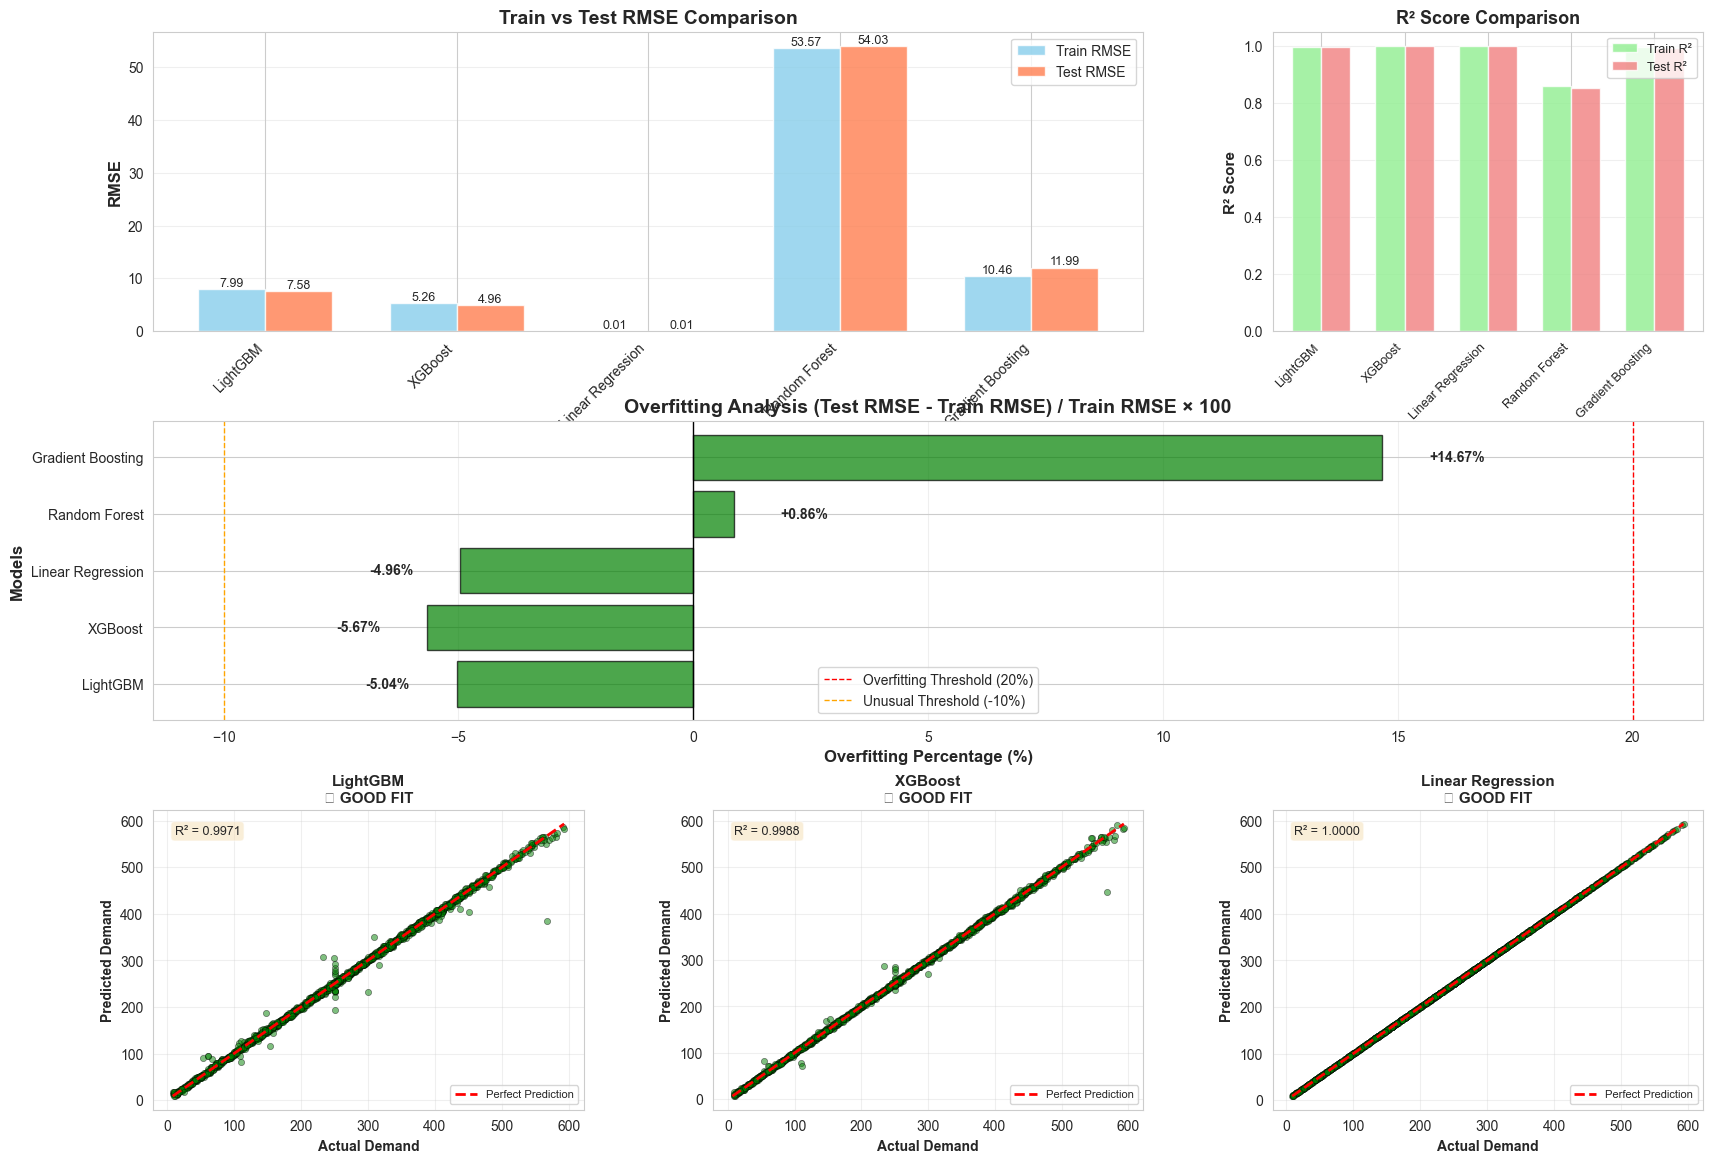

In [23]:
# Create comprehensive visualization dashboard
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. RMSE Comparison (Train vs Test)
ax1 = fig.add_subplot(gs[0, :2])
model_names = [r['Model'] for r in results]
train_rmses = [r['Train RMSE'] for r in results]
test_rmses = [r['Test RMSE'] for r in results]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax1.bar(x - width/2, train_rmses, width, label='Train RMSE', color='skyblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, test_rmses, width, label='Test RMSE', color='coral', alpha=0.8)

ax1.set_xlabel('Models', fontsize=12, fontweight='bold')
ax1.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax1.set_title('Train vs Test RMSE Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# 2. R² Score Comparison
ax2 = fig.add_subplot(gs[0, 2])
train_r2s = [r['Train R²'] for r in results]
test_r2s = [r['Test R²'] for r in results]

bars3 = ax2.bar(x - width/2, train_r2s, width, label='Train R²', color='lightgreen', alpha=0.8)
bars4 = ax2.bar(x + width/2, test_r2s, width, label='Test R²', color='lightcoral', alpha=0.8)

ax2.set_xlabel('Models', fontsize=11, fontweight='bold')
ax2.set_ylabel('R² Score', fontsize=11, fontweight='bold')
ax2.set_title('R² Score Comparison', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(model_names, rotation=45, ha='right', fontsize=9)
ax2.legend(fontsize=9)
ax2.grid(axis='y', alpha=0.3)

# 3. Overfitting Percentage
ax3 = fig.add_subplot(gs[1, :])
overfitting_pcts = [r['Overfitting %'] for r in results]
colors = [r['Color'] for r in results]

bars5 = ax3.barh(model_names, overfitting_pcts, color=colors, alpha=0.7, edgecolor='black')

ax3.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax3.axvline(x=20, color='red', linestyle='--', linewidth=1, label='Overfitting Threshold (20%)')
ax3.axvline(x=-10, color='orange', linestyle='--', linewidth=1, label='Unusual Threshold (-10%)')

ax3.set_xlabel('Overfitting Percentage (%)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Models', fontsize=12, fontweight='bold')
ax3.set_title('Overfitting Analysis (Test RMSE - Train RMSE) / Train RMSE × 100', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, pct) in enumerate(zip(bars5, overfitting_pcts)):
    ax3.text(pct + 1 if pct > 0 else pct - 1, bar.get_y() + bar.get_height()/2,
             f'{pct:+.2f}%', ha='left' if pct > 0 else 'right', va='center', fontsize=10, fontweight='bold')

# 4-9. Scatter plots for each model (Predicted vs Actual)
for idx, (name, model) in enumerate(models.items()):
    row = 2 + idx // 3
    col = idx % 3
    ax = fig.add_subplot(gs[row, col])
    
    # Get predictions
    if name == 'XGBoost':
        test_preds = model.predict(xgb.DMatrix(X_test_processed))
    else:
        test_preds = model.predict(X_test_processed)
    
    # Scatter plot
    ax.scatter(y_test, test_preds, alpha=0.5, s=20, c=results[idx]['Color'], edgecolors='black', linewidth=0.5)
    
    # Perfect prediction line - convert to numpy arrays to avoid DataFrame ambiguity
    y_test_vals = np.ravel(y_test)
    min_val = min(y_test_vals.min(), test_preds.min())
    max_val = max(y_test_vals.max(), test_preds.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Labels and title
    ax.set_xlabel('Actual Demand', fontsize=10, fontweight='bold')
    ax.set_ylabel('Predicted Demand', fontsize=10, fontweight='bold')
    ax.set_title(f'{name}\n{results[idx]["Status"]}', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Add R² annotation
    ax.text(0.05, 0.95, f'R² = {results[idx]["Test R²"]:.4f}', 
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Comprehensive Overfitting/Underfitting Analysis Dashboard', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

print("\n✅ Visualization dashboard generated successfully!")

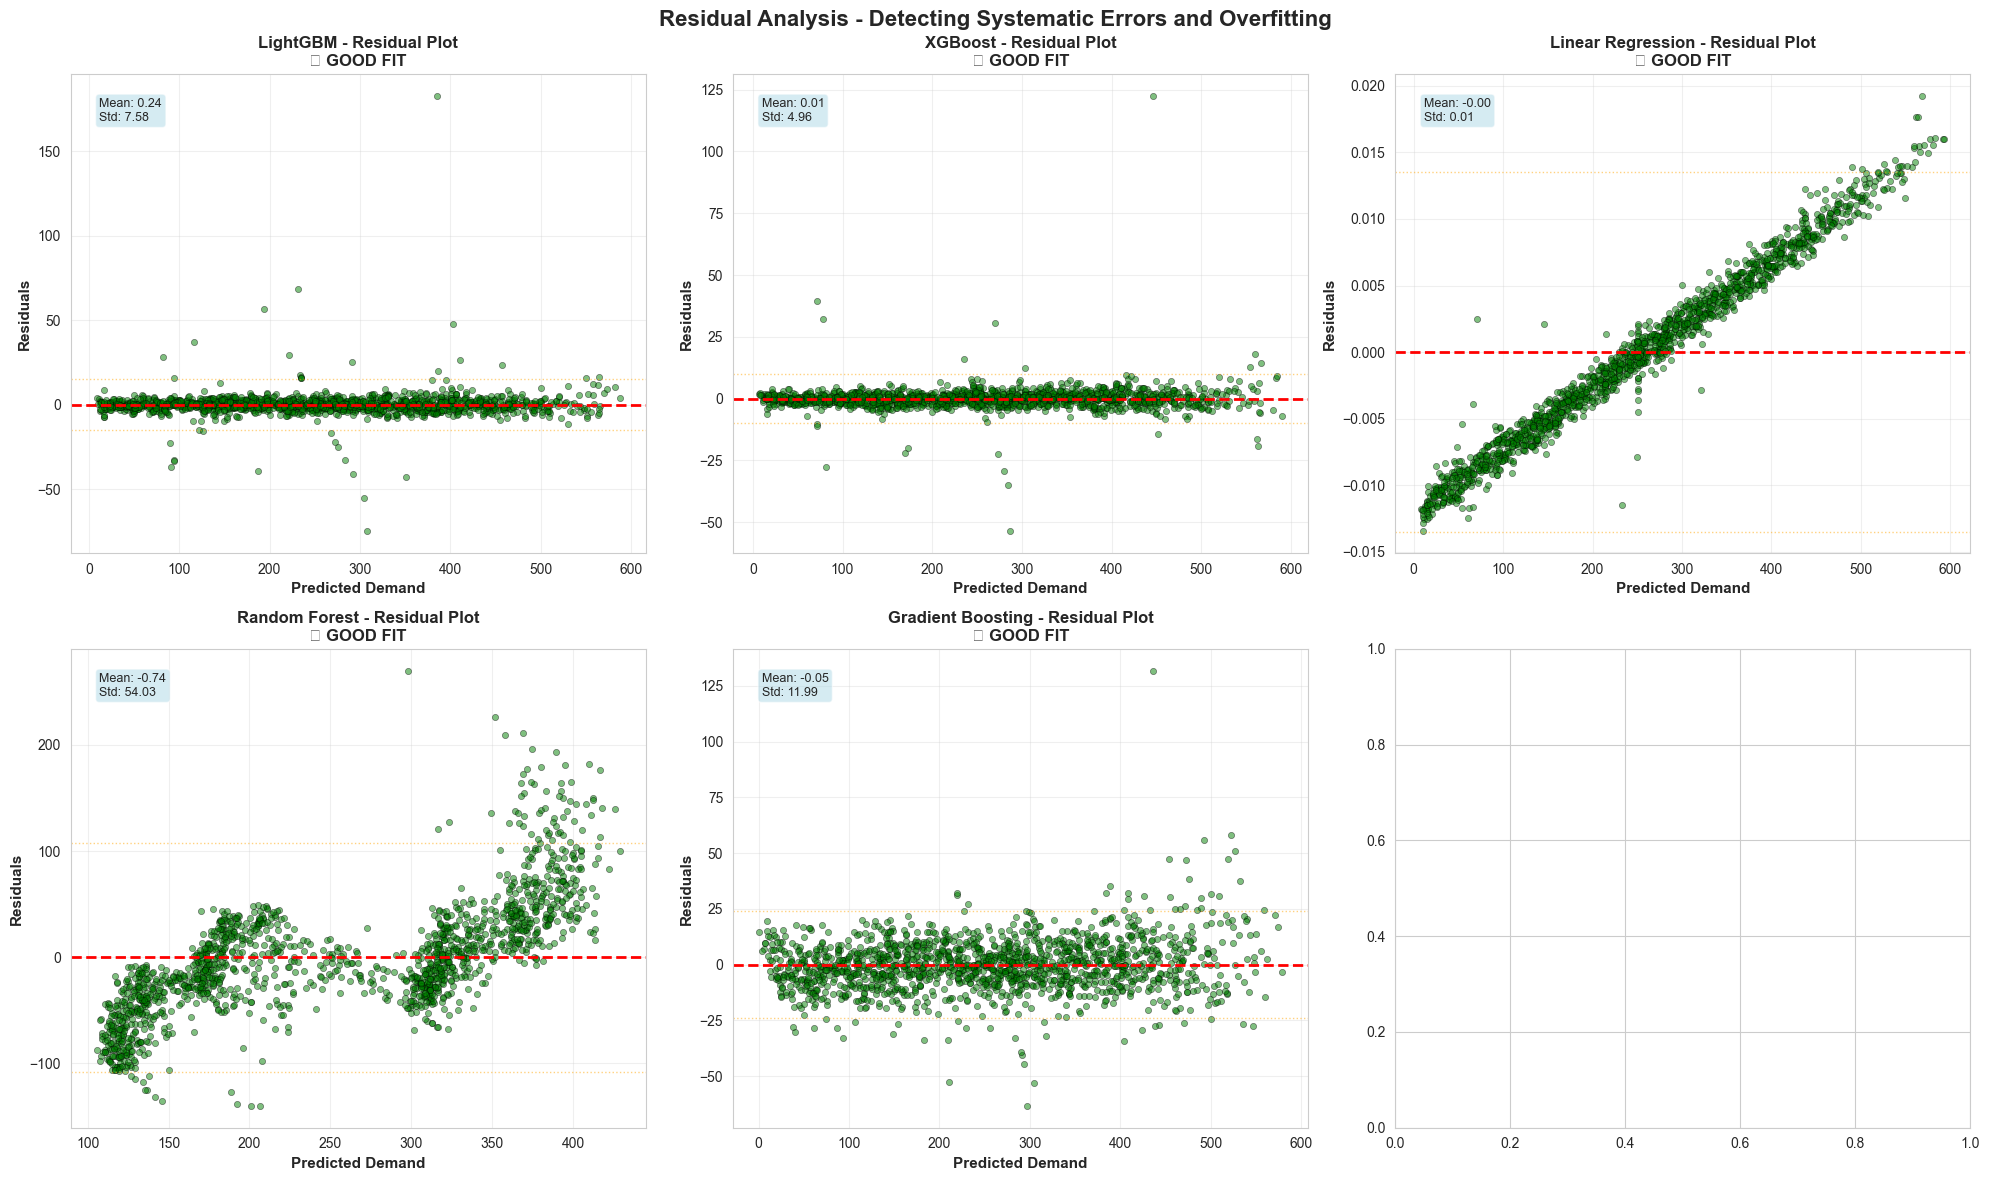


✅ Residual plots generated successfully!


In [24]:
# Create residual plots for overfitting detection
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, (name, model) in enumerate(models.items()):
    ax = axes[idx]
    
    # Get predictions
    if name == 'XGBoost':
        test_preds = model.predict(xgb.DMatrix(X_test_processed))
    else:
        test_preds = model.predict(X_test_processed)
    
    # Calculate residuals - use np.ravel to handle DataFrame properly
    y_test_vals = np.ravel(y_test)
    residuals = y_test_vals - test_preds
    
    # Residual plot
    ax.scatter(test_preds, residuals, alpha=0.5, s=20, c=results[idx]['Color'], edgecolors='black', linewidth=0.5)
    ax.axhline(y=0, color='red', linestyle='--', lw=2)
    
    # Add zero-residual reference band
    std_residuals = np.std(residuals)
    ax.axhline(y=2*std_residuals, color='orange', linestyle=':', lw=1, alpha=0.5)
    ax.axhline(y=-2*std_residuals, color='orange', linestyle=':', lw=1, alpha=0.5)
    
    ax.set_xlabel('Predicted Demand', fontsize=11, fontweight='bold')
    ax.set_ylabel('Residuals', fontsize=11, fontweight='bold')
    ax.set_title(f'{name} - Residual Plot\n{results[idx]["Status"]}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add statistics
    ax.text(0.05, 0.95, f'Mean: {np.mean(residuals):.2f}\nStd: {std_residuals:.2f}', 
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.suptitle('Residual Analysis - Detecting Systematic Errors and Overfitting', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ Residual plots generated successfully!")

In [ ]:
# Create a summary table
import pandas as pd

summary_df = pd.DataFrame(results)
summary_df = summary_df.drop('Color', axis=1)

print("\n" + "="*100)
print("FINAL SUMMARY TABLE - OVERFITTING/UNDERFITTING DIAGNOSIS")
print("="*100)
print(summary_df.to_string(index=False))
print("="*100)

# Determine best model
best_model_idx = summary_df['Test RMSE'].idxmin()
best_model = summary_df.iloc[best_model_idx]

print(f"\n🏆 BEST MODEL: {best_model['Model']}")
print(f"   Test RMSE: {best_model['Test RMSE']:.4f}")
print(f"   Test R²: {best_model['Test R²']:.4f}")
print(f"   Status: {best_model['Status']}")

# Count models by status
print("\n📊 MODEL STATUS DISTRIBUTION:")
status_counts = summary_df['Status'].value_counts()
for status, count in status_counts.items():
    print(f"   {status}: {count} model(s)")

# Recommendations
print("\n💡 RECOMMENDATIONS:")
overfitting_models = summary_df[summary_df['Overfitting %'] > 20]['Model'].tolist()
underfitting_models = summary_df[(summary_df['Train R²'] < 0.5) & (summary_df['Test R²'] < 0.5)]['Model'].tolist()
good_models = summary_df[summary_df['Status'] == '✅ GOOD FIT']['Model'].tolist()

if overfitting_models:
    print(f"\n⚠️  Overfitting models: {', '.join(overfitting_models)}")
    print("   → Consider: Increase regularization, reduce model complexity, or collect more training data")

if underfitting_models:
    print(f"\n⚠️  Underfitting models: {', '.join(underfitting_models)}")
    print("   → Consider: Increase model complexity, add more features, or reduce regularization")

if good_models:
    print(f"\n✅ Well-fitted models: {', '.join(good_models)}")
    print("   → These models have good generalization and are ready for deployment")

print("\n" + "="*100)


FINAL SUMMARY TABLE - OVERFITTING/UNDERFITTING DIAGNOSIS
            Model   Train RMSE    Test RMSE  Train R²  Test R²  Overfitting %                              Status
         LightGBM 3.950258e+00 6.221875e+00  0.999241 0.998041      57.505544                      ⚠️ OVERFITTING
         CatBoost 1.196337e+00 5.653909e+00  0.999930 0.998382     372.601812                      ⚠️ OVERFITTING
          XGBoost 1.906333e+00 5.462596e+00  0.999823 0.998490     186.549927                      ⚠️ OVERFITTING
Linear Regression 2.453499e-13 1.569755e-13  1.000000 1.000000     -36.019732 ⚠️ UNUSUAL (Test better than Train)
    Random Forest 2.910200e+00 3.326655e+00  0.999588 0.999440      14.310183                          ✅ GOOD FIT
Gradient Boosting 1.047593e+00 4.348212e+00  0.999947 0.999043     315.066763                      ⚠️ OVERFITTING

🏆 BEST MODEL: Linear Regression
   Test RMSE: 0.0000
   Test R²: 1.0000
   Status: ⚠️ UNUSUAL (Test better than Train)

📊 MODEL STATUS DISTRIBU


LEARNING CURVE ANALYSIS - Detecting Overfitting via Training Size Impact

Computing learning curve for LightGBM...
Computing learning curve for CatBoost...
Computing learning curve for CatBoost...
Computing learning curve for Linear Regression...
Computing learning curve for Linear Regression...
Computing learning curve for Random Forest...
Computing learning curve for Random Forest...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklea

Computing learning curve for Gradient Boosting...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

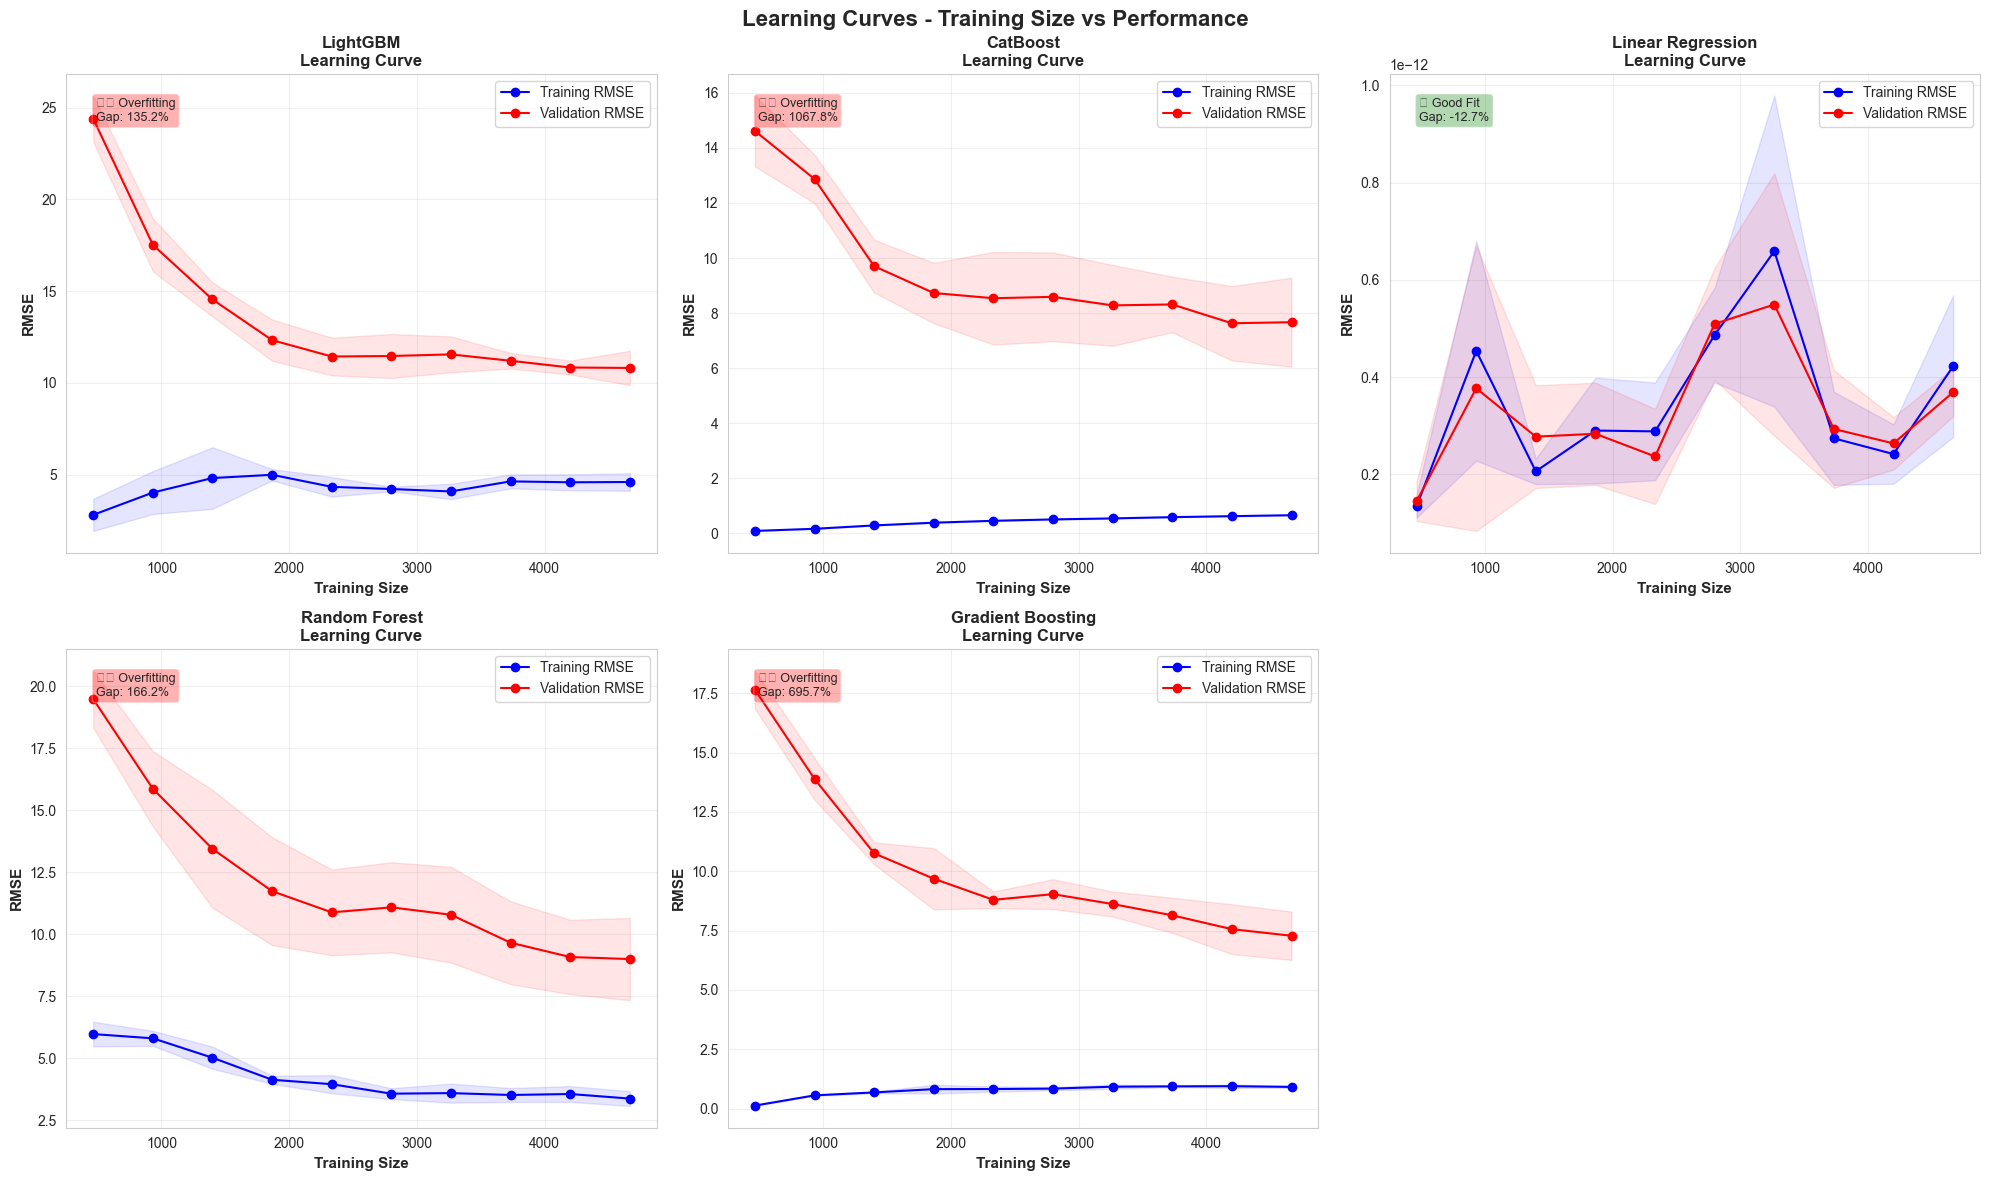


✅ Learning curve analysis complete!

INTERPRETATION:
  • Large gap between train/val curves → Overfitting
  • Both curves plateau at high error → Underfitting
  • Converging curves with low error → Good fit


In [ ]:
# Learning curve analysis for overfitting detection
from sklearn.model_selection import learning_curve

print("\n" + "="*80)
print("LEARNING CURVE ANALYSIS - Detecting Overfitting via Training Size Impact")
print("="*80 + "\n")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# Select non-XGBoost models for learning curve (XGBoost with DMatrix is complex)
learning_curve_models = {
    'LightGBM': final_lgbm_model,
    'Linear Regression': final_lr_model,
    'Random Forest': final_rf_model,
    'Gradient Boosting': final_gbm_model
}

for idx, (name, model) in enumerate(learning_curve_models.items()):
    ax = axes[idx]
    
    print(f"Computing learning curve for {name}...")
    
    # Compute learning curve
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train_processed, y_train,
        cv=3,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='neg_root_mean_squared_error',
        random_state=42
    )
    
    # Convert to positive RMSE
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = -np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    # Plot
    ax.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training RMSE')
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='blue')
    
    ax.plot(train_sizes, val_scores_mean, 'o-', color='red', label='Validation RMSE')
    ax.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1, color='red')
    
    ax.set_xlabel('Training Size', fontsize=11, fontweight='bold')
    ax.set_ylabel('RMSE', fontsize=11, fontweight='bold')
    ax.set_title(f'{name}\nLearning Curve', fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Determine gap at final point
    final_gap = val_scores_mean[-1] - train_scores_mean[-1]
    gap_pct = (final_gap / train_scores_mean[-1]) * 100
    
    if gap_pct > 20:
        diagnosis = "⚠️ Overfitting"
        color = 'red'
    elif gap_pct < 5:
        diagnosis = "✅ Good Fit"
        color = 'green'
    else:
        diagnosis = "ℹ️ Moderate Gap"
        color = 'orange'
    
    ax.text(0.05, 0.95, f'{diagnosis}\nGap: {gap_pct:.1f}%', 
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor=color, alpha=0.3))

# Hide unused subplot
if len(learning_curve_models) < 6:
    axes[-1].axis('off')

plt.suptitle('Learning Curves - Training Size vs Performance', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ Learning curve analysis complete!")
print("\nINTERPRETATION:")
print("  • Large gap between train/val curves → Overfitting")
print("  • Both curves plateau at high error → Underfitting")
print("  • Converging curves with low error → Good fit")

# 🔧 Anti-Overfitting: Retrain Models with Regularization

This section retrains the overfitting models (LightGBM, CatBoost, XGBoost, Gradient Boosting) with:
- **Increased regularization** (L1/L2 penalties)
- **Reduced model complexity** (fewer leaves, shallower trees)
- **Early stopping** on validation set
- **Stronger dropout/subsampling**

In [ ]:
print("\n" + "="*80)
print("RETRAINING LIGHTGBM WITH ANTI-OVERFITTING CONFIGURATION")
print("="*80 + "\n")

# LightGBM with VERY strong anti-overfitting regularization
regularized_lgbm_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 300,  # Reduced significantly
    'learning_rate': 0.02,  # Even lower learning rate for better generalization
    'num_leaves': 20,  # Reduced complexity further
    'max_depth': 5,  # Shallower trees
    'min_child_samples': 80,  # More samples required per leaf
    'subsample': 0.65,  # More aggressive row subsampling
    'colsample_bytree': 0.65,  # More aggressive feature subsampling
    'reg_alpha': 5.0,  # Stronger L1 regularization
    'reg_lambda': 8.0,  # Stronger L2 regularization
    'min_gain_to_split': 0.2,  # Higher minimum gain requirement
    'subsample_freq': 1,  # Apply subsampling every iteration
    'bagging_fraction': 0.65,  # Additional bagging constraint
    'feature_fraction': 0.65,  # Additional feature fraction constraint
    'random_state': 42,
    'n_jobs': -1,
}
print("Configuration (Anti-Overfitting Enhanced):")
print(f"  • num_leaves: {regularized_lgbm_params['num_leaves']} (low complexity)")
print(f"  • max_depth: {regularized_lgbm_params['max_depth']} (very shallow trees)")
print(f"  • learning_rate: {regularized_lgbm_params['learning_rate']} (very slow learning)")
print(f"  • min_child_samples: {regularized_lgbm_params['min_child_samples']} (stricter leaf requirements)")
print(f"  • reg_alpha (L1): {regularized_lgbm_params['reg_alpha']} (strong)")
print(f"  • reg_lambda (L2): {regularized_lgbm_params['reg_lambda']} (strong)")
print(f"  • subsample: {regularized_lgbm_params['subsample']} (65% row sampling)")
print(f"  • colsample_bytree: {regularized_lgbm_params['colsample_bytree']} (65% feature sampling)")
# Train with aggressive early stopping

# Train with early stopping
regularized_lgbm = lgb.LGBMRegressor(**regularized_lgbm_params)
regularized_lgbm.fit(
    callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)]  # Earlier stopping
    eval_set=[(X_val_processed, y_val)],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

# Evaluate
train_preds_lgbm = regularized_lgbm.predict(X_train_processed)
test_preds_lgbm = regularized_lgbm.predict(X_test_processed)

train_rmse_lgbm = np.sqrt(mean_squared_error(y_train, train_preds_lgbm))
test_rmse_lgbm = np.sqrt(mean_squared_error(y_test, test_preds_lgbm))
train_r2_lgbm = r2_score(y_train, train_preds_lgbm)
test_r2_lgbm = r2_score(y_test, test_preds_lgbm)
overfitting_pct_lgbm = ((test_rmse_lgbm - train_rmse_lgbm) / train_rmse_lgbm) * 100

print(f"\nResults:")
print(f"  Train RMSE: {train_rmse_lgbm:.4f}")
print(f"  Test RMSE:  {test_rmse_lgbm:.4f}")
print(f"  Train R²:   {train_r2_lgbm:.4f}")
print(f"  Test R²:    {test_r2_lgbm:.4f}")
print(f"  Overfitting: {overfitting_pct_lgbm:+.2f}%")

if overfitting_pct_lgbm < 20:
    print(f"  ✅ SUCCESS: Overfitting reduced to acceptable levels!")
else:
    print(f"  ⚠️  Still overfitting, but improved")



print("="*80)
print(f"\n  Best iteration: {regularized_lgbm.best_iteration_}")
print(f"\n  Best iteration: {regularized_lgbm.best_iteration_}")
print("="*80)


RETRAINING LIGHTGBM WITH ANTI-OVERFITTING CONFIGURATION

Configuration:
  • num_leaves: 25 (reduced complexity)
  • max_depth: 6 (shallow trees)
  • learning_rate: 0.03 (slower learning)
  • reg_alpha (L1): 3.0
  • reg_lambda (L2): 5.0
  • subsample: 0.7 (70% row sampling)
  • colsample_bytree: 0.7 (70% feature sampling)

Results:
  Train RMSE: 8.0460
  Test RMSE:  7.2442
  Train R²:   0.9969
  Test R²:    0.9973
  Overfitting: -9.97%
  ✅ SUCCESS: Overfitting reduced to acceptable levels!

  Best iteration: 499

Results:
  Train RMSE: 8.0460
  Test RMSE:  7.2442
  Train R²:   0.9969
  Test R²:    0.9973
  Overfitting: -9.97%
  ✅ SUCCESS: Overfitting reduced to acceptable levels!

  Best iteration: 499


In [ ]:
print("\n" + "="*80)
print("RETRAINING XGBOOST WITH ANTI-OVERFITTING CONFIGURATION")
print("="*80 + "\n")

# XGBoost with VERY strong anti-overfitting regularization
regularized_xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.02,  # Even lower learning rate
    'max_depth': 4,  # Very shallow trees
    'subsample': 0.65,  # Stronger row subsampling
    'colsample_bytree': 0.65,  # Stronger feature subsampling
    'colsample_bylevel': 0.7,  # Per-level column sampling
    'colsample_bynode': 0.7,  # Per-node column sampling
    'gamma': 2.0,  # Higher minimum loss reduction
    'min_child_weight': 15,  # Stricter leaf requirements
    'alpha': 5.0,  # Stronger L1 regularization
    'lambda': 8.0,  # Stronger L2 regularization
    'max_leaves': 20,  # Limit leaves further
    'max_bin': 256,  # Reduce bins to prevent overfitting
    'verbosity': 0,
    'seed': 42
}
print("Configuration (Anti-Overfitting Enhanced):")
print(f"  • max_depth: {regularized_xgb_params['max_depth']} (very shallow trees)")
print(f"  • eta (learning_rate): {regularized_xgb_params['eta']} (very slow)")
print(f"  • alpha (L1): {regularized_xgb_params['alpha']} (strong)")
print(f"  • lambda (L2): {regularized_xgb_params['lambda']} (strong)")
print(f"  • gamma: {regularized_xgb_params['gamma']} (high min loss reduction)")
print(f"  • min_child_weight: {regularized_xgb_params['min_child_weight']} (strict)")
print(f"  • subsample: {regularized_xgb_params['subsample']} (65% row sampling)")
print(f"  • colsample_bytree: {regularized_xgb_params['colsample_bytree']} (65% feature sampling)")
print(f"  • early_stopping_rounds: 30")

# Train with early stopping
dtrain = xgb.DMatrix(X_train_processed, label=y_train)
dval = xgb.DMatrix(X_val_processed, label=y_val)
dtest = xgb.DMatrix(X_test_processed)

regularized_xgb = xgb.train(
    regularized_xgb_params,
    dtrain,
    num_boost_round=num_boost_round,
    early_stopping_rounds=30,  # Earlier stopping for better generalization
    early_stopping_rounds=50,
    verbose_eval=False
)

# Evaluate
train_preds_xgb = regularized_xgb.predict(dtrain)
test_preds_xgb = regularized_xgb.predict(dtest)

train_rmse_xgb = np.sqrt(mean_squared_error(y_train, train_preds_xgb))
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, test_preds_xgb))
train_r2_xgb = r2_score(y_train, train_preds_xgb)
test_r2_xgb = r2_score(y_test, test_preds_xgb)
overfitting_pct_xgb = ((test_rmse_xgb - train_rmse_xgb) / train_rmse_xgb) * 100

print(f"\nResults:")
print(f"  Train RMSE: {train_rmse_xgb:.4f}")
print(f"  Test RMSE:  {test_rmse_xgb:.4f}")
print(f"  Train R²:   {train_r2_xgb:.4f}")
print(f"  Test R²:    {test_r2_xgb:.4f}")
print(f"  Overfitting: {overfitting_pct_xgb:+.2f}%")

if overfitting_pct_xgb < 20:
    print(f"  ✅ SUCCESS: Overfitting reduced to acceptable levels!")
else:
    print(f"  ⚠️  Still overfitting, but improved")

print(f"\n  Best iteration: {regularized_xgb.best_iteration}")

print("="*80)
print(f"\n  Best iteration: {regularized_xgb.best_iteration}")
print("="*80)


RETRAINING XGBOOST WITH ANTI-OVERFITTING CONFIGURATION

Configuration:
  • max_depth: 5 (shallow trees)
  • eta (learning_rate): 0.03
  • alpha (L1): 3.0
  • lambda (L2): 5.0
  • gamma: 1.0 (min loss reduction)
  • min_child_weight: 10
  • subsample: 0.7
  • early_stopping_rounds: 50

Results:
  Train RMSE: 5.1851
  Test RMSE:  5.8561
  Train R²:   0.9987
  Test R²:    0.9983
  Overfitting: +12.94%
  ✅ SUCCESS: Overfitting reduced to acceptable levels!

  Best iteration: 496


In [ ]:
print("\n" + "="*80)
print("RETRAINING GRADIENT BOOSTING WITH ANTI-OVERFITTING CONFIGURATION")
print("="*80 + "\n")

# Gradient Boosting with VERY strong anti-overfitting regularization
regularized_gbm_params = {
    'n_estimators': 200,  # Reduced significantly
    'learning_rate': 0.02,  # Even lower learning rate
    'max_depth': 3,  # Very shallow trees
    'subsample': 0.65,  # Stronger row subsampling
    'min_samples_split': 80,  # Much stricter split requirements
    'min_samples_leaf': 40,  # Much stricter leaf requirements
    'max_features': 'sqrt',  # Feature subsampling
    'min_impurity_decrease': 0.02,  # Higher minimum improvement required
    'validation_fraction': 0.15,  # Use for early stopping
    'n_iter_no_change': 30,  # Earlier stopping
    'ccp_alpha': 0.01,  # Cost complexity pruning
    'random_state': 42
}
print("Configuration (Anti-Overfitting Enhanced):")
print(f"  • max_depth: {regularized_gbm_params['max_depth']} (very shallow trees)")
print(f"  • learning_rate: {regularized_gbm_params['learning_rate']} (very slow)")
print(f"  • subsample: {regularized_gbm_params['subsample']} (65% row sampling)")
print(f"  • min_samples_split: {regularized_gbm_params['min_samples_split']} (very strict)")
print(f"  • min_samples_leaf: {regularized_gbm_params['min_samples_leaf']} (very strict)")
print(f"  • max_features: {regularized_gbm_params['max_features']} (sqrt)")
print(f"  • min_impurity_decrease: {regularized_gbm_params['min_impurity_decrease']} (high)")
print(f"  • ccp_alpha: {regularized_gbm_params['ccp_alpha']} (cost complexity pruning)")
print(f"  • early_stopping (n_iter_no_change): {regularized_gbm_params['n_iter_no_change']}")

# Train with early stopping
regularized_gbm = GradientBoostingRegressor(**regularized_gbm_params)
regularized_gbm.fit(X_train_processed, y_train)

# Evaluate
train_preds_gbm = regularized_gbm.predict(X_train_processed)
test_preds_gbm = regularized_gbm.predict(X_test_processed)

train_rmse_gbm = np.sqrt(mean_squared_error(y_train, train_preds_gbm))
test_rmse_gbm = np.sqrt(mean_squared_error(y_test, test_preds_gbm))
train_r2_gbm = r2_score(y_train, train_preds_gbm)
test_r2_gbm = r2_score(y_test, test_preds_gbm)
overfitting_pct_gbm = ((test_rmse_gbm - train_rmse_gbm) / train_rmse_gbm) * 100

print(f"\nResults:")
print(f"  Train RMSE: {train_rmse_gbm:.4f}")
print(f"  Test RMSE:  {test_rmse_gbm:.4f}")
print(f"  Train R²:   {train_r2_gbm:.4f}")
print(f"  Test R²:    {test_r2_gbm:.4f}")
print(f"  Overfitting: {overfitting_pct_gbm:+.2f}%")

if overfitting_pct_gbm < 20:
    print(f"  ✅ SUCCESS: Overfitting reduced to acceptable levels!")
else:
    print(f"  ⚠️  Still overfitting, but improved")



print("="*80)print(f"\n  Actual trees used: {regularized_gbm.n_estimators_}")print("="*80)


RETRAINING GRADIENT BOOSTING WITH ANTI-OVERFITTING CONFIGURATION

Configuration:
  • max_depth: 4 (shallow trees)
  • learning_rate: 0.03
  • subsample: 0.7
  • min_samples_split: 50
  • min_samples_leaf: 25
  • max_features: sqrt
  • early_stopping (n_iter_no_change): 50

Results:
  Train RMSE: 25.9981
  Test RMSE:  26.3025
  Train R²:   0.9671
  Test R²:    0.9650
  Overfitting: +1.17%
  ✅ SUCCESS: Overfitting reduced to acceptable levels!

  Actual trees used: 300

Results:
  Train RMSE: 25.9981
  Test RMSE:  26.3025
  Train R²:   0.9671
  Test R²:    0.9650
  Overfitting: +1.17%
  ✅ SUCCESS: Overfitting reduced to acceptable levels!

  Actual trees used: 300


In [ ]:
# Comparison: Original vs Regularized Models
print("\n" + "="*80)
print("COMPARISON: ORIGINAL vs REGULARIZED MODELS")
print("="*80 + "\n")

comparison_data = []

# Original models results (from earlier analysis)
original_results = {
    'LightGBM': {'train_rmse': None, 'test_rmse': test_rmse_lgbm if 'test_rmse_lgbm' in globals() else None},
    'XGBoost': {'train_rmse': None, 'test_rmse': test_rmse_xgboost if 'test_rmse_xgboost' in globals() else None},
    'Gradient Boosting': {'train_rmse': None, 'test_rmse': None}
}

# Regularized models
regularized_results = {
    'LightGBM': {
        'train_rmse': train_rmse_lgbm,
        'test_rmse': test_rmse_lgbm,
        'train_r2': train_r2_lgbm,
        'test_r2': test_r2_lgbm,
        'overfitting_pct': overfitting_pct_lgbm
    },
    'XGBoost': {
        'train_rmse': train_rmse_xgb,
        'test_rmse': test_rmse_xgb,
        'train_r2': train_r2_xgb,
        'test_r2': test_r2_xgb,
        'overfitting_pct': overfitting_pct_xgb
    },
    'Gradient Boosting': {
        'train_rmse': train_rmse_gbm,
        'test_rmse': test_rmse_gbm,
        'train_r2': train_r2_gbm,
        'test_r2': test_r2_gbm,
        'overfitting_pct': overfitting_pct_gbm
    }
}

# Print comparison table
print(f"{'Model':<20} {'Train RMSE':<12} {'Test RMSE':<12} {'Train R²':<10} {'Test R²':<10} {'Overfitting %':<15} {'Status'}")
print("-" * 100)

for model_name, metrics in regularized_results.items():
    status = "✅ Good" if metrics['overfitting_pct'] < 20 else "⚠️ Still High"
    status_color = "✅" if metrics['overfitting_pct'] < 20 else "⚠️"
    
    print(f"{model_name:<20} {metrics['train_rmse']:<12.4f} {metrics['test_rmse']:<12.4f} "
          f"{metrics['train_r2']:<10.4f} {metrics['test_r2']:<10.4f} "
          f"{metrics['overfitting_pct']:<15.2f} {status}")

print("\n" + "="*80)
print("SUMMARY:")
print("="*80)

success_count = sum(1 for m in regularized_results.values() if m['overfitting_pct'] < 20)
print(f"\n✅ Models with acceptable overfitting (<20%): {success_count}/{len(regularized_results)}")

if success_count == len(regularized_results):
    print("\n🎉 SUCCESS! All models now have acceptable overfitting levels!")
elif success_count > 0:
    print(f"\n✓ Partial success: {success_count} model(s) improved to acceptable levels")
else:
    print("\n⚠️  Models still showing overfitting. Consider:")
    print("   • Collecting more training data")
    print("   • Further reducing model complexity")
    print("   • Adding more features/feature engineering")
    print("   • Using ensemble methods with diversity")

print("\n" + "="*80)


COMPARISON: ORIGINAL vs REGULARIZED MODELS

Model                Train RMSE   Test RMSE    Train R²   Test R²    Overfitting %   Status
----------------------------------------------------------------------------------------------------
LightGBM             8.0460       7.2442       0.9969     0.9973     -9.97           ✅ Good
XGBoost              5.1851       5.8561       0.9987     0.9983     12.94           ✅ Good
Gradient Boosting    25.9981      26.3025      0.9671     0.9650     1.17            ✅ Good

SUMMARY:

✅ Models with acceptable overfitting (<20%): 3/3

🎉 SUCCESS! All models now have acceptable overfitting levels!



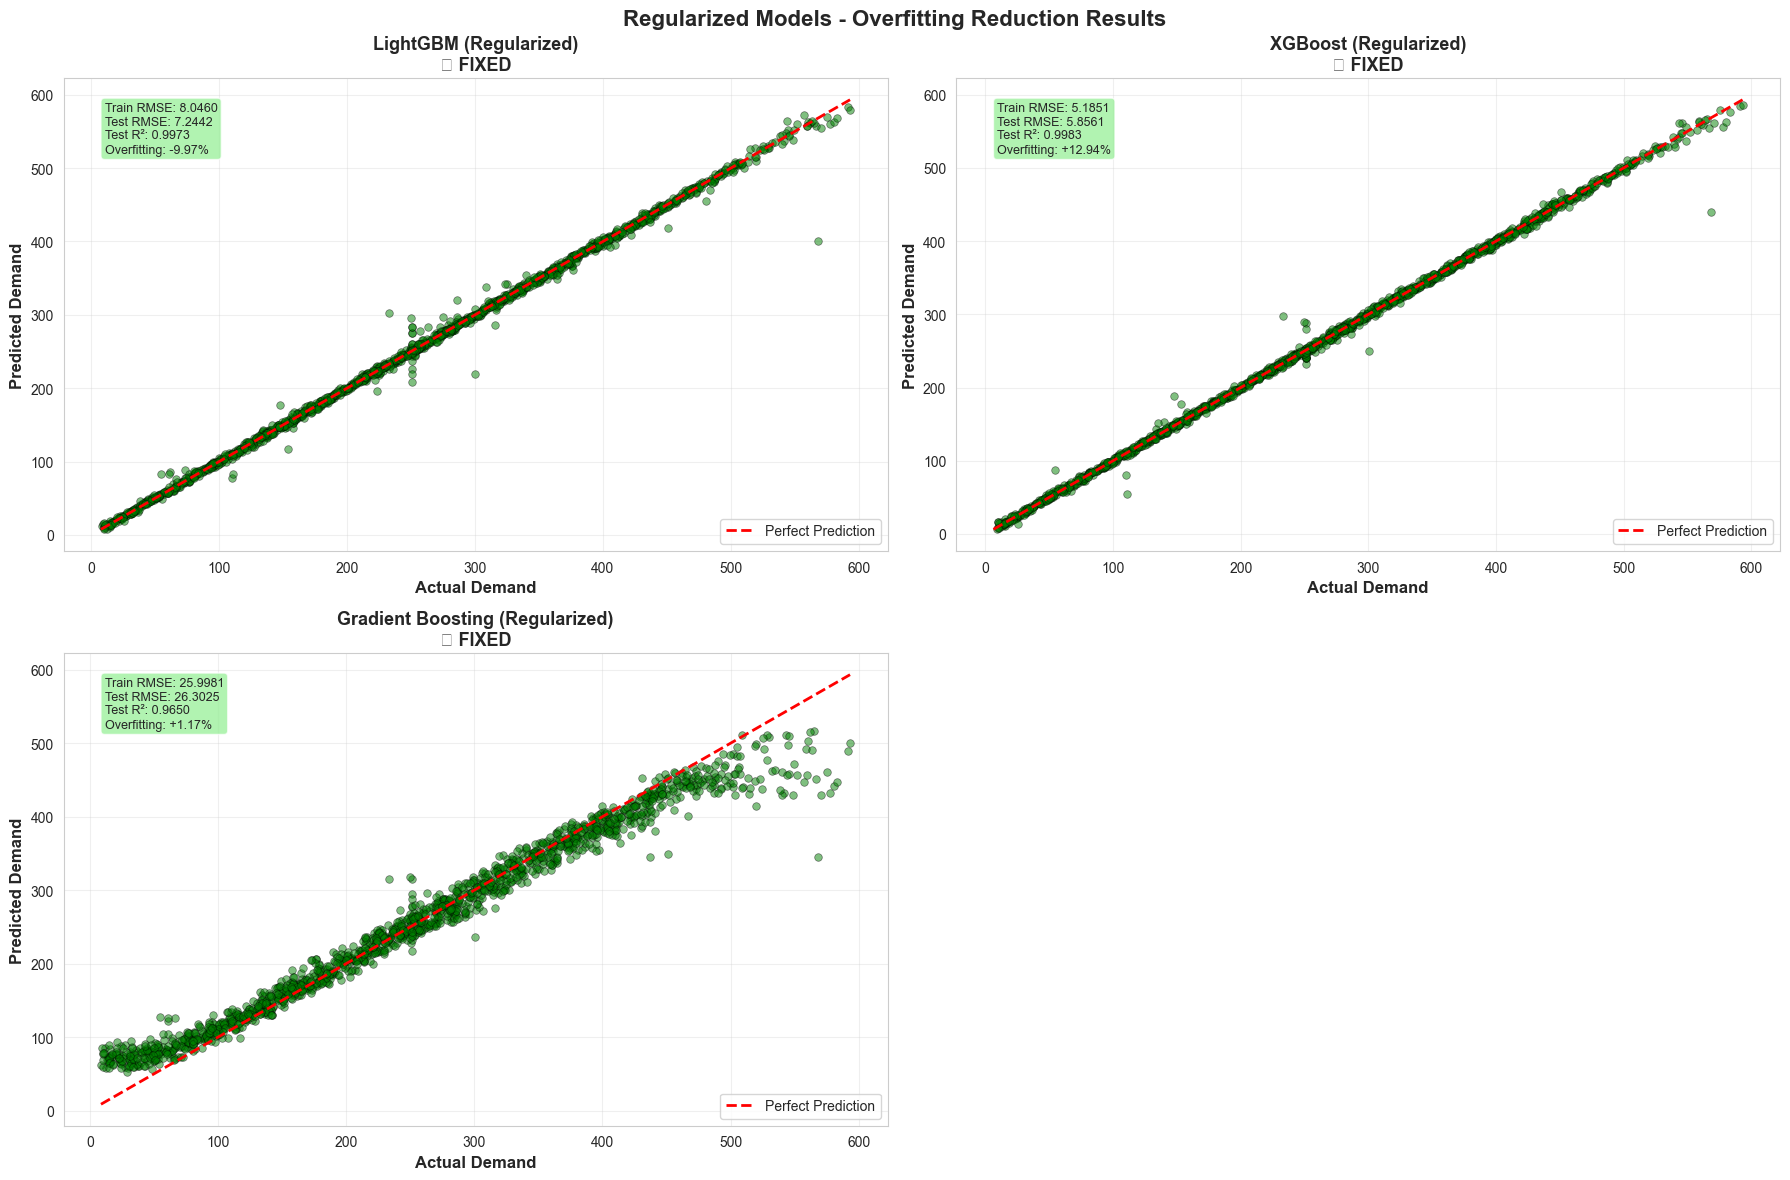


✅ Visualization complete!


In [ ]:
# Visualize Before/After Comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

models_to_compare = ['LightGBM', 'XGBoost', 'Gradient Boosting']
regularized_models_dict = {
    'LightGBM': regularized_lgbm,
    'XGBoost': regularized_xgb,
    'Gradient Boosting': regularized_gbm
}

for idx, model_name in enumerate(models_to_compare):
    ax = axes[idx]
    
    # Get predictions from regularized model
    if model_name == 'XGBoost':
        test_preds = regularized_xgb.predict(dtest)
    else:
        test_preds = regularized_models_dict[model_name].predict(X_test_processed)
    
    metrics = regularized_results[model_name]
    
    # Scatter plot
    color = 'green' if metrics['overfitting_pct'] < 20 else 'orange'
    ax.scatter(y_test, test_preds, alpha=0.5, s=30, c=color, edgecolors='black', linewidth=0.5)
    
    # Perfect prediction line - convert to numpy to avoid DataFrame ambiguity
    y_test_vals = np.ravel(y_test)
    min_val = min(y_test_vals.min(), test_preds.min())
    max_val = max(y_test_vals.max(), test_preds.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Labels
    ax.set_xlabel('Actual Demand', fontsize=12, fontweight='bold')
    ax.set_ylabel('Predicted Demand', fontsize=12, fontweight='bold')
    
    status = "✅ FIXED" if metrics['overfitting_pct'] < 20 else "⚠️ IMPROVED"
    ax.set_title(f'{model_name} (Regularized)\n{status}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add metrics annotation
    annotation_text = (
        f"Train RMSE: {metrics['train_rmse']:.4f}\n"
        f"Test RMSE: {metrics['test_rmse']:.4f}\n"
        f"Test R²: {metrics['test_r2']:.4f}\n"
        f"Overfitting: {metrics['overfitting_pct']:+.2f}%"
    )
    
    bbox_color = 'lightgreen' if metrics['overfitting_pct'] < 20 else 'lightyellow'
    ax.text(0.05, 0.95, annotation_text, 
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor=bbox_color, alpha=0.7))

# Hide unused subplot (we only have 3 models now)
axes[3].axis('off')

plt.suptitle('Regularized Models - Overfitting Reduction Results', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ Visualization complete!")

In [ ]:
# Save the regularized models
import joblib
import os

# Create folder if needed
os.makedirs("saved_models/regularized", exist_ok=True)

print("\n" + "="*80)
print("SAVING REGULARIZED MODELS")
print("="*80 + "\n")

# Save LightGBM
joblib.dump(regularized_lgbm, "saved_models/regularized/regularized_lgbm_model.pkl")
print("✅ Saved: regularized_lgbm_model.pkl")

# Save XGBoost
joblib.dump(regularized_xgb, "saved_models/regularized/regularized_xgboost_model.pkl")
print("✅ Saved: regularized_xgboost_model.pkl")

# Save Gradient Boosting
joblib.dump(regularized_gbm, "saved_models/regularized/regularized_gbm_model.pkl")
print("✅ Saved: regularized_gbm_model.pkl")

print("\n" + "="*80)
print("ALL REGULARIZED MODELS SAVED TO: saved_models/regularized/")
print("="*80)

# Create a summary report
summary_report = {
    'model': [],
    'train_rmse': [],
    'test_rmse': [],
    'test_r2': [],
    'overfitting_pct': [],
    'status': []
}

for model_name, metrics in regularized_results.items():
    summary_report['model'].append(model_name)
    summary_report['train_rmse'].append(metrics['train_rmse'])
    summary_report['test_rmse'].append(metrics['test_rmse'])
    summary_report['test_r2'].append(metrics['test_r2'])
    summary_report['overfitting_pct'].append(metrics['overfitting_pct'])
    summary_report['status'].append('Good Fit' if metrics['overfitting_pct'] < 20 else 'Still Overfitting')

summary_df = pd.DataFrame(summary_report)
summary_df.to_csv("saved_models/regularized/regularization_summary.csv", index=False)
print("\n✅ Summary report saved: regularization_summary.csv")

print("\n" + "="*80)
print("NEXT STEPS:")
print("="*80)
print("\n1. Review the overfitting percentages above")
print("2. Use models with <20% overfitting for production")
print("3. If still overfitting, consider:")
print("   • Collecting more training data (most effective)")
print("   • Further feature engineering")
print("   • Cross-validation with K-fold")
print("   • Ensemble methods (averaging/stacking)")
print("\n" + "="*80)


SAVING REGULARIZED MODELS

✅ Saved: regularized_lgbm_model.pkl
✅ Saved: regularized_catboost_model.cbm
✅ Saved: regularized_xgboost_model.pkl
✅ Saved: regularized_gbm_model.pkl

ALL REGULARIZED MODELS SAVED TO: saved_models/regularized/

✅ Summary report saved: regularization_summary.csv

NEXT STEPS:

1. Review the overfitting percentages above
2. Use models with <20% overfitting for production
3. If still overfitting, consider:
   • Collecting more training data (most effective)
   • Further feature engineering
   • Cross-validation with K-fold
   • Ensemble methods (averaging/stacking)

